# Time Series Applied Project 

A group project completed by myself, Mr Issac Pockney and Mr Michael Morgan-Giles in time-series analysis unit as part of the econometrics specialisation in the University of Sydney's Master of Economics Program. We employ various statistical and machine-learning techniques to produce forecasts of macroeconomic variables. 


In [485]:
%reset -f

In [486]:
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import numpy             as np
import csv
import xgboost           as xgb

from scipy.stats                            import t
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from datetime                               import datetime
from statsmodels.tsa.stattools              import adfuller
from statsmodels.tsa.api                    import VAR
from statsmodels.tsa.arima.model            import ARIMA
from statsmodels.tsa.vector_ar.vecm         import coint_johansen
from scipy                                  import stats
from statsmodels.tsa.stattools              import acf
from statsmodels.graphics.tsaplots          import plot_acf
from sklearn.preprocessing                  import StandardScaler
from sklearn.metrics                        import mean_squared_error, mean_absolute_error
from sklearn.model_selection                import GridSearchCV, TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.neural_network                 import MLPRegressor
from sklearn.ensemble                       import RandomForestRegressor
from sklearn.linear_model                   import LinearRegression, Lasso, RidgeCV
from sklearn.metrics                        import r2_score
from sklearn.svm                            import SVR, LinearSVR
from sklearn                                import linear_model
from statsmodels.tsa.holtwinters            import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal               import seasonal_decompose
from statsmodels.tsa.ardl                   import ARDL
from statsmodels.tsa.ardl                   import ardl_select_order

In [487]:
!pip install pmdarima
from pmdarima.arima              import auto_arima
from statsmodels.iolib.summary2  import summary_col
import math

In [488]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
sns.mpl.rc('figure',figsize=(16, 6))

### Load Data Frame and create date index

In [489]:
df = pd.read_csv("data.csv")

In [490]:
df['date'] = pd.date_range(start='01-JAN-1990', end='01-DEC-2019', freq='MS')

### Plot Series

In [491]:
df = df.set_index('date')

In [492]:
df_plot = df[['GS10', 'EXUSUKx', 'USCONS']]

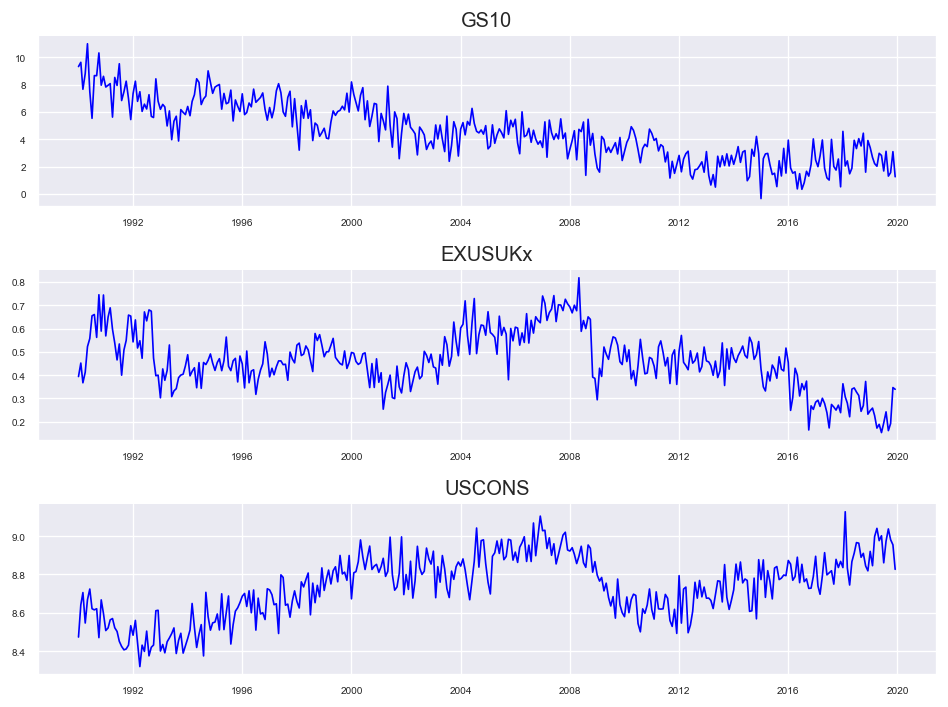

In [493]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(8, 6))
for i, ax in enumerate(axes.flatten()):
    data = df[df_plot.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df_plot.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Decomposition of Data

We decompose our data into cyclical, seaonsal and irregular components. We use both multiplicative decomposition and additive decomposition. On observing graphs we can determine that it is the multiplicative method that captures more of the variation in each of the time series. 

#### Multiplicative Decomposition

 Moving Average & Centered Moving Average

In [494]:
df['MA_GS10'] = df['GS10'].rolling(window=12, center = True).mean()
df['MA_EXUSUKx'] = df['EXUSUKx'].rolling(window=12, center = True).mean()
df['MA_USCONS'] = df['USCONS'].rolling(window=12, center = True).mean()

In [495]:
df['CMA_GS10'] = df['MA_GS10'].rolling(window=2, center = True).mean().shift(-1)
df['CMA_EXUSUKx'] = df['MA_EXUSUKx'].rolling(window=2, center = True).mean().shift(-1)
df['CMA_USCONS'] = df['MA_USCONS'].rolling(window=2, center = True).mean().shift(-1)

 Compute Y/CMA (Seasonality)

In [496]:
df['GS10/CMA_GS10'] = df['GS10']/df['CMA_GS10']
df['EXUSUKx/CMA_EXUSUKx'] = df['EXUSUKx']/df['CMA_EXUSUKx']
df['USCONS/CMA_USCONS'] = df['USCONS']/df['CMA_USCONS']

In [497]:
names = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']

for i, x in enumerate(names):
    df[x] = (df.index.get_level_values(0).month == i+1).astype(int)

 regress Y/CMA on monthly dummies & predict SN\bar

In [498]:
m1 = sm.OLS(df['GS10/CMA_GS10'], df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']],missing = 'drop')
results_1 = m1.fit()

m2 = sm.OLS(df['EXUSUKx/CMA_EXUSUKx'], df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']],missing = 'drop')
results_2 = m2.fit()

m3 = sm.OLS(df['USCONS/CMA_USCONS'], df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']],missing = 'drop')
results_3 = m3.fit()

In [499]:
df['snbar_GS10'] = results_1.predict(df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']])
df['snbar_EXUSUKx'] = results_2.predict(df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']])
df['snbar_USCONS'] = results_3.predict(df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']])

In [500]:
df1 = df.head(12)

In [501]:
df1['snbar_GS10'].mean()
df1['snbar_EXUSUKx'].mean()
df1['snbar_USCONS'].mean()

0.9999900514249043

In [502]:
df['sn_GS10'] = df['snbar_GS10']/df1['snbar_GS10'].mean()
df['sn_EXUSUKx'] = df['snbar_EXUSUKx']/df1['snbar_EXUSUKx'].mean()
df['sn_USCONS'] = df['snbar_USCONS']/df1['snbar_USCONS'].mean()

 Deseasonalise the trend using time polynomials

In [503]:
df['d_GS10'] = df['GS10']/df['sn_GS10']
df['d_EXUSUKx'] = df['EXUSUKx']/df['sn_EXUSUKx']
df['d_USCONS'] = df['USCONS']/df['sn_USCONS']

In [504]:
df['t'] = np.arange(len(df))
df['t2'] = np.power(df['t'],2)
df['t3'] = np.power(df['t'],3)
df['t4'] = np.power(df['t'],4)

In [505]:
X = df[['t','t2','t3','t4']]
X = sm.add_constant(X)

model1= sm.OLS(df['d_GS10'], X, missing='drop')
results1 = model1.fit()

model2= sm.OLS(df['d_EXUSUKx'], X, missing='drop')
results2 = model2.fit()

model3= sm.OLS(df['d_USCONS'], X, missing='drop')
results3 = model3.fit()

In [506]:
df['tr_GS10'] = results1.predict(X)
df['tr_EXUSUKx'] = results2.predict(X)
df['tr_USCONS'] = results3.predict(X)

In [507]:
df['trsn_GS10'] = df['tr_GS10'] * df['sn_GS10']
df['trsn_EXUSUKx'] = df['tr_EXUSUKx'] * df['sn_EXUSUKx']
df['trsn_USCONS'] = df['tr_USCONS'] * df['sn_USCONS']

 Cycle & Irregular Component

In [508]:
df['clir_GS10'] = df['d_GS10'] / df['tr_GS10']
df['clir_EXUSUKx'] = df['d_EXUSUKx'] / df['tr_EXUSUKx']
df['clir_USCONS'] = df['d_USCONS'] / df['tr_USCONS']

In [509]:
df['cl_GS10']      = df['clir_GS10'].rolling(window=3, center=True).mean()
df['cl_GS10'][0]   = (2*df['clir_GS10'][0]   + df['clir_GS10'][1]  )/3
df['cl_GS10'][354] = (2*df['clir_GS10'][354] + df['clir_GS10'][353])/3

<ipython-input-509-c6e211110b1d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cl_GS10'][0]   = (2*df['clir_GS10'][0]   + df['clir_GS10'][1]  )/3
<ipython-input-509-c6e211110b1d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cl_GS10'][354] = (2*df['clir_GS10'][354] + df['clir_GS10'][353])/3


In [510]:
df['cl_EXUSUKx']      = df['clir_EXUSUKx'].rolling(window=3, center=True).mean()
df['cl_EXUSUKx'][0]   = (2*df['clir_EXUSUKx'][0]   + df['clir_EXUSUKx'][1]  )/3
df['cl_EXUSUKx'][354] = (2*df['clir_EXUSUKx'][354] + df['clir_EXUSUKx'][353])/3

<ipython-input-510-a81ddf53a81e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cl_EXUSUKx'][0]   = (2*df['clir_EXUSUKx'][0]   + df['clir_EXUSUKx'][1]  )/3
<ipython-input-510-a81ddf53a81e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cl_EXUSUKx'][354] = (2*df['clir_EXUSUKx'][354] + df['clir_EXUSUKx'][353])/3


In [511]:
df['cl_USCONS']      = df['clir_USCONS'].rolling(window=3, center=True).mean()
df['cl_USCONS'][0]   = (2*df['clir_USCONS'][0]   + df['clir_USCONS'][1]  )/3
df['cl_USCONS'][354] = (2*df['clir_USCONS'][354] + df['clir_USCONS'][353])/3

<ipython-input-511-10cfbc021969>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cl_USCONS'][0]   = (2*df['clir_USCONS'][0]   + df['clir_USCONS'][1]  )/3
<ipython-input-511-10cfbc021969>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cl_USCONS'][354] = (2*df['clir_USCONS'][354] + df['clir_USCONS'][353])/3


 Irregular Component

In [512]:
df['ir_GS10'] = df['clir_GS10']/df['cl_GS10']

In [513]:
df['ir_EXUSUKx'] = df['clir_EXUSUKx']/df['cl_EXUSUKx']

In [514]:
df['ir_USCONS'] = df['clir_USCONS']/df['cl_USCONS']

 Trend x Season x Cycle

In [515]:
df['trsncl_GS10']= df['trsn_GS10'] * df['cl_GS10']

In [516]:
df['trsncl_EXUSUKx']= df['trsn_EXUSUKx'] * df['cl_EXUSUKx']

In [517]:
df['trsncl_USCONS']= df['trsn_USCONS'] * df['cl_USCONS']

 Plot of Multiplicative Series

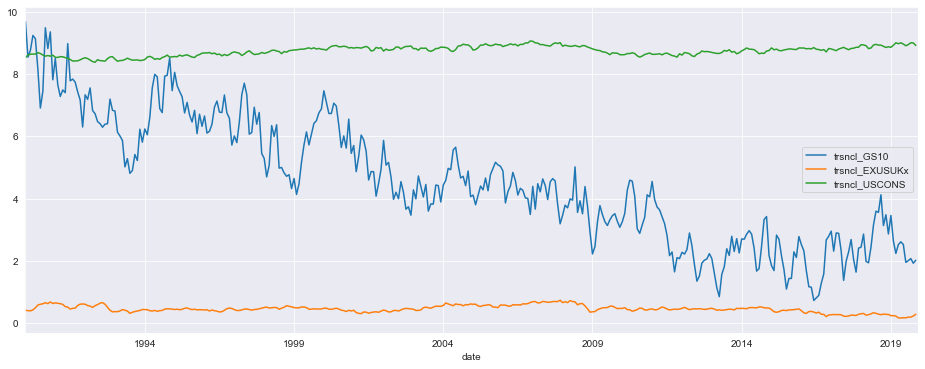

In [518]:
df['trsncl_GS10'].plot()
df['trsncl_EXUSUKx'].plot()
df['trsncl_USCONS'].plot()
plt.legend()
plt.show()

#### Additive Decomposition

In [519]:
ts_dicomposition_GS10 = seasonal_decompose(x= df['GS10'], model='additive', period=12)

trend_estimate_GS10 = ts_dicomposition_GS10.trend
seasonal_estimate_GS10 = ts_dicomposition_GS10.seasonal
residual_estimate_GS10 = ts_dicomposition_GS10.resid

In [520]:
df['trsn_GS10_additive'] = trend_estimate_GS10 + seasonal_estimate_GS10

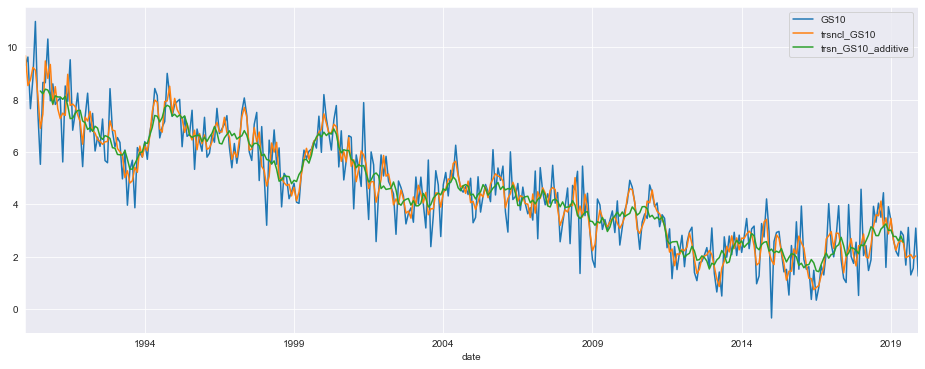

In [521]:
df['GS10'].plot()
df['trsncl_GS10'].plot()
df['trsn_GS10_additive'].plot()
plt.legend()
plt.show()

In [522]:
ts_dicomposition_EXUSUKx = seasonal_decompose(x= df['EXUSUKx'], model='additive', period=12)

trend_estimate_EXUSUKx = ts_dicomposition_EXUSUKx.trend
seasonal_estimate_EXUSUKx = ts_dicomposition_EXUSUKx.seasonal
residual_estimate_EXUSUKx = ts_dicomposition_EXUSUKx.resid

In [523]:
df['trsn_EXUSUKx_additive'] = trend_estimate_EXUSUKx + seasonal_estimate_EXUSUKx

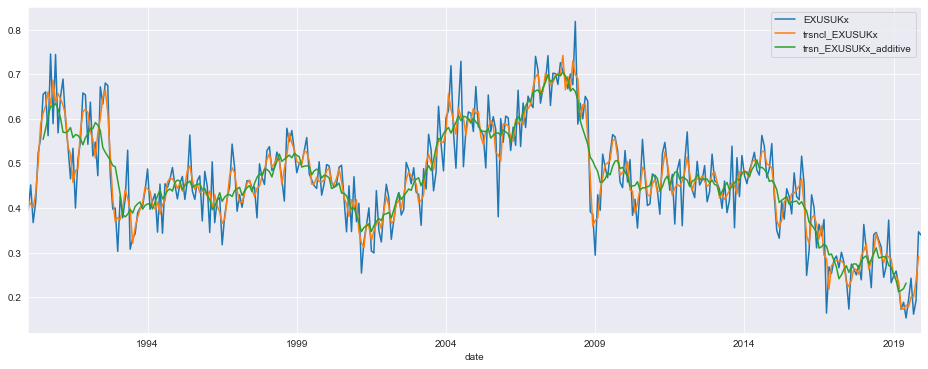

In [524]:
df['EXUSUKx'].plot()
df['trsncl_EXUSUKx'].plot()
df['trsn_EXUSUKx_additive'].plot()
plt.legend()
plt.show()

In [525]:
ts_dicomposition_USCONS = seasonal_decompose(x= df['USCONS'], model='additive', period=12)

trend_estimate_USCONS = ts_dicomposition_USCONS.trend
seasonal_estimate_USCONS = ts_dicomposition_USCONS.seasonal
residual_estimate_USCONS = ts_dicomposition_USCONS.resid

In [526]:
df['trsn_USCONS_additive'] = trend_estimate_USCONS + seasonal_estimate_USCONS

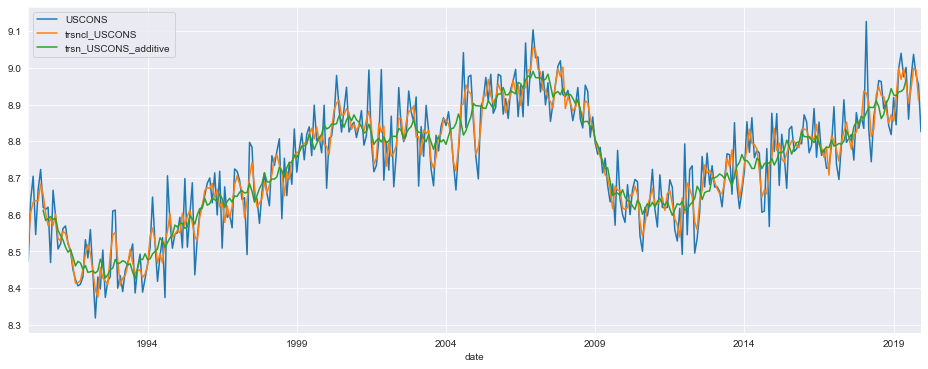

In [527]:
df['USCONS'].plot()
df['trsncl_USCONS'].plot()
df['trsn_USCONS_additive'].plot()
plt.legend()
plt.show()

## Exponential Smoothing Methods (Holt-Winters & Gardner-McKenzie)

In [528]:
# adding one to remove negative value from series, will remove 1 from final forecast estimates as necessary
# you can see that the mean is scaled up by one and std remains constant
df['GS10_plus1'] = df['GS10'] + 1 

In [529]:
df['GS10'].mean()

4.553710670711117

In [530]:
df['GS10_plus1'].mean()

5.553710670711113

In [531]:
df['GS10'].std()

2.133936372412775

In [532]:
df['GS10_plus1'].std()

2.133936372412776

###### GS10 Holt-Winter & Gardner-McKenzie  Smoothing

In [533]:
model_Holt_GS10 = ExponentialSmoothing(np.asarray(df['GS10']), trend='add', seasonal=None, initialization_method="estimated") 
model_GM_GS10 = ExponentialSmoothing(np.asarray(df['GS10']), trend='add', seasonal=None, damped_trend = True, initialization_method="estimated")
model_Holt_GS10._index = pd.to_datetime(df.index)
model_GM_GS10._index = pd.to_datetime(df.index)

fit_Holt_GS10 = model_Holt_GS10.fit()
fit_GM_GS10 = model_GM_GS10.fit()

In [534]:
model_Holt_GS10_plus1 = ExponentialSmoothing(np.asarray(df['GS10_plus1']), trend='mul', seasonal='mul', seasonal_periods=12, initialization_method="estimated") 
model_GM_GS10_plus1 = ExponentialSmoothing(np.asarray(df['GS10_plus1']), trend='mul', seasonal='mul', seasonal_periods=12, damped_trend = True, initialization_method="estimated")
model_Holt_GS10_plus1._index = pd.to_datetime(df.index)
model_GM_GS10_plus1._index = pd.to_datetime(df.index)

fit_Holt_GS10_plus1 = model_Holt_GS10_plus1.fit()
fit_GM_GS10_plus1 = model_GM_GS10_plus1.fit()

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


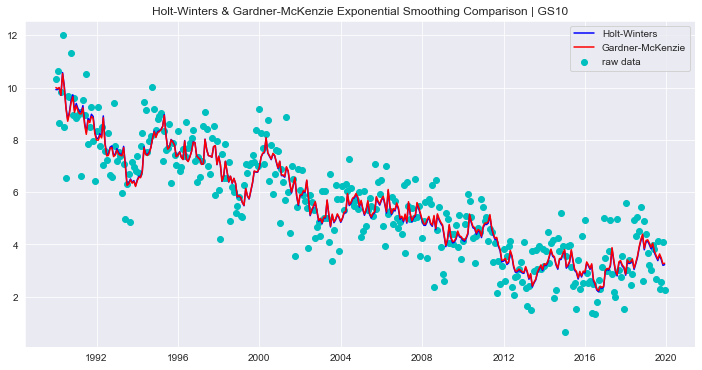

In [535]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(df.index, df.GS10_plus1, c='c', label='raw data')
ax.plot(df.index, fit_Holt_GS10_plus1.fittedvalues, color='b', label="Holt-Winters")
ax.plot(df.index, fit_GM_GS10_plus1.fittedvalues, color='r', label="Gardner-McKenzie")

plt.title("Holt-Winters & Gardner-McKenzie Exponential Smoothing Comparison | GS10") 
plt.legend()

###### EXUSUKx Holt-Winter & Gardner-McKenzie  Smoothing

In [536]:
model_Holt_EXUSUKx = ExponentialSmoothing(np.asarray(df['EXUSUKx']), trend='mul', seasonal=None, initialization_method="estimated") 
model_GM_EXUSUKx = ExponentialSmoothing(np.asarray(df['EXUSUKx']), trend='mul', seasonal=None, damped_trend = True, initialization_method="estimated")
model_Holt_EXUSUKx._index = pd.to_datetime(df.index)
model_GM_EXUSUKx._index = pd.to_datetime(df.index)

fit_Holt_EXUSUKx = model_Holt_EXUSUKx.fit()
fit_GM_EXUSUKx = model_GM_EXUSUKx.fit()

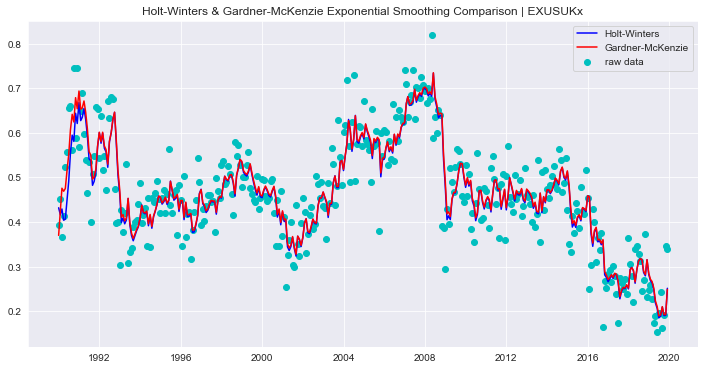

In [537]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(df.index, df.EXUSUKx, c='c', label='raw data')
ax.plot(df.index, fit_Holt_EXUSUKx.fittedvalues, color='b', label="Holt-Winters")
ax.plot(df.index, fit_GM_EXUSUKx.fittedvalues, color='r', label="Gardner-McKenzie")

plt.title("Holt-Winters & Gardner-McKenzie Exponential Smoothing Comparison | EXUSUKx") 
plt.legend()

###### USCONS Holt-Winter & Gardner-McKenzie  Smoothing

In [538]:
model_Holt_USCONS = ExponentialSmoothing(np.asarray(df['USCONS']), trend='mul', seasonal=None, initialization_method="estimated") 
model_GM_USCONS = ExponentialSmoothing(np.asarray(df['USCONS']), trend='mul', seasonal=None, damped_trend = True, initialization_method="estimated")
model_Holt_USCONS._index = pd.to_datetime(df.index)
model_GM_USCONS._index = pd.to_datetime(df.index)

fit_Holt_USCONS = model_Holt_USCONS.fit()
fit_GM_USCONS = model_GM_USCONS.fit()

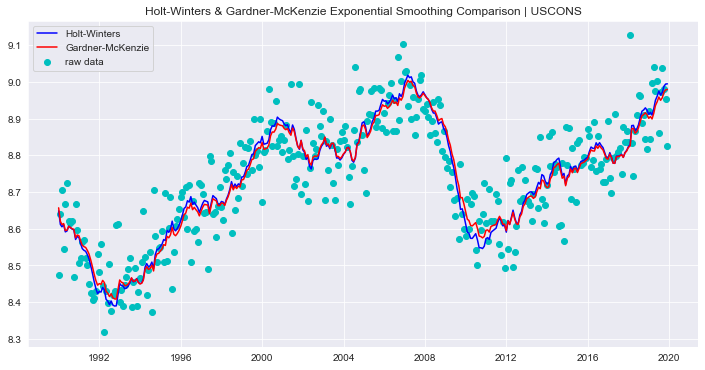

In [539]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(df.index, df.USCONS, c='c', label='raw data')
ax.plot(df.index, fit_Holt_USCONS.fittedvalues, color='b', label="Holt-Winters")
ax.plot(df.index, fit_GM_USCONS.fittedvalues, color='r', label="Gardner-McKenzie")

plt.title("Holt-Winters & Gardner-McKenzie Exponential Smoothing Comparison | USCONS") 
plt.legend()

###### Summarise Each Series Into a Dataframe

In [540]:
### Gardner-McKenzie first
smoothed_df_gm = pd.DataFrame({'Damped GS10': fit_GM_GS10.fittedvalues, 
                            'Damped EXUSUKx': fit_GM_EXUSUKx.fittedvalues, 
                            'Damped USCONS': fit_GM_USCONS.fittedvalues })

In [541]:
smoothed_df_gm['date'] = pd.date_range(start='01-JAN-1990', end='01-DEC-2019', freq='MS')

In [542]:
smoothed_df_gm = smoothed_df_gm.set_index('date')

In [543]:
smoothed_df_gm.head()

Damped GS10  Damped EXUSUKx  Damped USCONS
date                                                  
1990-01-01     8.927465        0.370019       8.657084
1990-02-01     8.959160        0.424318       8.620461
1990-03-01     9.046786        0.475675       8.611505
1990-04-01     8.722643        0.468841       8.614190
1990-05-01     8.694361        0.475082       8.595254

In [544]:
### Holt-Winters Second
smoothed_df_holt = pd.DataFrame({'Holt-Winters GS10': fit_Holt_GS10.fittedvalues, 
                            'Holt-Winters EXUSUKx': fit_Holt_EXUSUKx.fittedvalues, 
                            'Holt-Winters USCONS': fit_Holt_USCONS.fittedvalues })

In [545]:
smoothed_df_holt['date'] = pd.date_range(start='01-JAN-1990', end='01-DEC-2019', freq='MS')

In [546]:
smoothed_df_holt = smoothed_df_holt.set_index('date')

###### Checking for Outliers

In [547]:
df['z_data_GS10'] = (df['GS10'] - df.GS10.rolling(window=4).mean()) / df.GS10.rolling(window=12).std()
df['zp_dataGS10'] = df['z_data_GS10'] - df['z_data_GS10'].shift(1)

In [548]:
df.zp_dataGS10[(df.zp_dataGS10 > np.mean(df.zp_dataGS10) + 3*np.std(df.zp_dataGS10))].count()

0

In [549]:
df['z_data_EXUSUKx'] = (df['EXUSUKx'] - df.EXUSUKx.rolling(window=4).mean()) / df.EXUSUKx.rolling(window=12).std()
df['zp_data_EXUSUKx'] = df['z_data_EXUSUKx'] - df['z_data_EXUSUKx'].shift(1)

In [550]:
df.zp_data_EXUSUKx[(df.zp_data_EXUSUKx > np.mean(df.zp_data_EXUSUKx) + 3*np.std(df.zp_data_EXUSUKx))].count()

0

In [551]:
df['z_data_USCONS'] = (df['USCONS'] - df.USCONS.rolling(window=4).mean()) / df.USCONS.rolling(window=12).std()
df['zp_data_USCONS'] = df['z_data_USCONS'] - df['z_data_USCONS'].shift(1)

In [552]:
df.zp_data_USCONS[(df.zp_data_USCONS > np.mean(df.zp_data_USCONS) + 3*np.std(df.zp_data_USCONS))].count()

0

In [553]:
df[['GS10']].nlargest(15, ['GS10'])

GS10
date                 
1990-05-01  10.992067
1990-10-01  10.320546
1990-02-01   9.632165
1991-07-01   9.527959
1990-01-01   9.322005
1994-10-01   9.006712
1990-04-01   8.812280
1990-08-01   8.659284
1990-09-01   8.652089
1990-12-01   8.606121
1991-05-01   8.525581
1994-05-01   8.428667
1992-11-01   8.422404
1991-10-01   8.252222
1992-02-01   8.249134

In [554]:
df['GS10'].mean()+3*df['GS10'].std()

10.955519787949441

In [555]:
df['GS10'].mean()-3*df['GS10'].std()

-1.8480984465272092

###### only 1990-05-01 is an outlier beyond 3 standard deviations. But when we detrend and difference the data there are no outliers which is what the code above proves. Thus we do not need to remove any periods from the data.

### Testing for Stationarity 

We use the Augmented Dicky Fuller Test to test for stationarity

In [556]:
X = df['GS10'].values

### ADF lag
result1=adfuller(X,regression='ct',maxlag=3,regresults=True,store=True)
out = ' ADF statistic: {0:0.3f}, \n p-value: {1:0.3f}, \n critical value: {2}'
print(out.format(result1[0], result1[1], result1[2]))

### ADF BIC
result=adfuller(X,regression='ct',autolag='BIC',regresults=True,store=True)
out = ' ADF statistic: {0:0.3f}, \n p-value: {1:0.3f}, \n critical value: {2}'
print(out.format(result[0], result[1], result[2]))

 ADF statistic: -5.811, 
 p-value: 0.000, 
 critical value: {'1%': -3.9844273384033553, '5%': -3.4228948877592487, '10%': -3.1343443872709296}
 ADF statistic: -6.788, 
 p-value: 0.000, 
 critical value: {'1%': -3.9843548259642185, '5%': -3.4228599354097655, '10%': -3.1343238655389656}


In [557]:
X = df['EXUSUKx'].values

### ADF lag
result1=adfuller(X,regression='ct',maxlag=3,regresults=True,store=True)
out = ' ADF statistic: {0:0.3f}, \n p-value: {1:0.3f}, \n critical value: {2}'
print(out.format(result1[0], result1[1], result1[2]))

### ADF BIC
result=adfuller(X,regression='ct',autolag='BIC',regresults=True,store=True)
out = ' ADF statistic: {0:0.3f}, \n p-value: {1:0.3f}, \n critical value: {2}'
print(out.format(result[0], result[1], result[2]))

 ADF statistic: -3.254, 
 p-value: 0.074, 
 critical value: {'1%': -3.9844273384033553, '5%': -3.4228948877592487, '10%': -3.1343443872709296}
 ADF statistic: -3.254, 
 p-value: 0.074, 
 critical value: {'1%': -3.9844273384033553, '5%': -3.4228948877592487, '10%': -3.1343443872709296}


In [558]:
X = df['USCONS'].values

### ADF lag
result1=adfuller(X,regression='ct',maxlag=3,regresults=True,store=True)
out = ' ADF statistic: {0:0.3f}, \n p-value: {1:0.3f}, \n critical value: {2}'
print(out.format(result1[0], result1[1], result1[2]))

### ADF BIC
result=adfuller(X,regression='ct',autolag='BIC',regresults=True,store=True)
out = ' ADF statistic: {0:0.3f}, \n p-value: {1:0.3f}, \n critical value: {2}'
print(out.format(result[0], result[1], result[2]))

 ADF statistic: -2.945, 
 p-value: 0.148, 
 critical value: {'1%': -3.9844273384033553, '5%': -3.4228948877592487, '10%': -3.1343443872709296}
 ADF statistic: -1.753, 
 p-value: 0.727, 
 critical value: {'1%': -3.9846473631318196, '5%': -3.423000940126665, '10%': -3.134406653206698}


 From the tests above we can see that only GS10 is stationary. However from its graph above it is clear that there is a trend, thus differencing GS10 should help control for this trend.

#### First-Difference Test

In [559]:
df['GS10_D1'] = df['GS10'].diff()
df['EXUSUKx_D1'] = df['EXUSUKx'].diff()
df['USCONS_D1'] = df['USCONS'].diff()

In [560]:
df = df.dropna(axis = 0)

In [561]:
X = df['GS10_D1'].values

### ADF lag
result1=adfuller(X,regression='ct',maxlag=3,regresults=True,store=True)
out = ' ADF statistic: {0:0.3f}, \n p-value: {1:0.3f}, \n critical value: {2}'
print(out.format(result1[0], result1[1], result1[2]))

### ADF BIC
result=adfuller(X,regression='ct',autolag='BIC',regresults=True,store=True)
out = ' ADF statistic: {0:0.3f}, \n p-value: {1:0.3f}, \n critical value: {2}'
print(out.format(result[0], result[1], result[2]))

 ADF statistic: -14.926, 
 p-value: 0.000, 
 critical value: {'1%': -3.985806629567277, '5%': -3.423559618033363, '10%': -3.1347346400075082}
 ADF statistic: -14.926, 
 p-value: 0.000, 
 critical value: {'1%': -3.985806629567277, '5%': -3.423559618033363, '10%': -3.1347346400075082}


In [562]:
X = df['EXUSUKx_D1'].values

### ADF lag
result1=adfuller(X,regression='ct',maxlag=3,regresults=True,store=True)
out = ' ADF statistic: {0:0.3f}, \n p-value: {1:0.3f}, \n critical value: {2}'
print(out.format(result1[0], result1[1], result1[2]))

### ADF BIC
result=adfuller(X,regression='ct',autolag='BIC',regresults=True,store=True)
out = ' ADF statistic: {0:0.3f}, \n p-value: {1:0.3f}, \n critical value: {2}'
print(out.format(result[0], result[1], result[2]))

 ADF statistic: -13.786, 
 p-value: 0.000, 
 critical value: {'1%': -3.985806629567277, '5%': -3.423559618033363, '10%': -3.1347346400075082}
 ADF statistic: -13.786, 
 p-value: 0.000, 
 critical value: {'1%': -3.985806629567277, '5%': -3.423559618033363, '10%': -3.1347346400075082}


In [563]:
X = df['USCONS_D1'].values

### ADF lag
result1=adfuller(X,regression='ct',maxlag=3,regresults=True,store=True)
out = ' ADF statistic: {0:0.3f}, \n p-value: {1:0.3f}, \n critical value: {2}'
print(out.format(result1[0], result1[1], result1[2]))

### ADF BIC
result=adfuller(X,regression='ct',autolag='BIC',regresults=True,store=True)
out = ' ADF statistic: {0:0.3f}, \n p-value: {1:0.3f}, \n critical value: {2}'
print(out.format(result[0], result[1], result[2]))

 ADF statistic: -14.617, 
 p-value: 0.000, 
 critical value: {'1%': -3.985806629567277, '5%': -3.423559618033363, '10%': -3.1347346400075082}
 ADF statistic: -11.497, 
 p-value: 0.000, 
 critical value: {'1%': -3.98613352201295, '5%': -3.4237171276336493, '10%': -3.134827102136936}


 From the tests above we can see that all series are now stationary after first differencing

### Finalised Clean Data For Analysis

 For our finalised data we have checked for outliers and there are none so we do not have to remove any observations. We will also include the first lag in each series

In [564]:
df = pd.read_csv("data.csv")

In [565]:
df['date'] = pd.date_range(start='01-JAN-1990', end='01-DEC-2019', freq='MS')

In [566]:
df = df.set_index('date')

In [567]:
df['GS10_D1'] = df['GS10'].diff()
df['EXUSUKx_D1'] = df['EXUSUKx'].diff()
df['USCONS_D1'] = df['USCONS'].diff()

In [568]:
df = df.dropna(axis = 0)

In [569]:
train_clean = df[['Unnamed: 0', 'GS10_D1', 'EXUSUKx_D1', 'USCONS_D1']]

In [570]:
train = train_clean[train_clean['Unnamed: 0']<=723]

In [571]:
train = train[[ 'GS10_D1', 'EXUSUKx_D1', 'USCONS_D1']]

In [572]:
train.tail()

GS10_D1  EXUSUKx_D1  USCONS_D1
date                                       
2018-10-01  0.936511    0.024618   0.020495
2018-11-01 -2.855735    0.103687  -0.065843
2018-12-01  2.321612   -0.140526  -0.025421
2019-01-01 -0.523467    0.015182   0.101494
2019-02-01 -0.720049    0.010978  -0.074715

In [573]:
test_clean = df[['Unnamed: 0', 'GS10_D1', 'EXUSUKx_D1', 'USCONS_D1']]

In [574]:
test = train_clean[(train_clean['Unnamed: 0']>723) & (train_clean['Unnamed: 0']<=733)]

In [575]:
test = test[[ 'GS10_D1', 'EXUSUKx_D1', 'USCONS_D1']]

In [576]:
test.tail(12)

GS10_D1  EXUSUKx_D1  USCONS_D1
date                                       
2019-03-01 -0.450467   -0.032163   0.151846
2019-04-01 -0.192684   -0.053775   0.043019
2019-05-01  0.946796    0.016160  -0.064060
2019-06-01 -0.155158   -0.035403   0.025544
2019-07-01 -1.139198    0.041491  -0.141232
2019-08-01  1.442131    0.047577   0.112813
2019-09-01 -1.817491   -0.080614   0.063893
2019-10-01  0.258735    0.030519  -0.055952
2019-11-01  1.532773    0.154341  -0.026901
2019-12-01 -1.837412   -0.007367  -0.127823

###### Plot of Training and Test Set

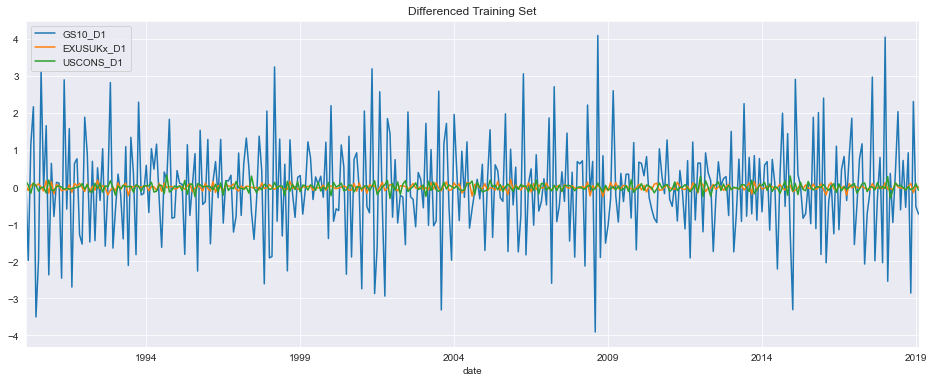

In [577]:
train[['GS10_D1', 'EXUSUKx_D1', 'USCONS_D1']].plot()
plt.title("Differenced Training Set")
plt.legend()
plt.show()

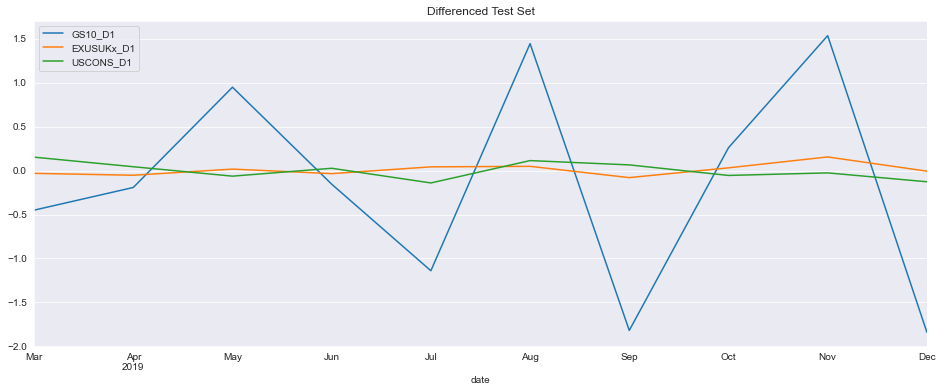

In [578]:
test[['GS10_D1', 'EXUSUKx_D1', 'USCONS_D1']].plot()
plt.title("Differenced Test Set")
plt.legend()
plt.show()

## Creating test and training sets

In [579]:
test_ARIMA = df[['Unnamed: 0', 'GS10', 'EXUSUKx', 'USCONS']]

In [580]:
test_ARIMA = test_ARIMA[(test_ARIMA['Unnamed: 0']>722) & (test_ARIMA['Unnamed: 0']<=733)]

In [581]:
test_ARIMA.tail(12)

Unnamed: 0      GS10   EXUSUKx    USCONS
date                                                
2019-02-01         723  2.664951  0.258564  8.845101
2019-03-01         724  2.214484  0.226401  8.996948
2019-04-01         725  2.021801  0.172626  9.039967
2019-05-01         726  2.968596  0.188786  8.975907
2019-06-01         727  2.813438  0.153383  9.001451
2019-07-01         728  1.674241  0.194873  8.860219
2019-08-01         729  3.116371  0.242450  8.973032
2019-09-01         730  1.298880  0.161836  9.036925
2019-10-01         731  1.557615  0.192354  8.980973
2019-11-01         732  3.090388  0.346695  8.954072
2019-12-01         733  1.252976  0.339328  8.826249

In [582]:
train_ARIMA = df[['Unnamed: 0', 'GS10', 'EXUSUKx', 'USCONS']]

In [583]:
train_ARIMA = train_ARIMA[train_ARIMA['Unnamed: 0']<=723]

In [584]:
train_ARIMA.tail(12)

Unnamed: 0      GS10   EXUSUKx    USCONS
date                                                
2018-03-01         712  2.415683  0.279857  8.833242
2018-04-01         713  1.467380  0.221310  8.744371
2018-05-01         714  1.876599  0.340231  8.866361
2018-06-01         715  3.922333  0.345124  8.910720
2018-07-01         716  3.316183  0.327772  8.965634
2018-08-01         717  4.044453  0.312597  8.962813
2018-09-01         718  3.506078  0.244626  8.889092
2018-10-01         719  4.442589  0.269244  8.909587
2018-11-01         720  1.586854  0.372931  8.843744
2018-12-01         721  3.908466  0.232405  8.818322
2019-01-01         722  3.385000  0.247586  8.919816
2019-02-01         723  2.664951  0.258564  8.845101

# ARIMA 

For each series: 
- We use ACF and PACF plots to get a visual indication of the number of lags to include. We then use a for loop to print the best fitting model on basis of BIC
- We then use the Ljung-Box Test and conduct other model diagnostics to determine if residuals are white noise 

### GS10:

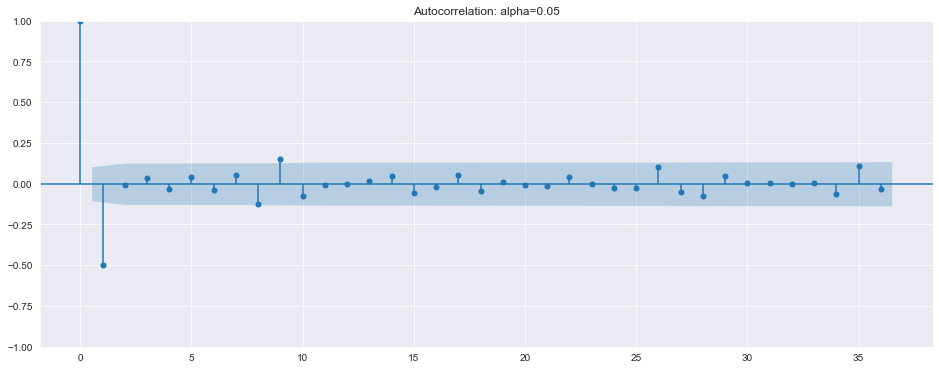

In [585]:
sm.graphics.tsa.plot_acf(train['GS10_D1'].values.squeeze(), lags=36, alpha=0.05, title='Autocorrelation: alpha=0.05')
plt.show()

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


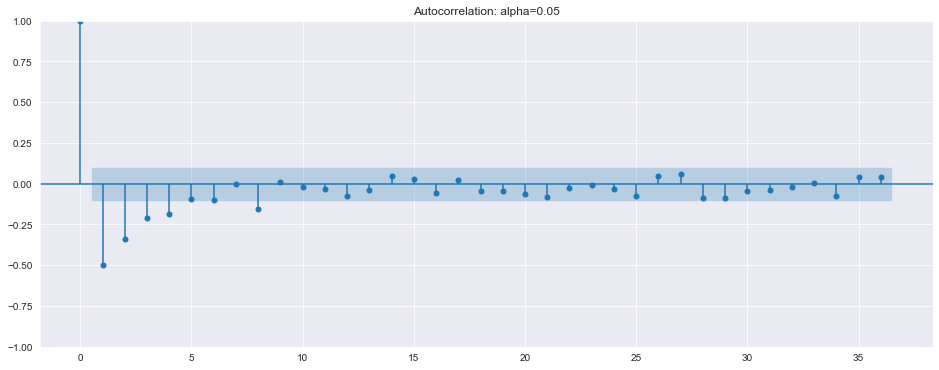

In [586]:
sm.graphics.tsa.plot_pacf(train['GS10_D1'].values.squeeze(), lags=36, alpha=0.05, title='Autocorrelation: alpha=0.05')
plt.show()

In [587]:
ARv=[0,1,2,3,4,5,6,7,8]
MAv=[0,1]

Combinations=[]

for x in ARv:
  for y in MAv:
    comb=(x,0,y)
    Combinations.append(comb)

results_list=[]

for i, z in enumerate(Combinations):
      mod = ARIMA(train['GS10_D1'], order=z)
      Combinations[i] = mod.fit()
      results_list.append(Combinations[i])
      print(results_list[i].summary())

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:                GS10_D1   No. Observations:                  349
Model:                          ARIMA   Log Likelihood                -602.531
Date:                Mon, 24 Oct 2022   AIC                           1209.062
Time:                        14:00:59   BIC                           1216.772
Sample:                    02-01-1990   HQIC                          1212.131
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0191      0.073     -0.262      0.794      -0.162       0.124
sigma2         1.8497      0.137     13.466      0.000       1.580       2.119
Ljung-Box (L1) (Q):                  87.25   Jarque-

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:                GS10_D1   No. Observations:                  349
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -514.312
Date:                Mon, 24 Oct 2022   AIC                           1036.624
Time:                        14:00:59   BIC                           1052.045
Sample:                    02-01-1990   HQIC                          1042.763
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0166      0.013     -1.313      0.189      -0.041       0.008
ar.L1         -0.0347      0.072     -0.484      0.629      -0.175       0.106
ma.L1         -0.7771      0.046    -16.784      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                GS10_D1   No. Observations:                  349
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -514.265
Date:                Mon, 24 Oct 2022   AIC                           1038.530
Time:                        14:01:00   BIC                           1057.805
Sample:                    02-01-1990   HQIC                          1046.203
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0166      0.013     -1.270      0.204      -0.042       0.009
ar.L1         -0.0492      0.082     -0.601      0.548      -0.210       0.111
ar.L2         -0.0228      0.069     -0.333      0.7

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:                GS10_D1   No. Observations:                  349
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -514.127
Date:                Mon, 24 Oct 2022   AIC                           1040.253
Time:                        14:01:00   BIC                           1063.384
Sample:                    02-01-1990   HQIC                          1049.461
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0166      0.012     -1.341      0.180      -0.041       0.008
ar.L1         -0.0108      0.091     -0.118      0.906      -0.190       0.168
ar.L2          0.0087      0.080      0.109      0.9

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

                               SARIMAX Results                                
Dep. Variable:                GS10_D1   No. Observations:                  349
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -511.723
Date:                Mon, 24 Oct 2022   AIC                           1037.446
Time:                        14:01:00   BIC                           1064.431
Sample:                    02-01-1990   HQIC                          1048.188
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0177      0.003     -7.022      0.000      -0.023      -0.013
ar.L1          0.1673      0.059      2.855      0.004       0.052       0.282
ar.L2          0.1600      0.055      2.916      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

                               SARIMAX Results                                
Dep. Variable:                GS10_D1   No. Observations:                  349
Model:                 ARIMA(5, 0, 1)   Log Likelihood                -509.976
Date:                Mon, 24 Oct 2022   AIC                           1035.952
Time:                        14:01:01   BIC                           1066.792
Sample:                    02-01-1990   HQIC                          1048.229
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0177      0.003     -5.769      0.000      -0.024      -0.012
ar.L1          0.1612      0.059      2.751      0.006       0.046       0.276
ar.L2          0.1455      0.056      2.596      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                GS10_D1   No. Observations:                  349
Model:                 ARIMA(6, 0, 1)   Log Likelihood                -509.833
Date:                Mon, 24 Oct 2022   AIC                           1037.666
Time:                        14:01:02   BIC                           1072.361
Sample:                    02-01-1990   HQIC                          1051.477
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0177      0.003     -5.524      0.000      -0.024      -0.011
ar.L1          0.1566      0.059      2.663      0.008       0.041       0.272
ar.L2          0.1431      0.056      2.553      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

                               SARIMAX Results                                
Dep. Variable:                GS10_D1   No. Observations:                  349
Model:                 ARIMA(7, 0, 1)   Log Likelihood                -509.530
Date:                Mon, 24 Oct 2022   AIC                           1039.059
Time:                        14:01:03   BIC                           1077.610
Sample:                    02-01-1990   HQIC                          1054.405
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0177      0.004     -5.010      0.000      -0.025      -0.011
ar.L1          0.1494      0.060      2.507      0.012       0.033       0.266
ar.L2          0.1397      0.056      2.473      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                GS10_D1   No. Observations:                  349
Model:                 ARIMA(8, 0, 1)   Log Likelihood                -511.336
Date:                Mon, 24 Oct 2022   AIC                           1044.673
Time:                        14:01:03   BIC                           1087.078
Sample:                    02-01-1990   HQIC                          1061.553
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0164      0.015     -1.069      0.285      -0.046       0.014
ar.L1         -0.9251      0.355     -2.608      0.009      -1.620      -0.230
ar.L2         -0.7322      0.287     -2.548      0.0

In [588]:
Results=summary_col(Combinations, stars=True, float_format='%0.2f')
print(Results)


       GS10_D1 I GS10_D1 II GS10_D1 III GS10_D1 IIII GS10_D1 IIIII GS10_D1 IIIIII GS10_D1 IIIIIII GS10_D1 IIIIIIII GS10_D1 IIIIIIIII GS10_D1 IIIIIIIIII GS10_D1 IIIIIIIIIII GS10_D1 IIIIIIIIIIII GS10_D1 IIIIIIIIIIIII GS10_D1 IIIIIIIIIIIIII GS10_D1 IIIIIIIIIIIIIII GS10_D1 IIIIIIIIIIIIIIII GS10_D1 IIIIIIIIIIIIIIIII GS10_D1 IIIIIIIIIIIIIIIIII
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ar.L1                       -0.50***    -0.03        -0.67***      -0.05          -0.73***        -0.01            -0.77***          0.17***            -0.79***            0.16***              -0.80***              0.16***                -0.80***                0.15**                   -0.80***                  -0.93*

###### from BIC we can see the best order is (0,0,1)

In [589]:
arima_GS10 = ARIMA(train['GS10_D1'], order=(0,0,1))
arima_GS10_result = arima_GS10.fit() 
print(arima_GS10_result.summary())

                               SARIMAX Results                                
Dep. Variable:                GS10_D1   No. Observations:                  349
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -514.434
Date:                Mon, 24 Oct 2022   AIC                           1034.869
Time:                        14:01:04   BIC                           1046.434
Sample:                    02-01-1990   HQIC                          1039.473
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0166      0.012     -1.363      0.173      -0.040       0.007
ma.L1         -0.7918      0.035    -22.434      0.000      -0.861      -0.723
sigma2         1.1133      0.081     13.712      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [590]:
arima_GS10_D1_fc = arima_GS10_result.forecast(steps = 10)
arima_GS10_D1_fc


2019-03-01    0.361111
2019-04-01   -0.016577
2019-05-01   -0.016577
2019-06-01   -0.016577
2019-07-01   -0.016577
2019-08-01   -0.016577
2019-09-01   -0.016577
2019-10-01   -0.016577
2019-11-01   -0.016577
2019-12-01   -0.016577
Freq: MS, Name: predicted_mean, dtype: float64

In [591]:
CS_arima_GS10_D1_fc=np.cumsum(arima_GS10_D1_fc)+2.664951

In [592]:
df_GS10_forecast_test=pd.DataFrame(arima_GS10_D1_fc, index=df.index[-10:])
print(df_GS10_forecast_test)

            predicted_mean
date                      
2019-03-01        0.361111
2019-04-01       -0.016577
2019-05-01       -0.016577
2019-06-01       -0.016577
2019-07-01       -0.016577
2019-08-01       -0.016577
2019-09-01       -0.016577
2019-10-01       -0.016577
2019-11-01       -0.016577
2019-12-01       -0.016577


In [593]:
CS_df_GS10_forecast_test=pd.DataFrame(CS_arima_GS10_D1_fc, index=df.index[-10:])
print(CS_df_GS10_forecast_test)

            predicted_mean
date                      
2019-03-01        3.026062
2019-04-01        3.009485
2019-05-01        2.992907
2019-06-01        2.976330
2019-07-01        2.959752
2019-08-01        2.943175
2019-09-01        2.926597
2019-10-01        2.910020
2019-11-01        2.893442
2019-12-01        2.876865


In [594]:
### Bring forecast to level
df_GS10_forecast_level_test = CS_df_GS10_forecast_test['predicted_mean'] 

In [595]:
df.tail(12)

Unnamed: 0      GS10   EXUSUKx    USCONS   GS10_D1  EXUSUKx_D1  \
date                                                                         
2019-01-01         722  3.385000  0.247586  8.919816 -0.523467    0.015182   
2019-02-01         723  2.664951  0.258564  8.845101 -0.720049    0.010978   
2019-03-01         724  2.214484  0.226401  8.996948 -0.450467   -0.032163   
2019-04-01         725  2.021801  0.172626  9.039967 -0.192684   -0.053775   
2019-05-01         726  2.968596  0.188786  8.975907  0.946796    0.016160   
2019-06-01         727  2.813438  0.153383  9.001451 -0.155158   -0.035403   
2019-07-01         728  1.674241  0.194873  8.860219 -1.139198    0.041491   
2019-08-01         729  3.116371  0.242450  8.973032  1.442131    0.047577   
2019-09-01         730  1.298880  0.161836  9.036925 -1.817491   -0.080614   
2019-10-01         731  1.557615  0.192354  8.980973  0.258735    0.030519   
2019-11-01         732  3.090388  0.346695  8.954072  1.532773    0.154341   
2019-12-01         733  1.252976  0.339328  8.826249 -1.837412   -0.007367   

            USCONS_D1  
date                   
2019-01-01   0.101494  
2019-02-01  -0.074715  
2019-03-01   0.151846  
2019-04-01   0.043019  
2019-05-01  -0.064060  
2019-06-01   0.025544  
2019-07-01  -0.141232  
2019-08-01   0.112813  
2019-09-01   0.063893  
2019-10-01  -0.055952  
2019-11-01  -0.026901  
2019-12-01  -0.127823

In [596]:
df_GS10_forecast_level_test.head(10)

date
2019-03-01    3.026062
2019-04-01    3.009485
2019-05-01    2.992907
2019-06-01    2.976330
2019-07-01    2.959752
2019-08-01    2.943175
2019-09-01    2.926597
2019-10-01    2.910020
2019-11-01    2.893442
2019-12-01    2.876865
Name: predicted_mean, dtype: float64

In [597]:
fitted_values_arima_GS10_D1 = arima_GS10_result.predict()

In [598]:
fitted_values_arima_GS10 = fitted_values_arima_GS10_D1.shift(1) + train_ARIMA['GS10'].shift(1)

In [599]:
fitted_values_arima_GS10.head()

1990-02-01          NaN
1990-03-01     9.615587
1990-04-01     7.481142
1990-05-01     9.943528
1990-06-01    10.958344
Freq: MS, dtype: float64

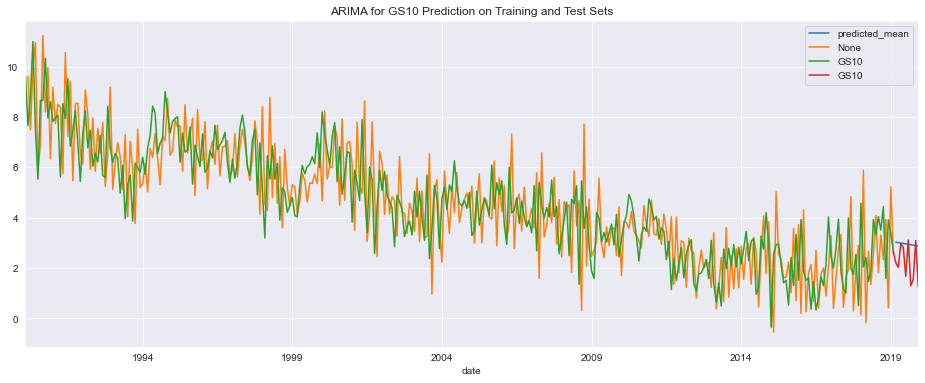

In [600]:
df_GS10_forecast_level_test.plot()
fitted_values_arima_GS10.plot()
train_ARIMA['GS10'].plot()
test_ARIMA['GS10'].plot()
plt.title('ARIMA for GS10 Prediction on Training and Test Sets')
plt.legend()
plt.show()

Text(0.5, 1.0, 'ARIMA for GS10_D1 Prediction on Training and Test Sets')

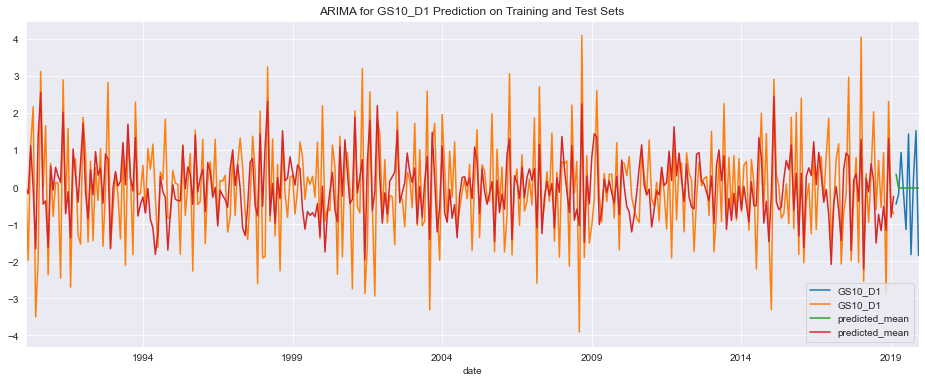

In [601]:
test['GS10_D1'].plot()
train['GS10_D1'].plot()
arima_GS10_D1_fc.plot() 
fitted_values_arima_GS10_D1.plot()
plt.legend()
plt.title('ARIMA for GS10_D1 Prediction on Training and Test Sets')

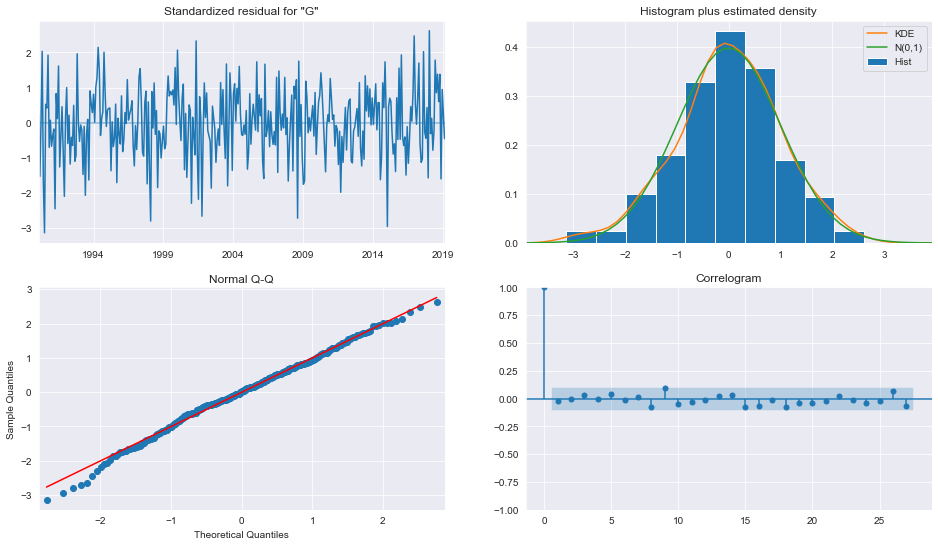

In [602]:
fig = plt.figure(figsize=(16,9))
fig = arima_GS10_result.plot_diagnostics(fig=fig, lags=27)

In [603]:
sm.stats.acorr_ljungbox(arima_GS10_result.resid, lags=[math.log(360)], return_df=True)

lb_stat  lb_pvalue
5  1.106286   0.953546

### EXUSUKx:

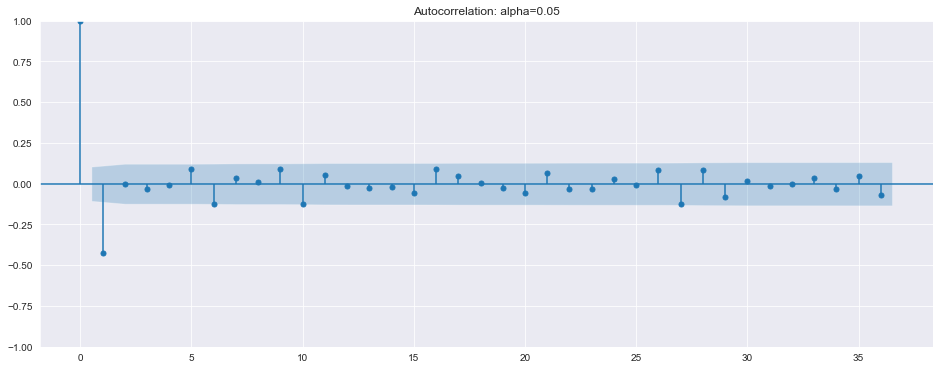

In [604]:
sm.graphics.tsa.plot_acf(train['EXUSUKx_D1'].values.squeeze(), lags=36, alpha=0.05, title='Autocorrelation: alpha=0.05')
plt.show()

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


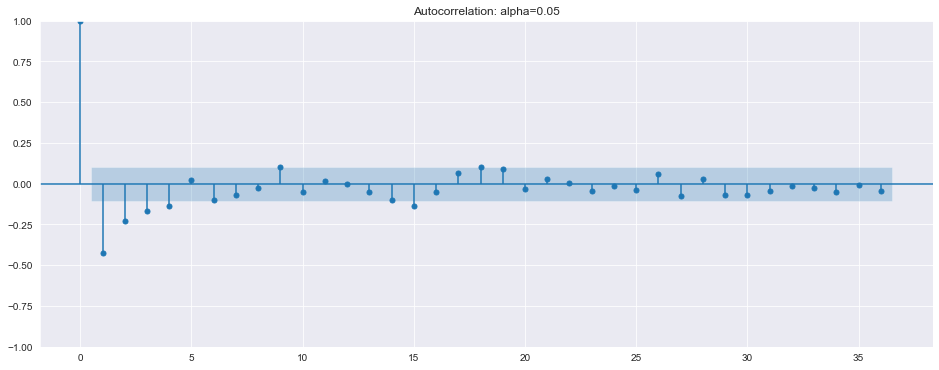

In [605]:
sm.graphics.tsa.plot_pacf(train['EXUSUKx_D1'].values.squeeze(), lags=36, alpha=0.05, title='Autocorrelation: alpha=0.05')
plt.show()

In [606]:
ARv=[0,1,2,3,4,5,6,7,8,9]
MAv=[0,1]

Combinations=[]

for x in ARv:
  for y in MAv:
    comb=(x,0,y)
    Combinations.append(comb)

results_list=[]

for i, z in enumerate(Combinations):
      mod = ARIMA(train['EXUSUKx_D1'], order=z)
      Combinations[i] = mod.fit()
      results_list.append(Combinations[i])
      print(results_list[i].summary())

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                          ARIMA   Log Likelihood                 385.064
Date:                Mon, 24 Oct 2022   AIC                           -766.129
Time:                        14:01:06   BIC                           -758.418
Sample:                    02-01-1990   HQIC                          -763.059
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.004     -0.091      0.928      -0.009       0.008
sigma2         0.0064      0.000     13.779      0.000       0.006       0.007
Ljung-Box (L1) (Q):                  63.67   Jarque-

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 419.841
Date:                Mon, 24 Oct 2022   AIC                           -833.683
Time:                        14:01:06   BIC                           -822.118
Sample:                    02-01-1990   HQIC                          -829.079
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.003     -0.162      0.871      -0.006       0.005
ar.L1         -0.4253      0.047     -8.998      0.000      -0.518      -0.333
sigma2         0.0053      0.000     13.912      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 437.214
Date:                Mon, 24 Oct 2022   AIC                           -864.428
Time:                        14:01:07   BIC                           -845.153
Sample:                    02-01-1990   HQIC                          -856.755
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.397      0.691      -0.003       0.002
ar.L1          0.1257      0.094      1.341      0.180      -0.058       0.309
ar.L2          0.0492      0.076      0.644      0.5

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 437.220
Date:                Mon, 24 Oct 2022   AIC                           -862.441
Time:                        14:01:07   BIC                           -839.310
Sample:                    02-01-1990   HQIC                          -853.233
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.386      0.699      -0.003       0.002
ar.L1          0.1096      0.126      0.872      0.383      -0.137       0.356
ar.L2          0.0399      0.088      0.455      0.6

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 437.287
Date:                Mon, 24 Oct 2022   AIC                           -860.573
Time:                        14:01:08   BIC                           -833.588
Sample:                    02-01-1990   HQIC                          -849.831
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.399      0.690      -0.003       0.002
ar.L1          0.2087      0.143      1.461      0.144      -0.071       0.489
ar.L2          0.0978      0.095      1.035      0.3

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

                               SARIMAX Results                                
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                 ARIMA(5, 0, 1)   Log Likelihood                 437.679
Date:                Mon, 24 Oct 2022   AIC                           -859.358
Time:                        14:01:09   BIC                           -828.517
Sample:                    02-01-1990   HQIC                          -847.081
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.461      0.645      -0.003       0.002
ar.L1          0.2590      0.179      1.446      0.148      -0.092       0.610
ar.L2          0.0949      0.111      0.858      0.3

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

                               SARIMAX Results                                
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                 ARIMA(6, 0, 1)   Log Likelihood                 439.531
Date:                Mon, 24 Oct 2022   AIC                           -861.063
Time:                        14:01:10   BIC                           -826.367
Sample:                    02-01-1990   HQIC                          -847.251
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.346      0.729      -0.003       0.002
ar.L1         -0.1794      0.339     -0.529      0.597      -0.844       0.486
ar.L2         -0.1366      0.210     -0.649      0.5

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

                               SARIMAX Results                                
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                 ARIMA(7, 0, 1)   Log Likelihood                 439.749
Date:                Mon, 24 Oct 2022   AIC                           -859.498
Time:                        14:01:11   BIC                           -820.947
Sample:                    02-01-1990   HQIC                          -844.152
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.386      0.700      -0.003       0.002
ar.L1         -0.3618      0.622     -0.582      0.561      -1.581       0.857
ar.L2         -0.2451      0.362     -0.678      0.4

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                 ARIMA(8, 0, 1)   Log Likelihood                 439.761
Date:                Mon, 24 Oct 2022   AIC                           -857.522
Time:                        14:01:12   BIC                           -815.116
Sample:                    02-01-1990   HQIC                          -840.641
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.350      0.726      -0.003       0.002
ar.L1         -0.2149     17.495     -0.012      0.990     -34.505      34.075
ar.L2         -0.1482     10.211     -0.015      0.9

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                 ARIMA(9, 0, 0)   Log Likelihood                 441.471
Date:                Mon, 24 Oct 2022   AIC                           -860.942
Time:                        14:01:13   BIC                           -818.537
Sample:                    02-01-1990   HQIC                          -844.062
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.301      0.764      -0.003       0.003
ar.L1         -0.5819      0.050    -11.682      0.000      -0.679      -0.484
ar.L2         -0.3589      0.051     -7.039      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                 ARIMA(9, 0, 1)   Log Likelihood                 441.021
Date:                Mon, 24 Oct 2022   AIC                           -858.042
Time:                        14:01:14   BIC                           -811.781
Sample:                    02-01-1990   HQIC                          -839.627
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.296      0.767      -0.003       0.003
ar.L1         -0.4104      0.652     -0.630      0.529      -1.687       0.867
ar.L2         -0.2689      0.382     -0.704      0.4

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


###### from BIC we see order (0,0,1) is best

In [607]:
arima_EXUSUKx = ARIMA(train['EXUSUKx_D1'], order=(0,0,1))
arima_EXUSUKx_result = arima_EXUSUKx.fit() 
print(arima_EXUSUKx_result.summary())

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 436.695
Date:                Mon, 24 Oct 2022   AIC                           -867.390
Time:                        14:01:14   BIC                           -855.824
Sample:                    02-01-1990   HQIC                          -862.786
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.328      0.743      -0.003       0.002
ma.L1         -0.6143      0.036    -17.293      0.000      -0.684      -0.545
sigma2         0.0048      0.000     14.189      0.0

In [608]:
df.tail(12)

Unnamed: 0      GS10   EXUSUKx    USCONS   GS10_D1  EXUSUKx_D1  \
date                                                                         
2019-01-01         722  3.385000  0.247586  8.919816 -0.523467    0.015182   
2019-02-01         723  2.664951  0.258564  8.845101 -0.720049    0.010978   
2019-03-01         724  2.214484  0.226401  8.996948 -0.450467   -0.032163   
2019-04-01         725  2.021801  0.172626  9.039967 -0.192684   -0.053775   
2019-05-01         726  2.968596  0.188786  8.975907  0.946796    0.016160   
2019-06-01         727  2.813438  0.153383  9.001451 -0.155158   -0.035403   
2019-07-01         728  1.674241  0.194873  8.860219 -1.139198    0.041491   
2019-08-01         729  3.116371  0.242450  8.973032  1.442131    0.047577   
2019-09-01         730  1.298880  0.161836  9.036925 -1.817491   -0.080614   
2019-10-01         731  1.557615  0.192354  8.980973  0.258735    0.030519   
2019-11-01         732  3.090388  0.346695  8.954072  1.532773    0.154341   
2019-12-01         733  1.252976  0.339328  8.826249 -1.837412   -0.007367   

            USCONS_D1  
date                   
2019-01-01   0.101494  
2019-02-01  -0.074715  
2019-03-01   0.151846  
2019-04-01   0.043019  
2019-05-01  -0.064060  
2019-06-01   0.025544  
2019-07-01  -0.141232  
2019-08-01   0.112813  
2019-09-01   0.063893  
2019-10-01  -0.055952  
2019-11-01  -0.026901  
2019-12-01  -0.127823

In [609]:
arima_EXUSUKx_fc = arima_EXUSUKx_result.forecast(steps = 10)
arima_EXUSUKx_fc


2019-03-01    0.005794
2019-04-01   -0.000485
2019-05-01   -0.000485
2019-06-01   -0.000485
2019-07-01   -0.000485
2019-08-01   -0.000485
2019-09-01   -0.000485
2019-10-01   -0.000485
2019-11-01   -0.000485
2019-12-01   -0.000485
Freq: MS, Name: predicted_mean, dtype: float64

In [610]:
CS_arima_EXUSUKx_D1_fc=np.cumsum(arima_EXUSUKx_fc)+0.258564
print(CS_arima_EXUSUKx_D1_fc)

2019-03-01    0.264358
2019-04-01    0.263873
2019-05-01    0.263389
2019-06-01    0.262904
2019-07-01    0.262419
2019-08-01    0.261935
2019-09-01    0.261450
2019-10-01    0.260966
2019-11-01    0.260481
2019-12-01    0.259997
Freq: MS, Name: predicted_mean, dtype: float64


In [611]:
### Bring forecast to level
df_EXUSUKx_forecast_level_test = CS_arima_EXUSUKx_D1_fc

In [612]:
df_EXUSUKx_forecast_level_test.head(11)

2019-03-01    0.264358
2019-04-01    0.263873
2019-05-01    0.263389
2019-06-01    0.262904
2019-07-01    0.262419
2019-08-01    0.261935
2019-09-01    0.261450
2019-10-01    0.260966
2019-11-01    0.260481
2019-12-01    0.259997
Freq: MS, Name: predicted_mean, dtype: float64

In [613]:
fitted_values_arima_EXUSUKx_D1 = arima_EXUSUKx_result.predict()

In [614]:
fitted_values_arima_EXUSUKx = fitted_values_arima_EXUSUKx_D1.shift(1) + train_ARIMA['EXUSUKx'].shift(1)

In [615]:
fitted_values_arima_EXUSUKx.head(12)

1990-02-01         NaN
1990-03-01    0.451394
1990-04-01    0.340680
1990-05-01    0.444497
1990-06-01    0.513803
1990-07-01    0.484988
1990-08-01    0.588865
1990-09-01    0.559624
1990-10-01    0.496339
1990-11-01    0.764675
1990-12-01    0.487966
1991-01-01    0.777627
Freq: MS, dtype: float64

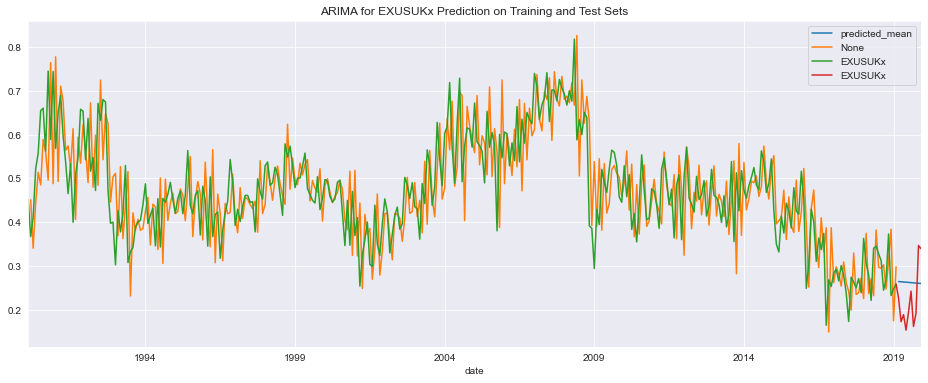

In [616]:
df_EXUSUKx_forecast_level_test.plot()
fitted_values_arima_EXUSUKx.plot()
train_ARIMA['EXUSUKx'].plot()
test_ARIMA['EXUSUKx'].plot()
plt.title('ARIMA for EXUSUKx Prediction on Training and Test Sets')
plt.legend()
plt.show()

Text(0.5, 1.0, 'ARIMA for EXUSUKx_D1 Prediction on Training and Test Sets')

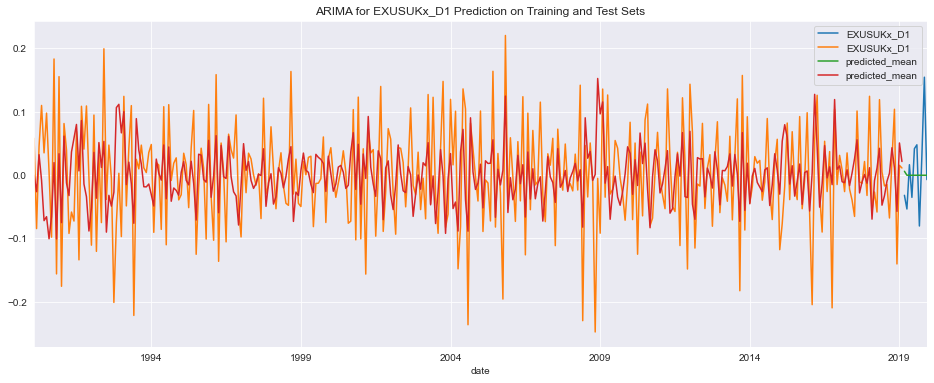

In [617]:
test['EXUSUKx_D1'].plot()
train['EXUSUKx_D1'].plot()
arima_EXUSUKx_fc.plot() 
fitted_values_arima_EXUSUKx_D1.plot()
plt.legend()
plt.title('ARIMA for EXUSUKx_D1 Prediction on Training and Test Sets')

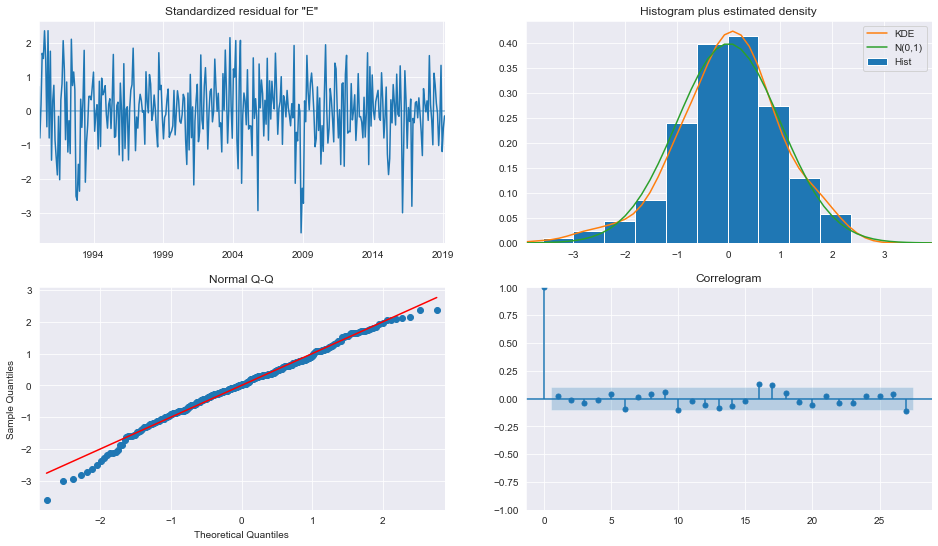

In [618]:
fig = plt.figure(figsize=(16,9))
fig = arima_EXUSUKx_result.plot_diagnostics(fig=fig, lags=27)

In [619]:
sm.stats.acorr_ljungbox(arima_EXUSUKx_result.resid, lags=[math.log(360)], return_df=True)

lb_stat  lb_pvalue
5  1.52479   0.910191

### USCONS:

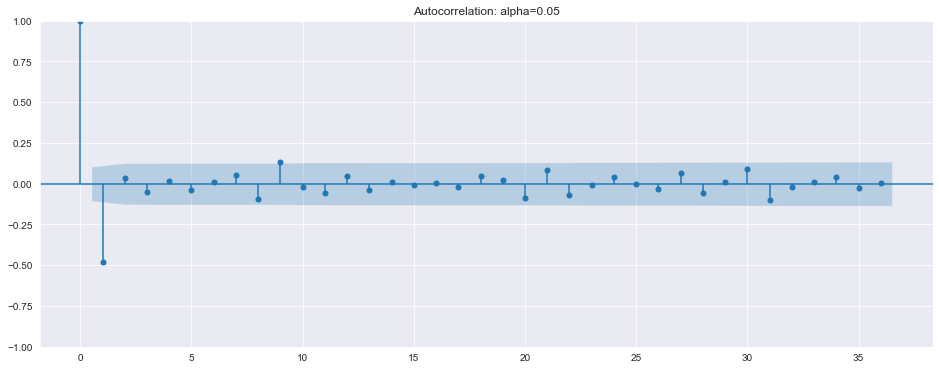

In [620]:
sm.graphics.tsa.plot_acf(train['USCONS_D1'].values.squeeze(), lags=36, alpha=0.05, title='Autocorrelation: alpha=0.05')
plt.show()

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


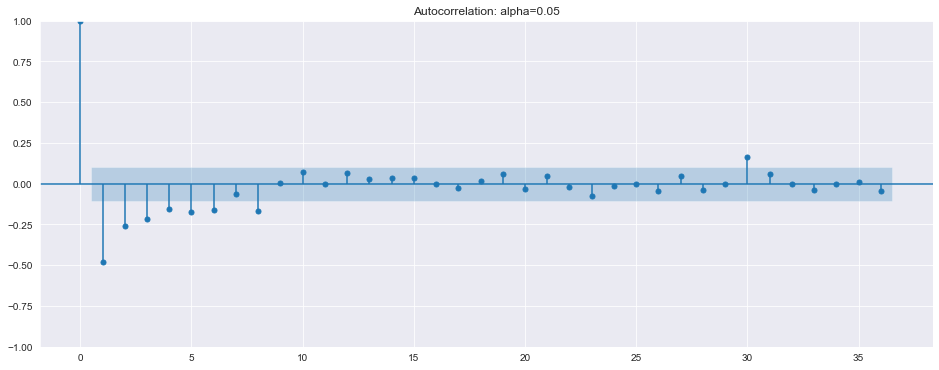

In [621]:
sm.graphics.tsa.plot_pacf(train['USCONS_D1'].values.squeeze(), lags=36, alpha=0.05, title='Autocorrelation: alpha=0.05')
plt.show()

In [622]:
ARv=[0,1,2,3,4,5,6,7,8]
MAv=[0,1]

Combinations=[]

for x in ARv:
  for y in MAv:
    comb=(x,0,y)
    Combinations.append(comb)

results_list=[]

for i, z in enumerate(Combinations):
      mod = ARIMA(train['USCONS_D1'], order=z)
      Combinations[i] = mod.fit()
      results_list.append(Combinations[i])
      print(results_list[i].summary())

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                          ARIMA   Log Likelihood                 291.681
Date:                Mon, 24 Oct 2022   AIC                           -579.362
Time:                        14:01:16   BIC                           -571.651
Sample:                    02-01-1990   HQIC                          -576.292
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.006      0.189      0.850      -0.010       0.012
sigma2         0.0110      0.001     14.113      0.000       0.009       0.013
Ljung-Box (L1) (Q):                  81.32   Jarque-

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 337.847
Date:                Mon, 24 Oct 2022   AIC                           -669.694
Time:                        14:01:16   BIC                           -658.129
Sample:                    02-01-1990   HQIC                          -665.090
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.003      0.293      0.770      -0.006       0.008
ar.L1         -0.4835      0.044    -11.091      0.000      -0.569      -0.398
sigma2         0.0084      0.001     13.123      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 371.874
Date:                Mon, 24 Oct 2022   AIC                           -733.748
Time:                        14:01:17   BIC                           -714.473
Sample:                    02-01-1990   HQIC                          -726.075
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.777      0.437      -0.001       0.003
ar.L1          0.0085      0.079      0.107      0.914      -0.147       0.164
ar.L2          0.0088      0.071      0.124      0.9

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 372.729
Date:                Mon, 24 Oct 2022   AIC                           -733.458
Time:                        14:01:18   BIC                           -710.328
Sample:                    02-01-1990   HQIC                          -724.250
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.768      0.443      -0.001       0.003
ar.L1         -0.0227      0.091     -0.248      0.804      -0.202       0.156
ar.L2         -0.0156      0.078     -0.199      0.8

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 373.486
Date:                Mon, 24 Oct 2022   AIC                           -732.972
Time:                        14:01:18   BIC                           -705.987
Sample:                    02-01-1990   HQIC                          -722.230
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.766      0.444      -0.001       0.003
ar.L1         -0.0669      0.106     -0.632      0.527      -0.274       0.141
ar.L2         -0.0453      0.084     -0.536      0.5

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 368.576
Date:                Mon, 24 Oct 2022   AIC                           -723.153
Time:                        14:01:19   BIC                           -696.167
Sample:                    02-01-1990   HQIC                          -712.411
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.527      0.598      -0.002       0.004
ar.L1         -0.7318      0.053    -13.866      0.000      -0.835      -0.628
ar.L2         -0.5150      0.067     -7.737      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                 ARIMA(5, 0, 1)   Log Likelihood                 375.247
Date:                Mon, 24 Oct 2022   AIC                           -734.493
Time:                        14:01:19   BIC                           -703.653
Sample:                    02-01-1990   HQIC                          -722.216
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.763      0.445      -0.001       0.003
ar.L1         -0.1591      0.128     -1.239      0.215      -0.411       0.093
ar.L2         -0.1194      0.106     -1.122      0.2

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                 ARIMA(6, 0, 0)   Log Likelihood                 373.470
Date:                Mon, 24 Oct 2022   AIC                           -730.940
Time:                        14:01:19   BIC                           -700.099
Sample:                    02-01-1990   HQIC                          -718.663
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.620      0.535      -0.002       0.003
ar.L1         -0.7623      0.053    -14.360      0.000      -0.866      -0.658
ar.L2         -0.5643      0.068     -8.270      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                 ARIMA(6, 0, 1)   Log Likelihood                 376.019
Date:                Mon, 24 Oct 2022   AIC                           -734.038
Time:                        14:01:20   BIC                           -699.343
Sample:                    02-01-1990   HQIC                          -720.227
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.763      0.446      -0.001       0.003
ar.L1         -0.2729      0.194     -1.405      0.160      -0.654       0.108
ar.L2         -0.2081      0.149     -1.397      0.1

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                 ARIMA(7, 0, 0)   Log Likelihood                 374.324
Date:                Mon, 24 Oct 2022   AIC                           -730.648
Time:                        14:01:20   BIC                           -695.952
Sample:                    02-01-1990   HQIC                          -716.836
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.666      0.506      -0.002       0.003
ar.L1         -0.7742      0.054    -14.323      0.000      -0.880      -0.668
ar.L2         -0.5859      0.071     -8.287      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                 ARIMA(7, 0, 1)   Log Likelihood                 376.109
Date:                Mon, 24 Oct 2022   AIC                           -732.218
Time:                        14:01:21   BIC                           -693.668
Sample:                    02-01-1990   HQIC                          -716.872
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.763      0.445      -0.001       0.003
ar.L1         -0.2905      0.350     -0.829      0.407      -0.977       0.396
ar.L2         -0.2206      0.274     -0.806      0.4

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                 ARIMA(8, 0, 1)   Log Likelihood                 378.800
Date:                Mon, 24 Oct 2022   AIC                           -735.601
Time:                        14:01:22   BIC                           -693.195
Sample:                    02-01-1990   HQIC                          -718.720
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.835      0.403      -0.001       0.003
ar.L1         -0.6558      0.337     -1.948      0.051      -1.316       0.004
ar.L2         -0.5079      0.264     -1.924      0.0

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


###### from BIC we see order (0,0,1) is best

In [623]:
arima_USCONS = ARIMA(train['USCONS_D1'], order=(0,0,1))
arima_USCONS_result = arima_USCONS.fit() 
print(arima_USCONS_result.summary())

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 371.861
Date:                Mon, 24 Oct 2022   AIC                           -737.722
Time:                        14:01:22   BIC                           -726.156
Sample:                    02-01-1990   HQIC                          -733.118
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.775      0.438      -0.001       0.003
ma.L1         -0.7722      0.035    -22.312      0.000      -0.840      -0.704
sigma2         0.0069      0.001     12.937      0.0

In [624]:
arima_USCONS_fc = arima_USCONS_result.forecast(steps = 10)
arima_USCONS_fc

2019-03-01    0.033941
2019-04-01    0.000810
2019-05-01    0.000810
2019-06-01    0.000810
2019-07-01    0.000810
2019-08-01    0.000810
2019-09-01    0.000810
2019-10-01    0.000810
2019-11-01    0.000810
2019-12-01    0.000810
Freq: MS, Name: predicted_mean, dtype: float64

In [625]:
df.tail(11)

Unnamed: 0      GS10   EXUSUKx    USCONS   GS10_D1  EXUSUKx_D1  \
date                                                                         
2019-02-01         723  2.664951  0.258564  8.845101 -0.720049    0.010978   
2019-03-01         724  2.214484  0.226401  8.996948 -0.450467   -0.032163   
2019-04-01         725  2.021801  0.172626  9.039967 -0.192684   -0.053775   
2019-05-01         726  2.968596  0.188786  8.975907  0.946796    0.016160   
2019-06-01         727  2.813438  0.153383  9.001451 -0.155158   -0.035403   
2019-07-01         728  1.674241  0.194873  8.860219 -1.139198    0.041491   
2019-08-01         729  3.116371  0.242450  8.973032  1.442131    0.047577   
2019-09-01         730  1.298880  0.161836  9.036925 -1.817491   -0.080614   
2019-10-01         731  1.557615  0.192354  8.980973  0.258735    0.030519   
2019-11-01         732  3.090388  0.346695  8.954072  1.532773    0.154341   
2019-12-01         733  1.252976  0.339328  8.826249 -1.837412   -0.007367   

            USCONS_D1  
date                   
2019-02-01  -0.074715  
2019-03-01   0.151846  
2019-04-01   0.043019  
2019-05-01  -0.064060  
2019-06-01   0.025544  
2019-07-01  -0.141232  
2019-08-01   0.112813  
2019-09-01   0.063893  
2019-10-01  -0.055952  
2019-11-01  -0.026901  
2019-12-01  -0.127823

In [626]:
CS_arima_USCONS_D1_fc=np.cumsum(arima_USCONS_fc)+8.845101

In [627]:
### Bring forecast to level
df_USCONS_forecast_level_test = CS_arima_USCONS_D1_fc

In [628]:
df_USCONS_forecast_level_test.head(11)

2019-03-01    8.879042
2019-04-01    8.879852
2019-05-01    8.880663
2019-06-01    8.881473
2019-07-01    8.882284
2019-08-01    8.883094
2019-09-01    8.883905
2019-10-01    8.884715
2019-11-01    8.885525
2019-12-01    8.886336
Freq: MS, Name: predicted_mean, dtype: float64

In [629]:
fitted_values_arima_USCONS_D1 = arima_USCONS_result.predict()

In [630]:
fitted_values_arima_USCONS = fitted_values_arima_USCONS_D1.shift(1) + train_ARIMA['USCONS'].shift(1)

In [631]:
fitted_values_arima_USCONS.head()

1990-02-01         NaN
1990-03-01    8.641748
1990-04-01    8.625014
1990-05-01    8.455935
1990-06-01    8.716489
Freq: MS, dtype: float64

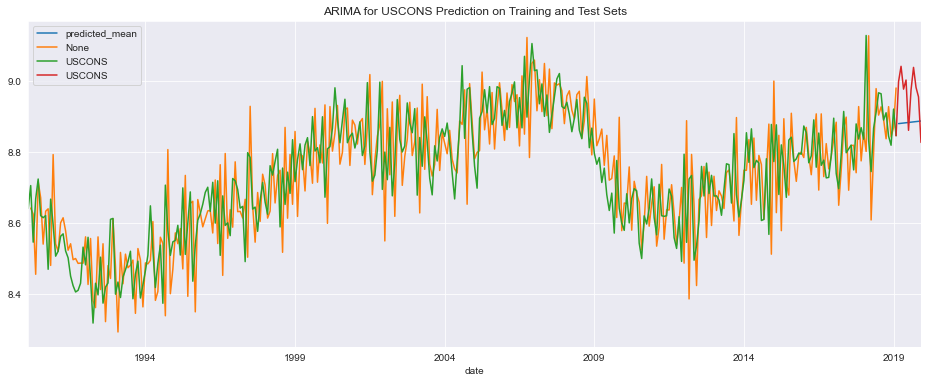

In [632]:
df_USCONS_forecast_level_test.plot()
fitted_values_arima_USCONS.plot()
train_ARIMA['USCONS'].plot()
test_ARIMA['USCONS'].plot()
plt.title('ARIMA for USCONS Prediction on Training and Test Sets')
plt.legend()
plt.show()

Text(0.5, 1.0, 'ARIMA for USCONS Prediction on Training and Test Sets')

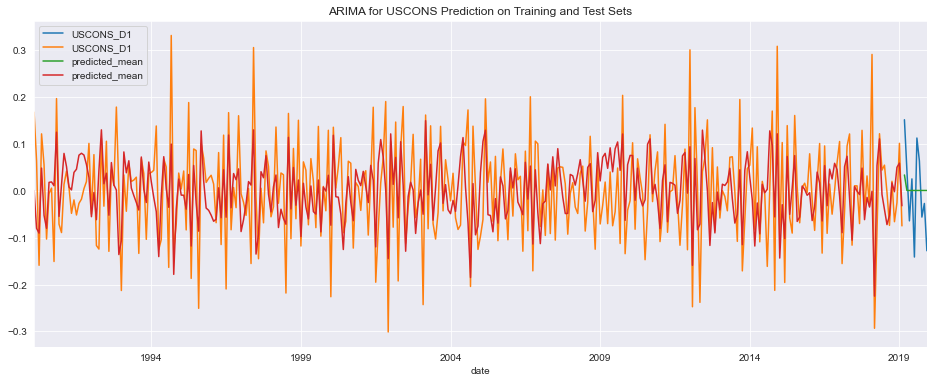

In [633]:
test['USCONS_D1'].plot()
train['USCONS_D1'].plot()
arima_USCONS_fc.plot() 
fitted_values_arima_USCONS_D1.plot()
plt.legend()
plt.title('ARIMA for USCONS Prediction on Training and Test Sets')

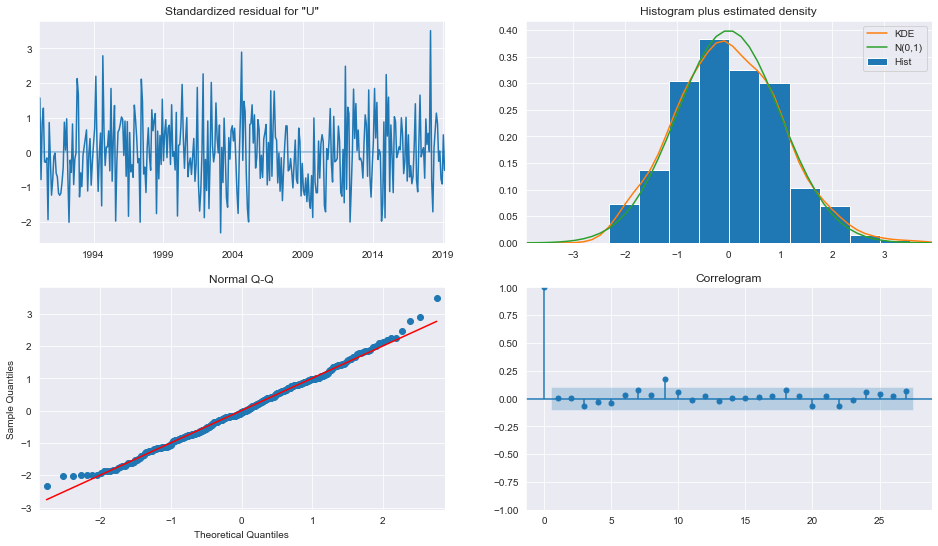

In [634]:
fig = plt.figure(figsize=(16,9))
fig = arima_USCONS_result.plot_diagnostics(fig=fig, lags=27)

In [635]:
sm.stats.acorr_ljungbox(arima_USCONS_result.resid, lags=[math.log(360)], return_df=True)

lb_stat  lb_pvalue
5  2.445881   0.784623

##### The below show in a different way that order (0,0,1) has the lowest BIC for each series

In [636]:
#### Not sure why this is here???
model = auto_arima(train['GS10_D1'], start_p=0, start_q=0)
model.summary()
model.fit(train['GS10_D1'])

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [637]:
model = auto_arima(train['EXUSUKx_D1'], start_p=0, start_q=0)
model.summary()
model.fit(train['EXUSUKx_D1'])

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [638]:
model = auto_arima(train['USCONS_D1'], start_p=0, start_q=0)
model.summary()
model.fit(train['USCONS_D1'])

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# VAR Model 



In [639]:
test_obs = 10

### (a). The Below function provides the optimum selection for var(p) based on the BIC first.

In [640]:
VAR_model  = VAR(train)
result = VAR_model.fit(maxlags=i, ic='bic', trend='c',verbose=True)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 6, BIC -> 2, FPE -> 6, HQIC ->  4>
Using 2 based on bic criterion


C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [641]:
VAR_model  = VAR(train)
test_model = VAR_model.select_order(maxlags=12)
print(test_model.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -9.043      -9.009   0.0001183      -9.029
1       -9.761      -9.625   5.765e-05      -9.707
2       -9.994     -9.756*   4.569e-05      -9.899
3       -10.05      -9.711   4.314e-05      -9.916
4       -10.10      -9.654   4.123e-05     -9.920*
5       -10.12      -9.576   4.025e-05      -9.904
6      -10.13*      -9.488  3.973e-05*      -9.876
7       -10.10      -9.355   4.099e-05      -9.805
8       -10.11      -9.264   4.052e-05      -9.776
9       -10.08      -9.131   4.181e-05      -9.704
10      -10.06      -9.011   4.262e-05      -9.645
11      -10.03      -8.872   4.421e-05      -9.568
12      -10.00      -8.744   4.541e-05      -9.501
--------------------------------------------------


C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### (b). training model results (BIC; p=3 first then we can test p=6 after analysing the results)

In [642]:
VAR_model  = VAR(train)
VAR_result = VAR_model.fit(2, trend='c')

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [643]:
print(VAR_result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Oct, 2022
Time:                     14:01:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.69073
Nobs:                     347.000    HQIC:                  -9.83093
Log likelihood:           265.645    FPE:                4.90010e-05
AIC:                     -9.92369    Det(Omega_mle):     4.61512e-05
--------------------------------------------------------------------
Results for equation GS10_D1
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.033203         0.059575           -0.557           0.577
L1.GS10_D1           -0.653901         0.050951          -12.834           0.000
L1.EXUSUKx_D1        -2.066861         0.825206           

### (c). Forecast Values based of test set

In [644]:
lag_order = VAR_result.k_ar

In [645]:
print(lag_order)

2


In [646]:
fc_test = VAR_result.forecast(test.values[-lag_order:], steps = 10)

In [647]:
df_forecast_test = pd.DataFrame(fc_test, index=df.index[-10:], columns= test.columns)

###### We must transform the two series back to their level values

In [648]:
test_VAR = df[['Unnamed: 0', 'GS10', 'EXUSUKx', 'USCONS']]

In [649]:
test_VAR = df[(df['Unnamed: 0']>722) & (df['Unnamed: 0']<=733)]

In [650]:
test_VAR.tail(12)

Unnamed: 0      GS10   EXUSUKx    USCONS   GS10_D1  EXUSUKx_D1  \
date                                                                         
2019-02-01         723  2.664951  0.258564  8.845101 -0.720049    0.010978   
2019-03-01         724  2.214484  0.226401  8.996948 -0.450467   -0.032163   
2019-04-01         725  2.021801  0.172626  9.039967 -0.192684   -0.053775   
2019-05-01         726  2.968596  0.188786  8.975907  0.946796    0.016160   
2019-06-01         727  2.813438  0.153383  9.001451 -0.155158   -0.035403   
2019-07-01         728  1.674241  0.194873  8.860219 -1.139198    0.041491   
2019-08-01         729  3.116371  0.242450  8.973032  1.442131    0.047577   
2019-09-01         730  1.298880  0.161836  9.036925 -1.817491   -0.080614   
2019-10-01         731  1.557615  0.192354  8.980973  0.258735    0.030519   
2019-11-01         732  3.090388  0.346695  8.954072  1.532773    0.154341   
2019-12-01         733  1.252976  0.339328  8.826249 -1.837412   -0.007367   

            USCONS_D1  
date                   
2019-02-01  -0.074715  
2019-03-01   0.151846  
2019-04-01   0.043019  
2019-05-01  -0.064060  
2019-06-01   0.025544  
2019-07-01  -0.141232  
2019-08-01   0.112813  
2019-09-01   0.063893  
2019-10-01  -0.055952  
2019-11-01  -0.026901  
2019-12-01  -0.127823

In [651]:
df_forecast_test["GS10"]= np.cumsum(df_forecast_test["GS10_D1"])+2.664951
df_forecast_test["EXUSUKx"]= np.cumsum(df_forecast_test["EXUSUKx_D1"])+0.258564
df_forecast_test["USCONS"]= np.cumsum(df_forecast_test["USCONS_D1"])+8.845101

In [652]:
df_forecast_test.head(10)

GS10_D1  EXUSUKx_D1  USCONS_D1      GS10   EXUSUKx    USCONS
date                                                                     
2019-03-01  0.456106   -0.017869   0.093716  3.121057  0.240695  8.938817
2019-04-01  0.390056    0.007598  -0.020179  3.511113  0.248293  8.918639
2019-05-01 -0.463758   -0.005054  -0.010556  3.047356  0.243240  8.908083
2019-06-01  0.141344    0.004649   0.009464  3.188700  0.247889  8.917547
2019-07-01  0.032156   -0.003687   0.000571  3.220856  0.244201  8.918118
2019-08-01 -0.101477    0.000079  -0.001657  3.119379  0.244280  8.916461
2019-09-01  0.025739    0.000589   0.001088  3.145118  0.244870  8.917549
2019-10-01 -0.016426   -0.001325   0.001689  3.128693  0.243544  8.919238
2019-11-01 -0.028794   -0.000033  -0.000260  3.099898  0.243511  8.918978
2019-12-01 -0.007692   -0.000396   0.000804  3.092207  0.243115  8.919782

In [653]:
#df_forecast_test = df_forecast_test[['GS10', 'EXUSUKx', 'USCONS']]

In [654]:
df_forecast_test = df_forecast_test.rename(columns={"GS10_D1"    : "GS10_D1_forecast"})
df_forecast_test = df_forecast_test.rename(columns={"EXUSUKx_D1" : "EXUSUKx_D1_forecast"})
df_forecast_test = df_forecast_test.rename(columns={"USCONS_D1"  : "USCONS_D1_forecast"})
df_forecast_test = df_forecast_test.rename(columns={"GS10"    : "GS10_forecast"})
df_forecast_test = df_forecast_test.rename(columns={"EXUSUKx" : "EXUSUKx_forecast"})
df_forecast_test = df_forecast_test.rename(columns={"USCONS"  : "USCONS_forecast"})

In [655]:
df_forecast_test

GS10_D1_forecast  EXUSUKx_D1_forecast  USCONS_D1_forecast  \
date                                                                    
2019-03-01          0.456106            -0.017869            0.093716   
2019-04-01          0.390056             0.007598           -0.020179   
2019-05-01         -0.463758            -0.005054           -0.010556   
2019-06-01          0.141344             0.004649            0.009464   
2019-07-01          0.032156            -0.003687            0.000571   
2019-08-01         -0.101477             0.000079           -0.001657   
2019-09-01          0.025739             0.000589            0.001088   
2019-10-01         -0.016426            -0.001325            0.001689   
2019-11-01         -0.028794            -0.000033           -0.000260   
2019-12-01         -0.007692            -0.000396            0.000804   

            GS10_forecast  EXUSUKx_forecast  USCONS_forecast  
date                                                          
2019-03-01       3.121057          0.240695         8.938817  
2019-04-01       3.511113          0.248293         8.918639  
2019-05-01       3.047356          0.243240         8.908083  
2019-06-01       3.188700          0.247889         8.917547  
2019-07-01       3.220856          0.244201         8.918118  
2019-08-01       3.119379          0.244280         8.916461  
2019-09-01       3.145118          0.244870         8.917549  
2019-10-01       3.128693          0.243544         8.919238  
2019-11-01       3.099898          0.243511         8.918978  
2019-12-01       3.092207          0.243115         8.919782

### (d). Forecast V Actual Plot (training and Test)

###### We have to scale up the predicted values as well

In [656]:
df_fit_train = VAR_result.fittedvalues

In [657]:
df_fit_train

GS10_D1  EXUSUKx_D1  USCONS_D1
date                                       
1990-04-01  1.246114    0.017101  -0.097691
1990-05-01 -0.182041   -0.013088   0.088770
1990-06-01 -2.055324   -0.057842   0.003958
1990-07-01  1.313873   -0.043010  -0.061542
1990-08-01  2.144926   -0.074994   0.076255
...              ...         ...        ...
2018-10-01  0.209041    0.045828   0.025315
2018-11-01 -0.414740    0.004707   0.008051
2018-12-01  1.251104   -0.051774   0.044516
2019-01-01 -0.410207    0.036868   0.039912
2019-02-01 -0.307447    0.035881  -0.081454

[347 rows x 3 columns]

In [658]:
df_fit_train['GS10_fitted_values'] = df_fit_train['GS10_D1'].shift(1) + df['GS10'].shift(1)
df_fit_train['EXUSUKx_fitted_values'] = df_fit_train['EXUSUKx_D1'].shift(1) + df['EXUSUKx'].shift(1)
df_fit_train['USCONS_fitted_values'] = df_fit_train['USCONS_D1'].shift(1) + df['USCONS'].shift(1)

In [659]:
df_fit_train

GS10_D1  EXUSUKx_D1  USCONS_D1  GS10_fitted_values  \
date                                                              
1990-04-01  1.246114    0.017101  -0.097691                 NaN   
1990-05-01 -0.182041   -0.013088   0.088770           10.058394   
1990-06-01 -2.055324   -0.057842   0.003958           10.810026   
1990-07-01  1.313873   -0.043010  -0.061542            5.435814   
1990-08-01  2.144926   -0.074994   0.076255            6.843221   
...              ...         ...        ...                 ...   
2018-10-01  0.209041    0.045828   0.025315            3.239618   
2018-11-01 -0.414740    0.004707   0.008051            4.651630   
2018-12-01  1.251104   -0.051774   0.044516            1.172114   
2019-01-01 -0.410207    0.036868   0.039912            5.159570   
2019-02-01 -0.307447    0.035881  -0.081454            2.974792   

            EXUSUKx_fitted_values  USCONS_fitted_values  
date                                                     
1990-04-01                    NaN                   NaN  
1990-05-01               0.429680              8.448455  
1990-06-01               0.509200              8.756608  
1990-07-01               0.499312              8.727381  
1990-08-01               0.611774              8.559035  
...                           ...                   ...  
2018-10-01               0.248170              8.878026  
2018-11-01               0.315071              8.934902  
2018-12-01               0.377637              8.851795  
2019-01-01               0.180630              8.862838  
2019-02-01               0.284455              8.959728  

[347 rows x 6 columns]

In [660]:
#df_fit_train = df_fit_train[['GS10_fitted_values', 'EXUSUKx_fitted_values', 'USCONS_fitted_values']]

In [661]:
df_fit_train = df_fit_train.rename(columns={"GS10_D1"    : "GS10_D1_fitted_values"})
df_fit_train = df_fit_train.rename(columns={"EXUSUKx_D1"    : "EXUSUKx_D1_fitted_values"})
df_fit_train = df_fit_train.rename(columns={"USCONS_D1"    : "USCONS_D1_fitted_values"})

In [662]:
df_fit_train

GS10_D1_fitted_values  EXUSUKx_D1_fitted_values  \
date                                                          
1990-04-01               1.246114                  0.017101   
1990-05-01              -0.182041                 -0.013088   
1990-06-01              -2.055324                 -0.057842   
1990-07-01               1.313873                 -0.043010   
1990-08-01               2.144926                 -0.074994   
...                           ...                       ...   
2018-10-01               0.209041                  0.045828   
2018-11-01              -0.414740                  0.004707   
2018-12-01               1.251104                 -0.051774   
2019-01-01              -0.410207                  0.036868   
2019-02-01              -0.307447                  0.035881   

            USCONS_D1_fitted_values  GS10_fitted_values  \
date                                                      
1990-04-01                -0.097691                 NaN   
1990-05-01                 0.088770           10.058394   
1990-06-01                 0.003958           10.810026   
1990-07-01                -0.061542            5.435814   
1990-08-01                 0.076255            6.843221   
...                             ...                 ...   
2018-10-01                 0.025315            3.239618   
2018-11-01                 0.008051            4.651630   
2018-12-01                 0.044516            1.172114   
2019-01-01                 0.039912            5.159570   
2019-02-01                -0.081454            2.974792   

            EXUSUKx_fitted_values  USCONS_fitted_values  
date                                                     
1990-04-01                    NaN                   NaN  
1990-05-01               0.429680              8.448455  
1990-06-01               0.509200              8.756608  
1990-07-01               0.499312              8.727381  
1990-08-01               0.611774              8.559035  
...                           ...                   ...  
2018-10-01               0.248170              8.878026  
2018-11-01               0.315071              8.934902  
2018-12-01               0.377637              8.851795  
2019-01-01               0.180630              8.862838  
2019-02-01               0.284455              8.959728  

[347 rows x 6 columns]

###### Now we have a df with fitted values we just need to identify the training and test sets

In [663]:
df_var_train = df[['Unnamed: 0', 'GS10', 'EXUSUKx', 'USCONS']]

In [664]:
df_var_train = df_var_train[df_var_train['Unnamed: 0']<=724]

In [665]:
df_var_train = df_var_train[['GS10', 'EXUSUKx', 'USCONS']]

In [666]:
df_var_train = df_var_train.rename(columns={"GS10"    : "GS10_training_set"})
df_var_train = df_var_train.rename(columns={"EXUSUKx"    : "EXUSUKx_training_set"})
df_var_train = df_var_train.rename(columns={"USCONS"    : "USCONS_training_set"})

In [667]:
df_var_train.head()

GS10_training_set  EXUSUKx_training_set  USCONS_training_set
date                                                                    
1990-02-01           9.632165              0.451878             8.640938
1990-03-01           7.656738              0.367179             8.705040
1990-04-01           8.812280              0.412580             8.546146
1990-05-01          10.992067              0.522288             8.667838
1990-06-01           7.491139              0.557154             8.723423

In [668]:
df_var_test = df[['Unnamed: 0', 'GS10', 'EXUSUKx', 'USCONS']]

In [669]:
df_var_test = df_var_test[(df_var_test['Unnamed: 0']>723) & (df_var_test['Unnamed: 0']<=733)]

In [670]:
df_var_test = df_var_test[['GS10', 'EXUSUKx', 'USCONS']]

In [671]:
df_var_test = df_var_test.rename(columns={"GS10"    : "GS10_test_set"})
df_var_test = df_var_test.rename(columns={"EXUSUKx"    : "EXUSUKx_test_set"})
df_var_test = df_var_test.rename(columns={"USCONS"    : "USCONS_test_set"})

In [672]:
df_var_test.head()

GS10_test_set  EXUSUKx_test_set  USCONS_test_set
date                                                        
2019-03-01       2.214484          0.226401         8.996948
2019-04-01       2.021801          0.172626         9.039967
2019-05-01       2.968596          0.188786         8.975907
2019-06-01       2.813438          0.153383         9.001451
2019-07-01       1.674241          0.194873         8.860219

###### Plots of Forecast v Actuals (training and test set)

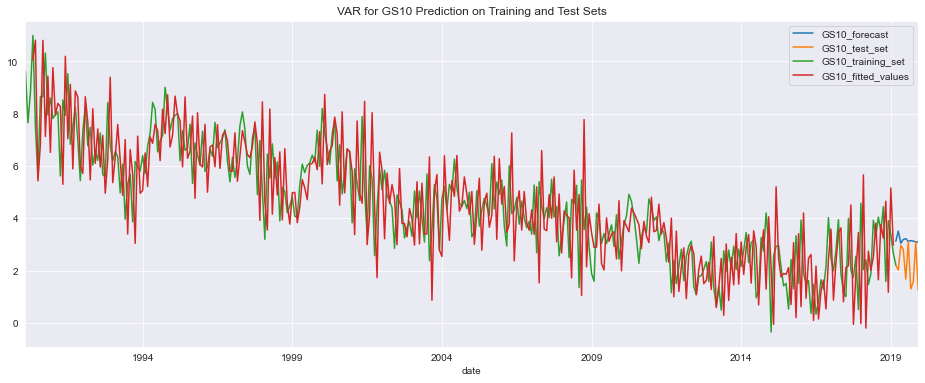

In [673]:
df_forecast_test['GS10_forecast'].plot()
df_var_test['GS10_test_set'].plot()
df_var_train['GS10_training_set'].plot()
df_fit_train['GS10_fitted_values'].plot()
plt.title('VAR for GS10 Prediction on Training and Test Sets')
plt.legend()
plt.show()

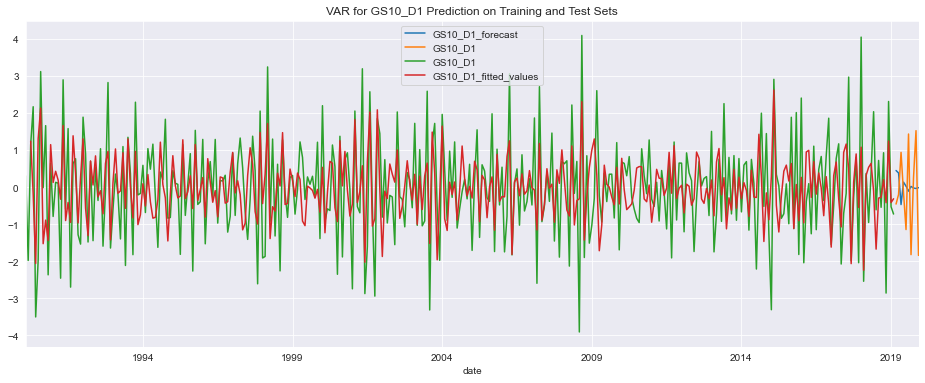

In [674]:
df_forecast_test['GS10_D1_forecast'].plot()
test['GS10_D1'].plot()
train['GS10_D1'].plot()
df_fit_train['GS10_D1_fitted_values'].plot()
plt.title('VAR for GS10_D1 Prediction on Training and Test Sets')
plt.legend()
plt.show()

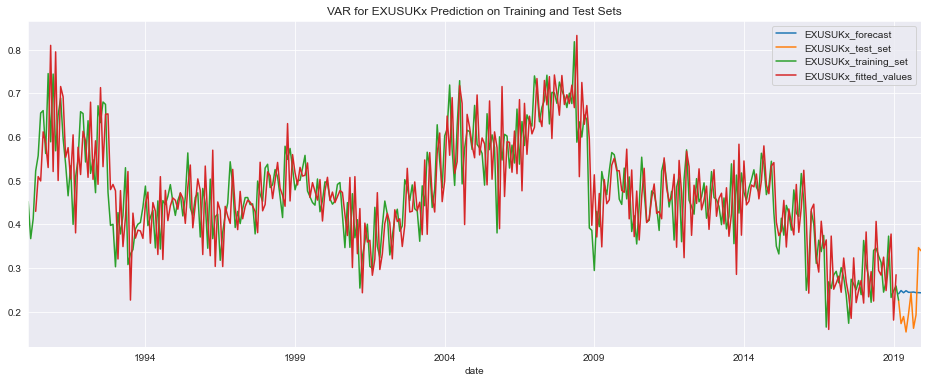

In [675]:
df_forecast_test['EXUSUKx_forecast'].plot()
df_var_test['EXUSUKx_test_set'].plot()
df_var_train['EXUSUKx_training_set'].plot()
df_fit_train['EXUSUKx_fitted_values'].plot()
plt.title('VAR for EXUSUKx Prediction on Training and Test Sets')
plt.legend()
plt.show()

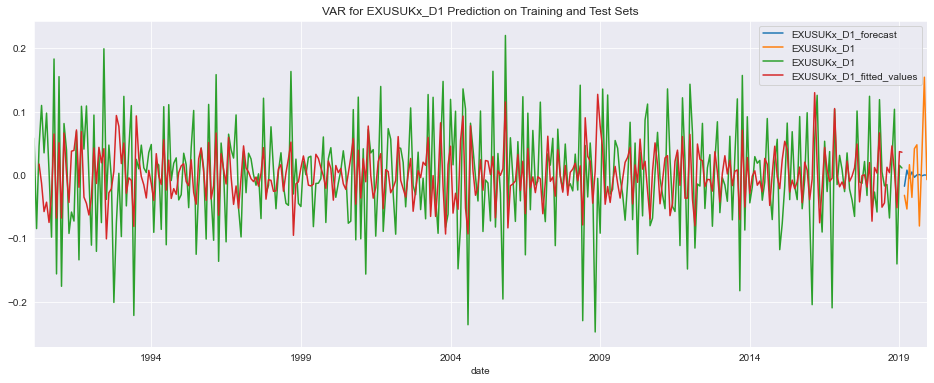

In [676]:
df_forecast_test['EXUSUKx_D1_forecast'].plot()
test['EXUSUKx_D1'].plot()
train['EXUSUKx_D1'].plot()
df_fit_train['EXUSUKx_D1_fitted_values'].plot()
plt.title('VAR for EXUSUKx_D1 Prediction on Training and Test Sets')
plt.legend()
plt.show()

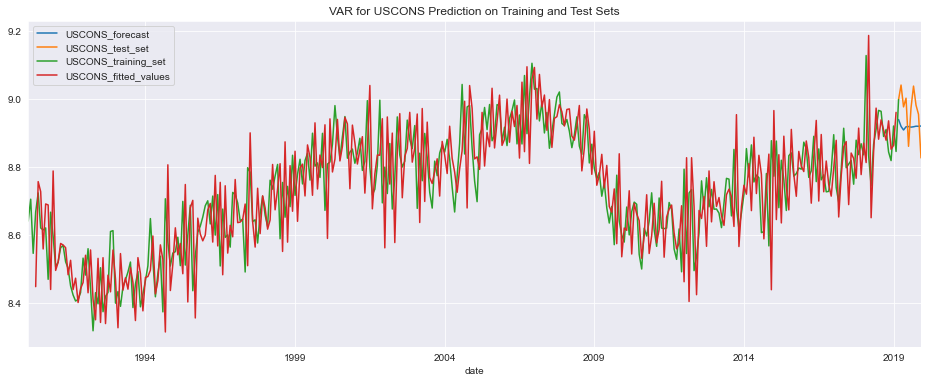

In [677]:
df_forecast_test['USCONS_forecast'].plot()
df_var_test['USCONS_test_set'].plot()
df_var_train['USCONS_training_set'].plot()
df_fit_train['USCONS_fitted_values'].plot()
plt.title('VAR for USCONS Prediction on Training and Test Sets')
plt.legend()
plt.show()

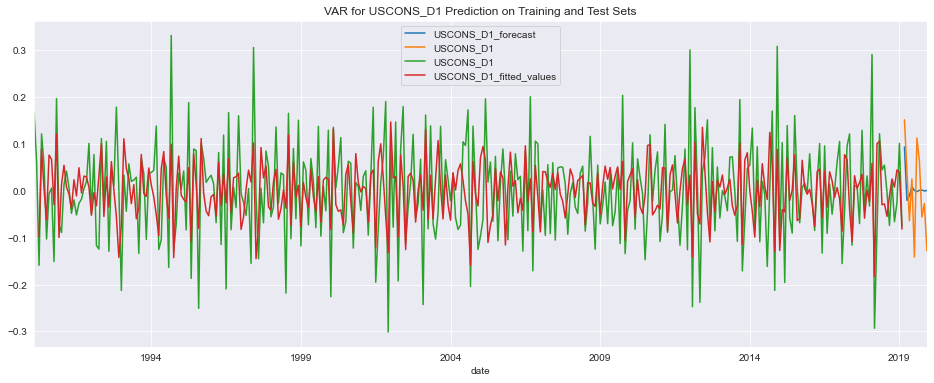

In [678]:
df_forecast_test['USCONS_D1_forecast'].plot()
test['USCONS_D1'].plot()
train['USCONS_D1'].plot()
df_fit_train['USCONS_D1_fitted_values'].plot()
plt.title('VAR for USCONS_D1 Prediction on Training and Test Sets')
plt.legend()
plt.show()

### (e). Model Diagnosis and Forecast Performance

In [679]:
def var_post_analysis(train,i):

    print("---------------------------------------------")
    print("Plotting input time series")
    print("---------------------------------------------")
    
    VAR_result.plot()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting time series autocorrelation function")
    print("---------------------------------------------")
          
    VAR_result.plot_acorr()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting IRF")
    print("---------------------------------------------")
    
    irf = VAR_result.irf(10)
    irf.plot(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting cumulative effects")
    print("---------------------------------------------")
    
    irf.plot_cum_effects(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Granger test")
    print("---------------------------------------------")
    
    test_result1 = VAR_result.test_causality('GS10_D1', ['EXUSUKx_D1', 'USCONS_D1'], kind='f')
    print(test_result1.summary())
    
    test_result2 = VAR_result.test_causality('EXUSUKx_D1', ['GS10_D1', 'USCONS_D1'], kind='f')
    print(test_result2.summary())
    
    test_result3 = VAR_result.test_causality('USCONS_D1', ['EXUSUKx_D1', 'GS10_D1'], kind='f')
    print(test_result3.summary())
    
    print("---------------------------------------------")
    print("Ljung-Box test for VAR")
    print("---------------------------------------------")
    test_result4 = VAR_result.test_whiteness()
    print(test_result4.summary())
    
    print("---------------------------------------------")
    print("Normality Test")
    print("---------------------------------------------")
    test_result5 = VAR_result.test_normality()
    print(test_result5.summary())    
    
    print("---------------------------------------------")
    print("check stationarity")
    print("---------------------------------------------")
    
    VAR_result.is_stable(verbose =1 )
    
    print("---------------------------------------------")
    print("Plotting Forecast (in-sample)")
    print("---------------------------------------------")
    
    VAR_result.plot_forecast(10)
    
    print("---------------------------------------------")
    print("Forecast Error Variance Decomposition")
    print("---------------------------------------------")
          
    fevd = VAR_result.fevd(5)
    
    VAR_result.fevd(20).plot()

In [680]:
VAR_result.is_stable(verbose =1 )

Eigenvalues of VAR(1) rep
0.5476950299254294
0.5476950299254294
0.5136272479045605
0.5136272479045605
0.5775249756362762
0.5775249756362762


True

---------------------------------------------
Plotting input time series
---------------------------------------------


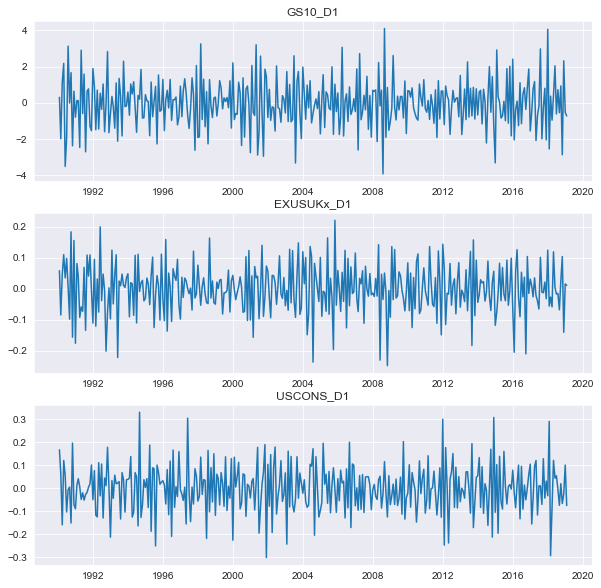

---------------------------------------------
Plotting time series autocorrelation function
---------------------------------------------


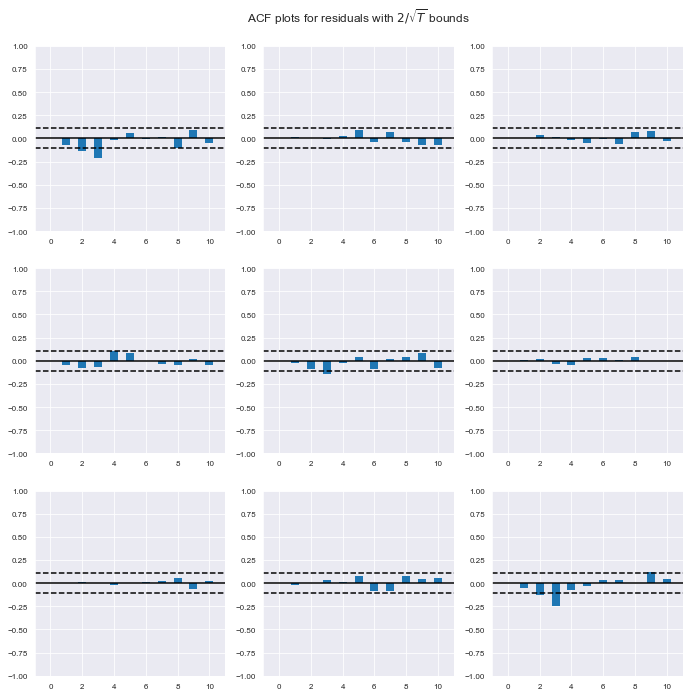

---------------------------------------------
Plotting IRF
---------------------------------------------


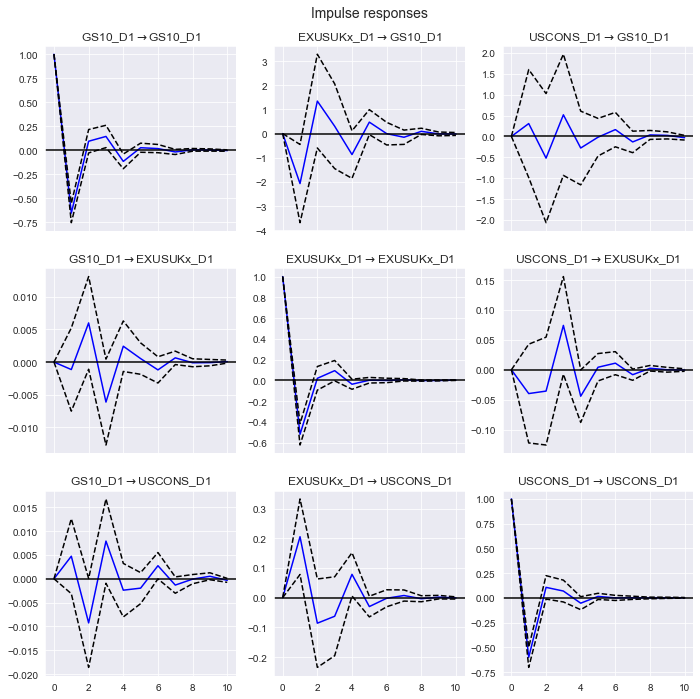

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


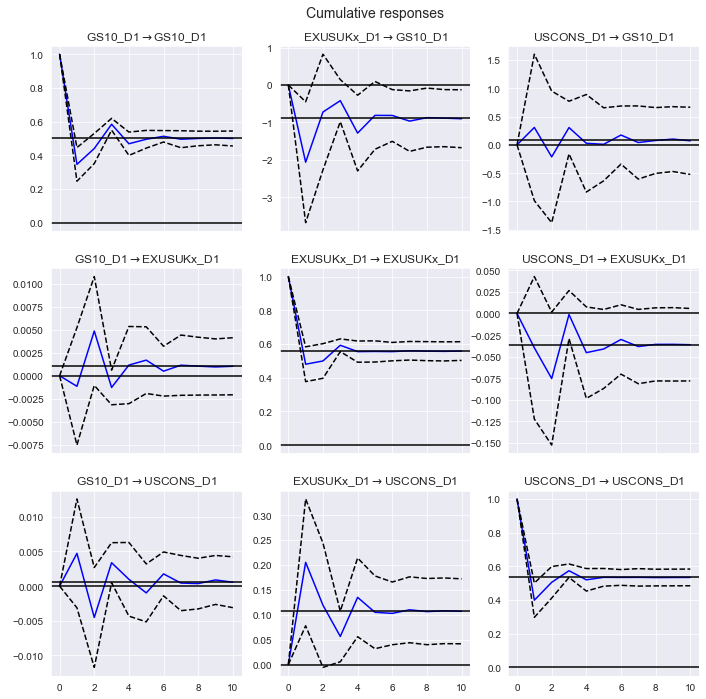

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['EXUSUKx_D1', 'USCONS_D1'] do not Granger-cause GS10_D1. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.757          2.381   0.135 (4, 1020)
-----------------------------------------------
Granger causality F-test. H_0: ['GS10_D1', 'USCONS_D1'] do not Granger-cause EXUSUKx_D1. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.898          2.381   0.109 (4, 1020)
-----------------------------------------------
Granger causality F-test. H_0: ['EXUSUKx_D1', 'GS10_D1'] do not Granger-cause USCONS_D1. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
---------------------------------

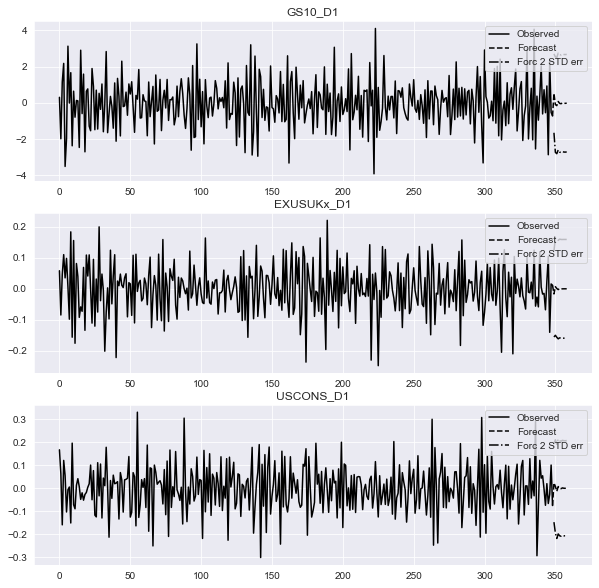

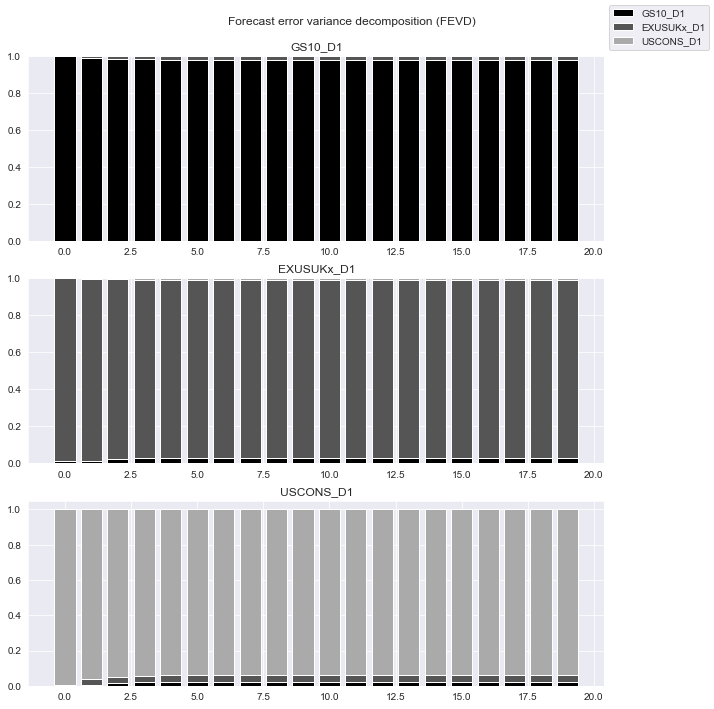

In [681]:
var_post_analysis(train,2)

In [682]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # Mean Asolute Percentage Error
    me = np.mean(forecast - actual)                           # Mean Error
    mae = np.mean(np.abs(forecast - actual))                  # Mean Absolute Error
    mpe = np.mean((forecast - actual)/actual)                 # Mean Percentage Error
    rmse = np.mean((forecast - actual)**2)**.5                # Root-Mean Square Error
    corr = np.corrcoef(forecast, actual)[0,1]                 # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)                           # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: GS10')
accuracy_prod = forecast_accuracy(df_forecast_test['GS10_forecast'].values, df_var_test['GS10_test_set'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: EXUSUKx')
accuracy_prod = forecast_accuracy(df_forecast_test['EXUSUKx_forecast'].values, df_var_test['EXUSUKx_test_set'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: USCONS')
accuracy_prod = forecast_accuracy(df_forecast_test['USCONS_forecast'].values, df_var_test['USCONS_test_set'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: GS10
mape :  0.6132
me :  0.9666
mae :  0.9666
mpe :  0.6132
rmse :  1.2181
corr :  -0.1795
minmax :  0.3026

Forecast Accuracy of: EXUSUKx
mape :  0.3027
me :  0.0225
mae :  0.0624
mpe :  0.1865
rmse :  0.0705
corr :  -0.4766
minmax :  0.2309

Forecast Accuracy of: USCONS
mape :  0.0084
me :  -0.0453
mae :  0.0755
mpe :  -0.005
rmse :  0.0802
corr :  0.0623
minmax :  0.0084


<ipython-input-682-0633f0dff07d>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-682-0633f0dff07d>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


## Model selection for Auto Regressive Distributed Lag Models 

#### using ARDL_select_order with up to 5 lags 

In [683]:
select_GS10_D1 = ardl_select_order(train[['GS10_D1']], 6, train[["EXUSUKx_D1", "USCONS_D1"]], 5, ic="bic", glob=True)

select_GS10_D1.model.dl_lags

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'EXUSUKx_D1': [0]}

In [684]:
select_GS10_D1.model.ar_lags

[1, 2, 3, 4]

#### GS10_D1 lags 1,2,3,5 significant, USUK has contemporaneous effect, uscons has none

In [685]:
select_EXUSUKx_D1 = ardl_select_order(train[['EXUSUKx_D1']], 6, train[["GS10_D1", "USCONS_D1"]], 5, ic="bic", glob=True
)

select_EXUSUKx_D1.model.dl_lags

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'GS10_D1': [3]}

In [686]:
select_EXUSUKx_D1.model.ar_lags 

[1, 2, 3, 4]

#### USUK lags 1,2,3,4 sigificant, none for others

In [687]:
select_USCONS_D1 = ardl_select_order(train[['USCONS_D1']], 6, train[["GS10_D1", "EXUSUKx_D1"]], 5, ic="bic", glob=True
)

select_USCONS_D1.model.dl_lags

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'EXUSUKx_D1': [0]}

In [688]:
select_USCONS_D1.model.ar_lags 

[1, 2, 3, 4, 5, 6]

#### USCONS lags up to 5 significant, USUK contemporaneous effect, none for GS10_D1

### For loop to print best performing ARDL models according to BIC 

In [689]:
for i, val in enumerate(select_GS10_D1.bic.head(10)):
    print(f"{i+1}: {val}")

1: ((1, 2, 3, 4), {'EXUSUKx_D1': (0,), 'USCONS_D1': None})
2: ((1, 2, 3, 4), {'EXUSUKx_D1': None, 'USCONS_D1': None})
3: ((1, 2, 3, 4, 5), {'EXUSUKx_D1': (0,), 'USCONS_D1': None})
4: ((1, 2, 3, 4), {'EXUSUKx_D1': (1,), 'USCONS_D1': None})
5: ((1, 2, 3, 4), {'EXUSUKx_D1': (0, 5), 'USCONS_D1': None})
6: ((1, 2, 3, 4, 5, 6), {'EXUSUKx_D1': (0,), 'USCONS_D1': None})
7: ((1, 2, 3, 4), {'EXUSUKx_D1': (5,), 'USCONS_D1': None})
8: ((1, 2, 3, 4, 5), {'EXUSUKx_D1': (0, 5), 'USCONS_D1': None})
9: ((1, 2, 3, 4, 5), {'EXUSUKx_D1': None, 'USCONS_D1': None})
10: ((1, 2, 3, 4), {'EXUSUKx_D1': (0, 1), 'USCONS_D1': None})


In [690]:
for i, val in enumerate(select_EXUSUKx_D1.bic.head(10)):
    print(f"{i+1}: {val}")

1: ((1, 2, 3, 4), {'GS10_D1': (3,), 'USCONS_D1': None})
2: ((1, 2, 3, 4), {'GS10_D1': (0, 3), 'USCONS_D1': None})
3: ((1, 2, 3, 4), {'GS10_D1': None, 'USCONS_D1': None})
4: ((1, 2, 3), {'GS10_D1': None, 'USCONS_D1': None})
5: ((1, 2, 3, 4), {'GS10_D1': (0,), 'USCONS_D1': None})
6: ((1, 2, 3), {'GS10_D1': (0,), 'USCONS_D1': None})
7: ((1, 2, 3), {'GS10_D1': (3,), 'USCONS_D1': None})
8: ((1, 2, 3), {'GS10_D1': (0, 3), 'USCONS_D1': None})
9: ((1, 2, 3, 4, 6), {'GS10_D1': (3,), 'USCONS_D1': None})
10: ((1, 2, 3, 4, 6), {'GS10_D1': None, 'USCONS_D1': None})


In [691]:
for i, val in enumerate(select_USCONS_D1.bic.head(10)):
    print(f"{i+1}: {val}")

1: ((1, 2, 3, 4, 5, 6), {'EXUSUKx_D1': (0,), 'GS10_D1': None})
2: ((1, 2, 3, 4, 5, 6), {'EXUSUKx_D1': (0, 5), 'GS10_D1': None})
3: ((1, 2, 3, 4, 5, 6), {'GS10_D1': None, 'EXUSUKx_D1': None})
4: ((1, 2, 3, 4, 5, 6), {'EXUSUKx_D1': (1,), 'GS10_D1': None})
5: ((1, 2, 3, 4, 5), {'EXUSUKx_D1': (0,), 'GS10_D1': None})
6: ((1, 2, 3, 4, 5, 6), {'GS10_D1': (1,), 'EXUSUKx_D1': (0,)})
7: ((1, 2, 3, 4, 5, 6), {'EXUSUKx_D1': (5,), 'GS10_D1': None})
8: ((1, 2, 3, 4, 5, 6), {'GS10_D1': (1,), 'EXUSUKx_D1': (0, 5)})
9: ((1, 2, 3, 4, 5, 6), {'EXUSUKx_D1': (0, 1), 'GS10_D1': None})
10: ((1, 2, 3, 4, 5, 6), {'GS10_D1': (1,), 'EXUSUKx_D1': None})


### Create ARDL Models based on best selected

In [692]:
ardl_GS10_D1 = ARDL(train[["GS10_D1"]], 6, train[["EXUSUKx_D1"]], 0)
ardl_GS10_D1_result = ardl_GS10_D1.fit() 
print(ardl_GS10_D1_result.summary())

                              ARDL Model Results                              
Dep. Variable:                GS10_D1   No. Observations:                  349
Model:                     ARDL(6, 0)   Log Likelihood                -494.864
Method:               Conditional MLE   S.D. of innovations              1.024
Date:                Mon, 24 Oct 2022   AIC                           1007.728
Time:                        14:03:09   BIC                           1042.267
Sample:                    08-01-1990   HQIC                          1021.486
                         - 02-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0440      0.056     -0.783      0.434      -0.154       0.066
GS10_D1.L1       -0.7900      0.053    -14.881      0.000      -0.894      -0.686
GS10_D1.L2       -0.5905      0.067     

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [693]:
ardl_EXUSUKx_D1 = ARDL(train[['EXUSUKx_D1']], 4)
ardl_EXUSUKx_D1_result = ardl_EXUSUKx_D1.fit() 
print(ardl_EXUSUKx_D1_result.summary())

                              ARDL Model Results                              
Dep. Variable:             EXUSUKx_D1   No. Observations:                  349
Model:                       ARDL(4,)   Log Likelihood                 432.242
Method:               Conditional MLE   S.D. of innovations              0.069
Date:                Mon, 24 Oct 2022   AIC                           -852.485
Time:                        14:03:09   BIC                           -829.424
Sample:                    06-01-1990   HQIC                          -843.301
                         - 02-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0013      0.004     -0.342      0.732      -0.009       0.006
EXUSUKx_D1.L1    -0.5803      0.054    -10.843      0.000      -0.686      -0.475
EXUSUKx_D1.L2    -0.3511      0.061     

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [694]:
ardl_USCONS_D1 = ARDL(train[["USCONS_D1"]], 6, train[["EXUSUKx_D1"]], 0)
ardl_USCONS_D1_result = ardl_USCONS_D1.fit() 
print(ardl_USCONS_D1_result.summary())

                              ARDL Model Results                              
Dep. Variable:              USCONS_D1   No. Observations:                  349
Model:                     ARDL(6, 0)   Log Likelihood                 372.501
Method:               Conditional MLE   S.D. of innovations              0.082
Date:                Mon, 24 Oct 2022   AIC                           -727.003
Time:                        14:03:09   BIC                           -692.463
Sample:                    08-01-1990   HQIC                          -713.245
                         - 02-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0023      0.004      0.504      0.615      -0.007       0.011
USCONS_D1.L1     -0.7604      0.053    -14.265      0.000      -0.865      -0.656
USCONS_D1.L2     -0.5607      0.065     

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Forecast on the Test Set 

In [695]:
test_ARDL = df[['Unnamed: 0', 'GS10', 'EXUSUKx', 'USCONS']]

In [696]:
test_ARDL = test_ARDL[(test_ARDL['Unnamed: 0']>722) & (test_ARDL['Unnamed: 0']<=733)]

In [697]:
test_ARDL.tail(12)

Unnamed: 0      GS10   EXUSUKx    USCONS
date                                                
2019-02-01         723  2.664951  0.258564  8.845101
2019-03-01         724  2.214484  0.226401  8.996948
2019-04-01         725  2.021801  0.172626  9.039967
2019-05-01         726  2.968596  0.188786  8.975907
2019-06-01         727  2.813438  0.153383  9.001451
2019-07-01         728  1.674241  0.194873  8.860219
2019-08-01         729  3.116371  0.242450  8.973032
2019-09-01         730  1.298880  0.161836  9.036925
2019-10-01         731  1.557615  0.192354  8.980973
2019-11-01         732  3.090388  0.346695  8.954072
2019-12-01         733  1.252976  0.339328  8.826249

In [698]:
train_ARDL = df[['Unnamed: 0', 'GS10', 'EXUSUKx', 'USCONS']]

In [699]:
train_ARDL = train_ARDL[train_ARDL['Unnamed: 0']<=723]

In [700]:
train_ARDL.tail(12)

Unnamed: 0      GS10   EXUSUKx    USCONS
date                                                
2018-03-01         712  2.415683  0.279857  8.833242
2018-04-01         713  1.467380  0.221310  8.744371
2018-05-01         714  1.876599  0.340231  8.866361
2018-06-01         715  3.922333  0.345124  8.910720
2018-07-01         716  3.316183  0.327772  8.965634
2018-08-01         717  4.044453  0.312597  8.962813
2018-09-01         718  3.506078  0.244626  8.889092
2018-10-01         719  4.442589  0.269244  8.909587
2018-11-01         720  1.586854  0.372931  8.843744
2018-12-01         721  3.908466  0.232405  8.818322
2019-01-01         722  3.385000  0.247586  8.919816
2019-02-01         723  2.664951  0.258564  8.845101

In [701]:
test[['GS10_D1']].tail(10)

GS10_D1
date                
2019-03-01 -0.450467
2019-04-01 -0.192684
2019-05-01  0.946796
2019-06-01 -0.155158
2019-07-01 -1.139198
2019-08-01  1.442131
2019-09-01 -1.817491
2019-10-01  0.258735
2019-11-01  1.532773
2019-12-01 -1.837412

In [702]:
ardl_GS10_D1_fc = ardl_GS10_D1_result.predict(start = '2019-03-01', end = '2019-12-01', dynamic = True, exog_oos = test[['EXUSUKx_D1']], )
print(ardl_GS10_D1_fc)

C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2019-03-01    0.647984
2019-04-01   -0.362948
2019-05-01    0.220368
2019-06-01   -0.243173
2019-07-01    0.223555
2019-08-01    0.006226
2019-09-01   -0.321795
2019-10-01    0.255864
2019-11-01    0.211058
2019-12-01   -0.265634
Freq: MS, dtype: float64


In [703]:
df.tail(11)

Unnamed: 0      GS10   EXUSUKx    USCONS   GS10_D1  EXUSUKx_D1  \
date                                                                         
2019-02-01         723  2.664951  0.258564  8.845101 -0.720049    0.010978   
2019-03-01         724  2.214484  0.226401  8.996948 -0.450467   -0.032163   
2019-04-01         725  2.021801  0.172626  9.039967 -0.192684   -0.053775   
2019-05-01         726  2.968596  0.188786  8.975907  0.946796    0.016160   
2019-06-01         727  2.813438  0.153383  9.001451 -0.155158   -0.035403   
2019-07-01         728  1.674241  0.194873  8.860219 -1.139198    0.041491   
2019-08-01         729  3.116371  0.242450  8.973032  1.442131    0.047577   
2019-09-01         730  1.298880  0.161836  9.036925 -1.817491   -0.080614   
2019-10-01         731  1.557615  0.192354  8.980973  0.258735    0.030519   
2019-11-01         732  3.090388  0.346695  8.954072  1.532773    0.154341   
2019-12-01         733  1.252976  0.339328  8.826249 -1.837412   -0.007367   

            USCONS_D1  
date                   
2019-02-01  -0.074715  
2019-03-01   0.151846  
2019-04-01   0.043019  
2019-05-01  -0.064060  
2019-06-01   0.025544  
2019-07-01  -0.141232  
2019-08-01   0.112813  
2019-09-01   0.063893  
2019-10-01  -0.055952  
2019-11-01  -0.026901  
2019-12-01  -0.127823

In [704]:
CS_ardl_GS10_D1_fc=np.cumsum(ardl_GS10_D1_fc)+2.664951


In [705]:
### bring back to level
df_GS10_forecast_level_test_ardl = CS_ardl_GS10_D1_fc

In [706]:
df_GS10_forecast_level_test_ardl.head(11)

2019-03-01    3.312935
2019-04-01    2.949987
2019-05-01    3.170355
2019-06-01    2.927181
2019-07-01    3.150736
2019-08-01    3.156962
2019-09-01    2.835167
2019-10-01    3.091031
2019-11-01    3.302090
2019-12-01    3.036456
Freq: MS, dtype: float64

In [707]:
ardl_EXUSUKx_D1_fc = ardl_EXUSUKx_D1_result.predict(start = '2019-03-01', end = '2019-12-01', dynamic = True, )
print(ardl_EXUSUKx_D1_fc)

2019-03-01    0.007395
2019-04-01    0.005646
2019-05-01   -0.011858
2019-06-01    0.000348
2019-07-01    0.000315
2019-08-01    0.000546
2019-09-01   -0.000211
2019-10-01   -0.001475
2019-11-01   -0.000528
2019-12-01   -0.000480
Freq: MS, dtype: float64


C:\Users\Micha\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [708]:
CS_ardl_EXUSUKx_D1_fc=np.cumsum(ardl_EXUSUKx_D1_fc)+0.258564

In [709]:
### bring back to level
df_EXUSUKx_forecast_level_test_ardl = CS_ardl_EXUSUKx_D1_fc

In [710]:
df_EXUSUKx_forecast_level_test_ardl.head(11)

2019-03-01    0.265959
2019-04-01    0.271605
2019-05-01    0.259747
2019-06-01    0.260095
2019-07-01    0.260410
2019-08-01    0.260956
2019-09-01    0.260745
2019-10-01    0.259269
2019-11-01    0.258741
2019-12-01    0.258261
Freq: MS, dtype: float64

In [711]:
ardl_USCONS_D1_fc = ardl_USCONS_D1_result.predict(start = '2019-03-01', end = '2019-12-01', dynamic = True, exog_oos = test[['EXUSUKx_D1']])

print(ardl_USCONS_D1_fc)

2019-03-01    0.050223
2019-04-01   -0.007971
2019-05-01   -0.007359
2019-06-01   -0.003752
2019-07-01   -0.006729
2019-08-01    0.005964
2019-09-01    0.012509
2019-10-01   -0.007102
2019-11-01   -0.020712
2019-12-01    0.017502
Freq: MS, dtype: float64


In [712]:
CS_ardl_USCONS_D1_fc=np.cumsum(ardl_USCONS_D1_fc)+8.845101

In [713]:
### bring back to level
df_USCONS_forecast_level_test_ardl = CS_ardl_USCONS_D1_fc

In [714]:
df_USCONS_forecast_level_test_ardl.head(11)

2019-03-01    8.895324
2019-04-01    8.887353
2019-05-01    8.879994
2019-06-01    8.876242
2019-07-01    8.869513
2019-08-01    8.875477
2019-09-01    8.887986
2019-10-01    8.880884
2019-11-01    8.860172
2019-12-01    8.877674
Freq: MS, dtype: float64

###### Brining fitted values back to level

In [715]:
ardl_GS10_fittedvalues = train_ARDL['GS10'].shift(1) + ardl_GS10_D1_result.predict(start = '1990-02-01', end = '2019-02-01', dynamic = True, exog_oos = test[['EXUSUKx_D1']], ).shift(1)

In [716]:
ardl_EXUSUKx_fittedvalues = train_ARDL['EXUSUKx'].shift(1) + ardl_EXUSUKx_D1_result.predict(start = '1990-02-01', end = '2019-02-01', dynamic = True, ).shift(1)

In [717]:
ardl_EXUSUKx_fittedvalues.head(10)

date
1990-02-01         NaN
1990-03-01         NaN
1990-04-01         NaN
1990-05-01         NaN
1990-06-01         NaN
1990-07-01    0.489170
1990-08-01    0.654694
1990-09-01    0.650244
1990-10-01    0.568674
1990-11-01    0.752803
dtype: float64

In [718]:
ardl_USCONS_fittedvalues = train_ARDL['USCONS'].shift(1) + ardl_USCONS_D1_result.predict(start = '1990-02-01', end = '2019-02-01', dynamic = True, exog_oos = test[['EXUSUKx_D1']]).shift(1)

### Visualize ARDL Prediction on Training and Test Sets

Text(0.5, 1.0, 'ARDL for GS10 Prediction on Training and Test Sets')

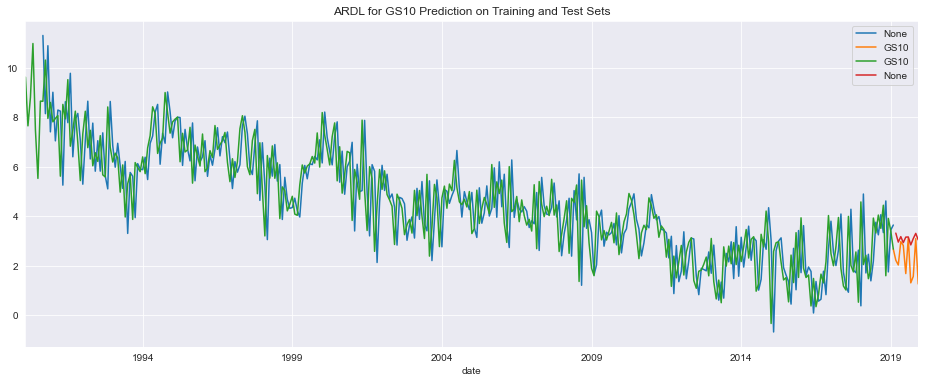

In [719]:
ardl_GS10_fittedvalues.plot() 
test_ARDL['GS10'].plot()
train_ARDL['GS10'].plot()
df_GS10_forecast_level_test_ardl.plot() 
plt.legend()
plt.title('ARDL for GS10 Prediction on Training and Test Sets')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'ARDL for GS10_D1 Prediction on Training and Test Sets')

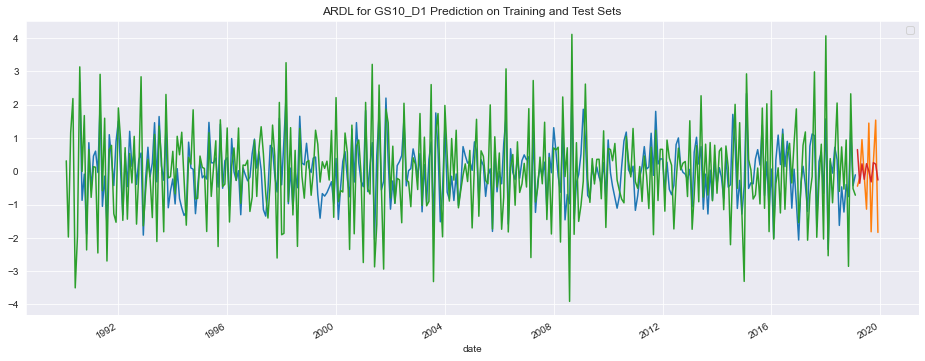

In [720]:
ardl_GS10_D1_result.plot_predict(dynamic = False) 

test['GS10_D1'].plot()
train['GS10_D1'].plot()
ardl_GS10_D1_fc.plot() 
plt.title('ARDL for GS10_D1 Prediction on Training and Test Sets')

Text(0.5, 1.0, 'ARDL for EXUSUKx Prediction on Training and Test Sets')

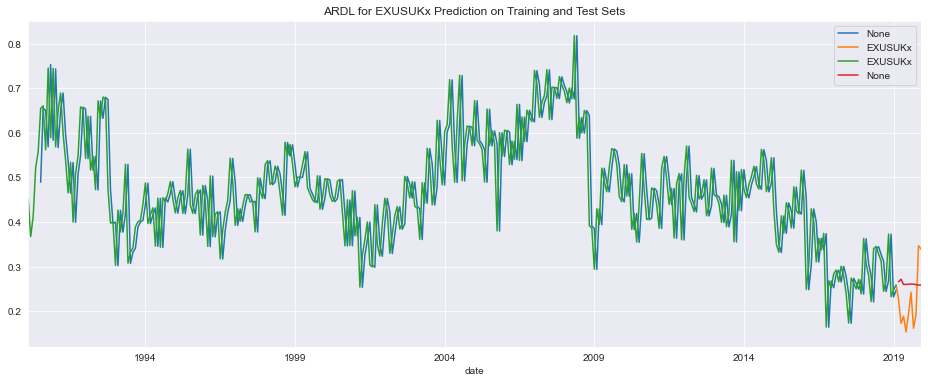

In [721]:
ardl_EXUSUKx_fittedvalues.plot() 
test_ARDL['EXUSUKx'].plot()
train_ARDL['EXUSUKx'].plot()
df_EXUSUKx_forecast_level_test_ardl.plot() 
plt.legend()
plt.title('ARDL for EXUSUKx Prediction on Training and Test Sets')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'ARDL for EXUSUKx_D1 Prediction on Training and Test Sets')

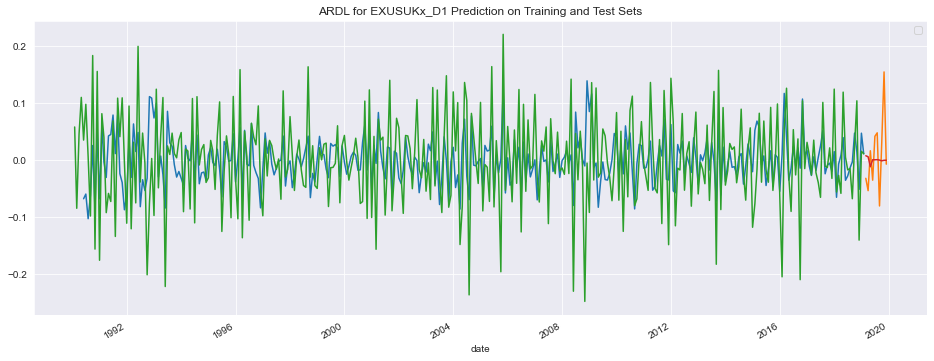

In [722]:
ardl_EXUSUKx_D1_result.plot_predict(dynamic = False) 

test['EXUSUKx_D1'].plot()
train['EXUSUKx_D1'].plot()
ardl_EXUSUKx_D1_fc.plot() 
plt.title('ARDL for EXUSUKx_D1 Prediction on Training and Test Sets')

Text(0.5, 1.0, 'ARDL for USCONS Prediction on Training and Test Sets')

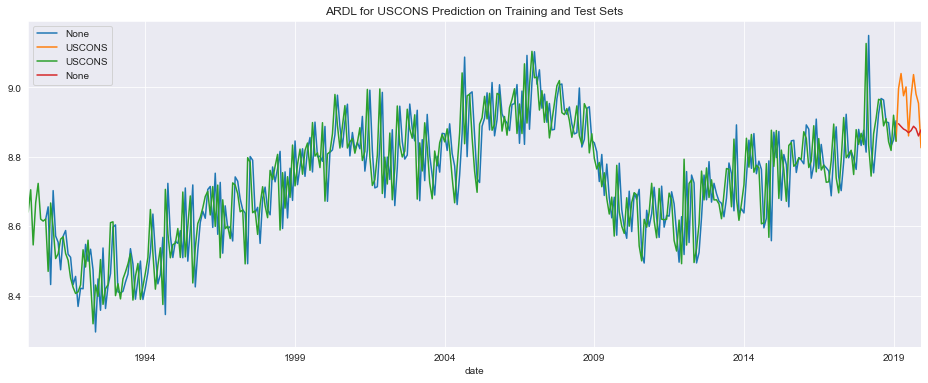

In [723]:
ardl_USCONS_fittedvalues.plot() 
test_ARDL['USCONS'].plot()
train_ARDL['USCONS'].plot()
df_USCONS_forecast_level_test_ardl.plot() 
plt.legend()
plt.title('ARDL for USCONS Prediction on Training and Test Sets')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'ARDL for USCONS_D1 Prediction on Training and Test Sets')

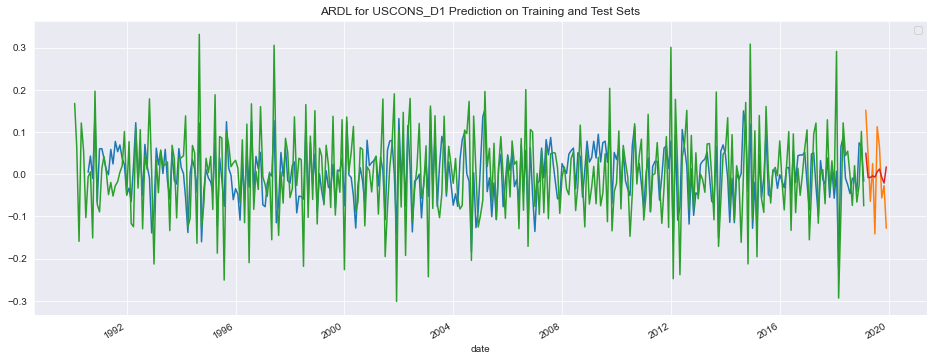

In [724]:
ardl_USCONS_D1_result.plot_predict(dynamic = False) 

test['USCONS_D1'].plot()
train['USCONS_D1'].plot()
ardl_USCONS_D1_fc.plot() 
plt.title('ARDL for USCONS_D1 Prediction on Training and Test Sets')

### Model Diagnosis 

#### Residual Analysis

<AxesSubplot:ylabel='Density'>

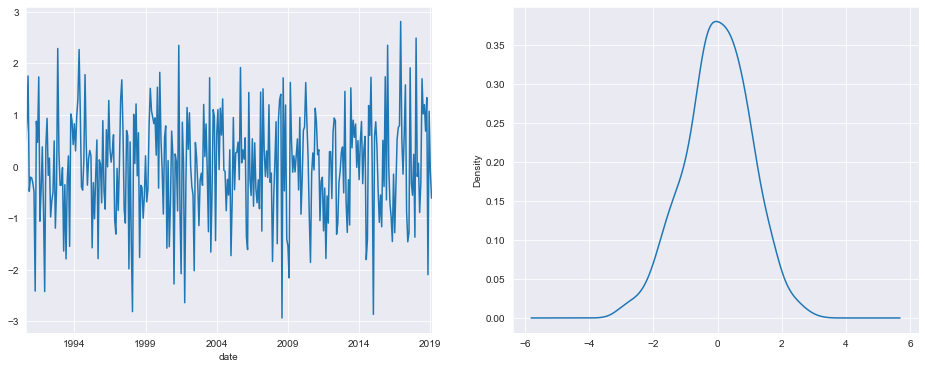

In [725]:
ardl_GS10_D1_res = ardl_GS10_D1_result.resid 

fix, ax = plt.subplots(1,2) 
ardl_GS10_D1_res.plot(ax=ax[0]) 
ardl_GS10_D1_res.plot( kind='kde', ax=ax[1])  

Text(0.5, 0.98, 'GS10_D1 Diagnostics')

<Figure size 1152x648 with 0 Axes>

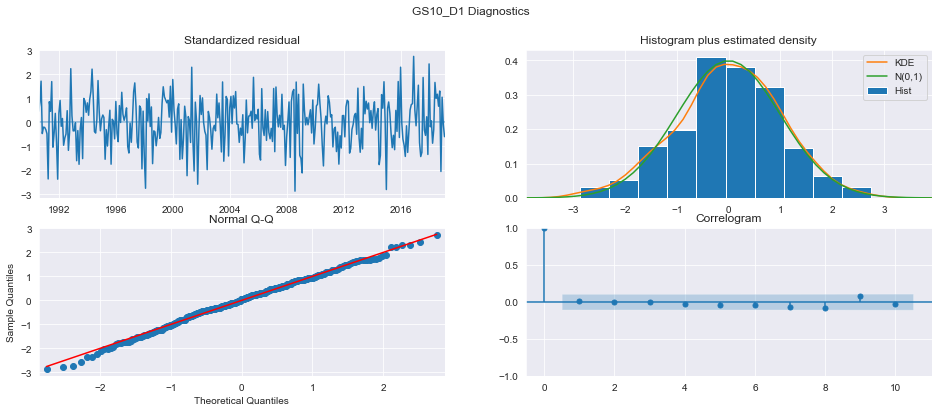

In [726]:
fig = plt.figure(figsize=(16,9))
fig = ardl_GS10_D1_result.plot_diagnostics()
fig.suptitle('GS10_D1 Diagnostics')

<AxesSubplot:ylabel='Density'>

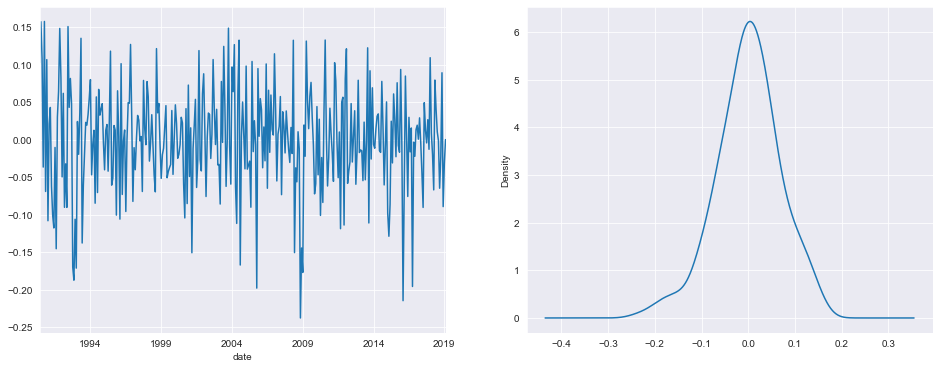

In [727]:
ardl_EXUSUKx_D1_res = ardl_EXUSUKx_D1_result.resid 

fix, ax = plt.subplots(1,2) 
ardl_EXUSUKx_D1_res.plot(ax=ax[0]) 
ardl_EXUSUKx_D1_res.plot( kind='kde', ax=ax[1])  

Text(0.5, 0.98, 'EXUSUKx_D1 Diagnostics')

<Figure size 1152x648 with 0 Axes>

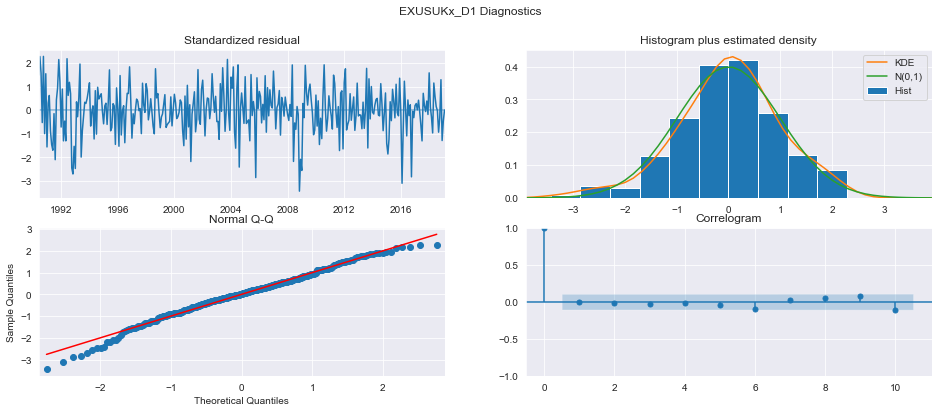

In [728]:
fig = plt.figure(figsize=(16,9))
fig = ardl_EXUSUKx_D1_result.plot_diagnostics()
fig.suptitle('EXUSUKx_D1 Diagnostics')

<AxesSubplot:ylabel='Density'>

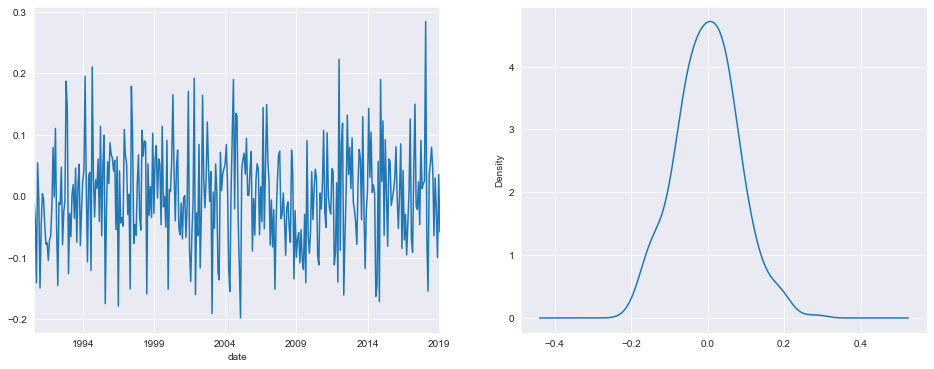

In [729]:
ardl_USCONS_D1_res = ardl_USCONS_D1_result.resid 

fix, ax = plt.subplots(1,2) 
ardl_USCONS_D1_res.plot(ax=ax[0]) 
ardl_USCONS_D1_res.plot( kind='kde', ax=ax[1])

Text(0.5, 0.98, 'USCONS_D1 Diagnostics')

<Figure size 1152x648 with 0 Axes>

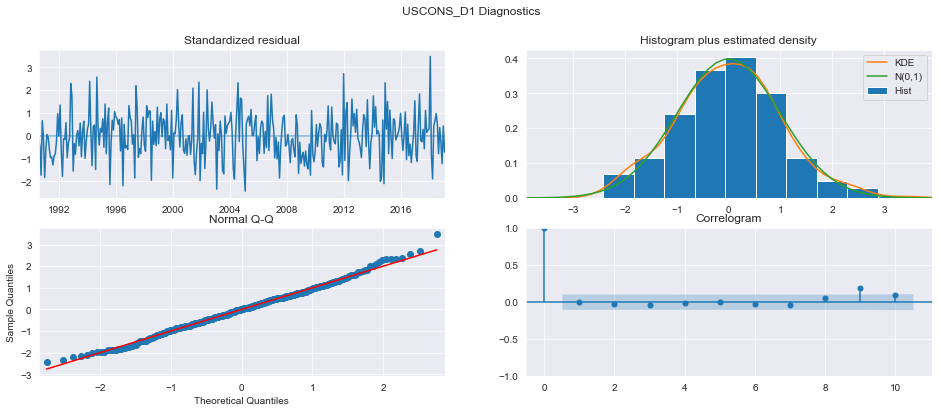

In [730]:
fig = plt.figure(figsize=(16,9))
fig = ardl_USCONS_D1_result.plot_diagnostics()
fig.suptitle('USCONS_D1 Diagnostics')

### Forecast Performance

In [731]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # Mean Asolute Percentage Error
    me = np.mean(forecast - actual)                           # Mean Error
    mae = np.mean(np.abs(forecast - actual))                  # Mean Absolute Error
    mpe = np.mean((forecast - actual)/actual)                 # Mean Percentage Error
    rmse = np.mean((forecast - actual)**2)**.5                # Root-Mean Square Error
    corr = np.corrcoef(forecast, actual)[0,1]                 # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)                           # minmax`
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [732]:
print('Forecast Accuracy of: GS10')
accuracy_prod = forecast_accuracy(ardl_GS10_D1_fc.values, test['GS10_D1'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: EXUSUKx')
accuracy_prod = forecast_accuracy(ardl_EXUSUKx_D1_fc.values, test['EXUSUKx_D1'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: USCONS')
accuracy_prod = forecast_accuracy(ardl_USCONS_D1_fc.values, test['USCONS_D1'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4)) 

Forecast Accuracy of: GS10
mape :  0.94
me :  0.1783
mae :  0.9274
mpe :  -0.6499
rmse :  1.102
corr :  0.3566
minmax :  -0.1589

Forecast Accuracy of: EXUSUKx
mape :  1.1043
me :  -0.0081
mae :  0.0525
mpe :  -1.1043
rmse :  0.0653
corr :  -0.2665
minmax :  -27.0603

Forecast Accuracy of: USCONS
mape :  0.883
me :  0.0051
mae :  0.0732
mpe :  -0.883
rmse :  0.0853
corr :  0.5039
minmax :  -2.1816


<ipython-input-731-47cf4931b148>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-731-47cf4931b148>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


# Machine Learning

- First we load in deseasonalised data and set up lags and monthly dummy variables
- For each series, we  use a variety of machine-learning techniques, using a grid search to identify the appropriate model 
- these models are then 'stacked' together using a linear regression


In [733]:
df = pd.read_csv('data.csv')

In [734]:
df['date'] = pd.date_range(start='01-JAN-1990', end='01-DEC-2019', freq='MS')

In [735]:
df = df.set_index('date')

In [736]:
names = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']

for i, x in enumerate(names):
    df[x] = (df.index.get_level_values(0).month == i+1).astype(int)

In [737]:
df['MA_GS10'] = df['GS10'].rolling(window=12, center = True).mean()
df['MA_EXUSUKx'] = df['EXUSUKx'].rolling(window=12, center = True).mean()
df['MA_USCONS'] = df['USCONS'].rolling(window=12, center = True).mean()

In [738]:
df['CMA_GS10'] = df['MA_GS10'].rolling(window=2, center = True).mean().shift(-1)
df['CMA_EXUSUKx'] = df['MA_EXUSUKx'].rolling(window=2, center = True).mean().shift(-1)
df['CMA_USCONS'] = df['MA_USCONS'].rolling(window=2, center = True).mean().shift(-1)

In [739]:
df['GS10/CMA_GS10'] = df['GS10']/df['CMA_GS10']
df['EXUSUKx/CMA_EXUSUKx'] = df['EXUSUKx']/df['CMA_EXUSUKx']
df['USCONS/CMA_USCONS'] = df['USCONS']/df['CMA_USCONS']

In [740]:
m1 = sm.OLS(df['GS10/CMA_GS10'], df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']],missing = 'drop')
results_1 = m1.fit()

m2 = sm.OLS(df['EXUSUKx/CMA_EXUSUKx'], df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']],missing = 'drop')
results_2 = m2.fit()

m3 = sm.OLS(df['USCONS/CMA_USCONS'], df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']],missing = 'drop')
results_3 = m3.fit()

In [741]:
df['snbar_GS10'] = results_1.predict(df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']])
df['snbar_EXUSUKx'] = results_2.predict(df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']])
df['snbar_USCONS'] = results_3.predict(df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']])

In [742]:
df1 = df.head(12)

In [743]:
df1['snbar_GS10'].mean()
df1['snbar_EXUSUKx'].mean()
df1['snbar_USCONS'].mean()

0.9999900514249043

In [744]:
df['sn_GS10'] = df['snbar_GS10']/df1['snbar_GS10'].mean()
df['sn_EXUSUKx'] = df['snbar_EXUSUKx']/df1['snbar_EXUSUKx'].mean()
df['sn_USCONS'] = df['snbar_USCONS']/df1['snbar_USCONS'].mean()

In [745]:
df['d_GS10'] = df['GS10']/df['sn_GS10']
df['d_EXUSUKx'] = df['EXUSUKx']/df['sn_EXUSUKx']
df['d_USCONS'] = df['USCONS']/df['sn_USCONS']

In [746]:
df_plot = df[['d_GS10','d_EXUSUKx', 'd_USCONS']] 
 

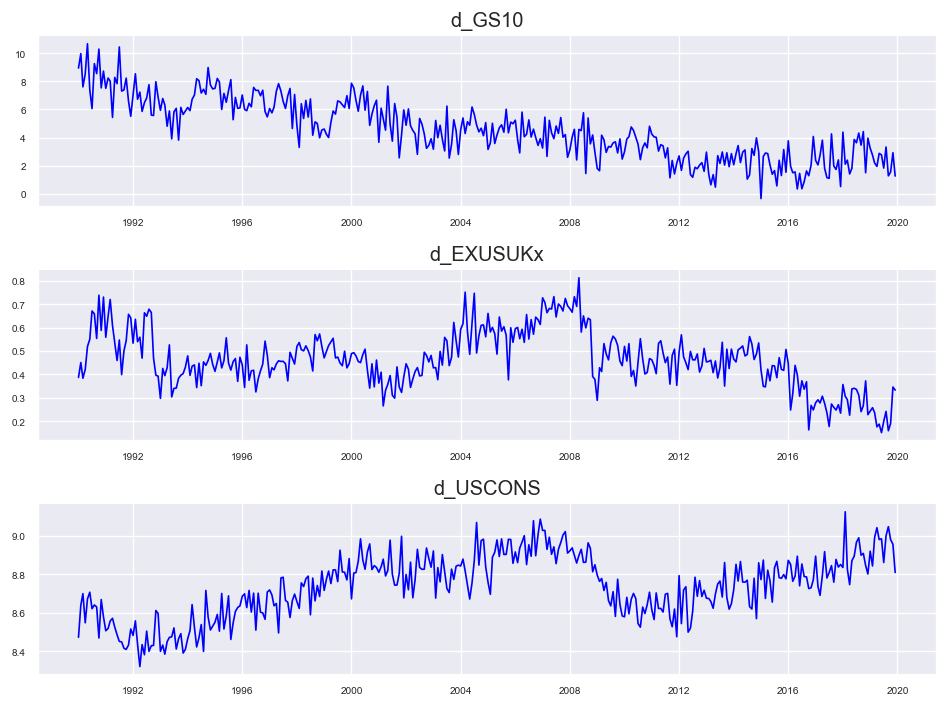

In [747]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(8, 6))
for i, ax in enumerate(axes.flatten()):
    data = df[df_plot.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df_plot.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [748]:
df['EXUSUKx_D1'] = df['EXUSUKx'].diff()
df['USCONS_D1'] = df['USCONS'].diff()
df['GS10_D1'] = df['GS10'].diff()

In [749]:
### Set up targets
df['target_GS10_D1'] = df['GS10_D1'].shift(-1)
df['target_EXUSUKx_D1'] = df['EXUSUKx_D1'].shift(-1)
df['target_USCONS_D1'] = df['USCONS_D1'].shift(-1)

In [750]:
### Set up lags
df['GS10_D1_L1'] = df['GS10_D1'].shift(1)
df['EXUSUKx_D1_L1'] = df['EXUSUKx_D1'].shift(1)
df['USCONS_D1_L1'] = df['USCONS_D1'].shift(1)
df['GS10_D1_L2'] = df['GS10_D1_L1'].shift(1)
df['EXUSUKx_D1_L2'] = df['EXUSUKx_D1_L1'].shift(1)
df['USCONS_D1_L2'] = df['USCONS_D1_L1'].shift(1)
df['GS10_D1_L3'] = df['GS10_D1_L2'].shift(1)
df['EXUSUKx_D1_L3'] = df['EXUSUKx_D1_L2'].shift(1)
df['USCONS_D1_L3'] = df['USCONS_D1_L2'].shift(1)

In [751]:
df = df.dropna(axis = 0)

In [752]:
# Split into training and test set (note training is labelled rest here because it will be further subdivided)
df_test = df.iloc[-10:]
df_rest = df.iloc[:-10]

### Lets do GS10 variable first

In [753]:
y_test_GS10 = df_test.pop('target_GS10_D1')

In [754]:
y_GS10 = df_rest.pop('target_GS10_D1')

In [755]:
X_GS10 = df_rest[['GS10_D1', 'GS10_D1_L1','GS10_D1_L2', 'GS10_D1_L3','m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']]

In [756]:
df_test_GS10 = df_test[['GS10_D1', 'GS10_D1_L1','GS10_D1_L2','GS10_D1_L3','m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']]

### The remaining data before the test set is split 2/3 base-training and 1/3 meta-training sets

In [757]:
c = len(y_GS10)/3

In [758]:
y_meta_GS10 = y_GS10[-int(c):]
y_base_GS10 = y_GS10[:-int(c)]

In [759]:
X_meta_GS10 = X_GS10[-int(c):]
X_base_GS10 = X_GS10[:-int(c)]

### Models

In [760]:
time_split_inner = TimeSeriesSplit(n_splits = 3)

#### GridsearchCV : Lasso Regression

In [761]:
lasso = Lasso(fit_intercept=1, alpha=0.05, max_iter=10000, random_state=0)

las_params = {'fit_intercept': [1, 0],
              'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1]}

In [762]:
gs_las = GridSearchCV(lasso, las_params, cv=time_split_inner, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_las.fit(X_base_GS10, y_base_GS10)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Lasso(alpha=0.05, fit_intercept=1, max_iter=10000,
                             random_state=0),
             n_jobs=-1,
             param_grid={'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1],
                         'fit_intercept': [1, 0]},
             scoring='neg_mean_squared_error', verbose=1)

#### GridsearchCV : two-Layer neural network

In [763]:
mlp = MLPRegressor(hidden_layer_sizes=(24,), alpha=1e-6, activation='relu', early_stopping=True, max_iter=20000, random_state=0)

mlp_params = {'hidden_layer_sizes': [(24,), (36,), (24,24), (24,12), (36,24), (36,12)], 
              'alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
              'activation': ['relu', 'identity', 'tanh']}

In [764]:
gs_mlp = GridSearchCV(mlp, mlp_params, cv=time_split_inner, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_mlp.fit(X_base_GS10, y_base_GS10)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=MLPRegressor(alpha=1e-06, early_stopping=True,
                                    hidden_layer_sizes=(24,), max_iter=20000,
                                    random_state=0),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'tanh'],
                         'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001],
                         'hidden_layer_sizes': [(24,), (36,), (24, 24),
                                                (24, 12), (36, 24), (36, 12)]},
             scoring='neg_mean_squared_error', verbose=1)

#### GridsearchCV : Random Forest

In [765]:
rf = RandomForestRegressor(n_estimators=400, min_samples_split=3, max_features='sqrt', random_state=0)

rf_params = {'n_estimators': range(300, 500, 25),
             'min_samples_split': [2, 3, 4, 5, 6, 7],
             'max_features': ['log2', 'sqrt']}

In [766]:
gs_rf = GridSearchCV(rf, rf_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                     n_jobs=-1, verbose=1)

gs_rf.fit(X_base_GS10, y_base_GS10)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(max_features='sqrt',
                                             min_samples_split=3,
                                             n_estimators=400, random_state=0),
             n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'min_samples_split': [2, 3, 4, 5, 6, 7],
                         'n_estimators': range(300, 500, 25)},
             scoring='neg_mean_squared_error', verbose=1)

#### GridsearchCV : XGBoost

In [767]:
### this is just here to ensure an error doesn't occour when running code
import xgboost           as xgb

In [768]:
xgb = xgb.XGBRegressor(n_estimators=100, gamma=200, eta=0.1, subsample=1, objective='reg:squarederror', random_state=0)

xgb_params = {'n_estimators': range(70, 140, 10),
              'subsample': [0.5, 0.75, 1],
              'eta': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
              'gamma': range(150, 160, 10)}

In [769]:
gs_xgb = GridSearchCV(xgb, xgb_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=1)

gs_xgb.fit(X_base_GS10, y_base_GS10)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.1,
                                    eval_metric=None, gamma=200, gpu_id=None,
                                    grow_policy=None, importance_type...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=0,
 

#### Linear Support Vector Regression

In [770]:
svr = LinearSVR(epsilon=10, C=35, fit_intercept=True, loss='squared_epsilon_insensitive', 
                max_iter=30000, random_state=8)

svr_params = {'epsilon': [8, 9, 10, 11, 12, 13, 14],
              'fit_intercept': [0, 1],
              'C': [33, 34, 35, 36, 37, 38, 39, 40, 41]}

In [771]:
gs_svr = GridSearchCV(svr, svr_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_svr.fit(X_base_GS10, y_base_GS10)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LinearSVR(C=35, epsilon=10,
                                 loss='squared_epsilon_insensitive',
                                 max_iter=30000, random_state=8),
             n_jobs=-1,
             param_grid={'C': [33, 34, 35, 36, 37, 38, 39, 40, 41],
                         'epsilon': [8, 9, 10, 11, 12, 13, 14],
                         'fit_intercept': [0, 1]},
             scoring='neg_mean_squared_error', verbose=1)

#### Support Vector Machine

In [772]:
svm = SVR(kernel='rbf', gamma='auto', C=0.1, max_iter=30000)

svm_params = {'kernel': ['rbf', 'sigmoid', 'poly'],
              'gamma': ['scale', 'auto', 0.2], 
              'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]}

In [773]:
gs_svm = GridSearchCV(svm, svm_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_svm.fit(X_base_GS10, y_base_GS10)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=SVR(C=0.1, gamma='auto', max_iter=30000), n_jobs=-1,
             param_grid={'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'gamma': ['scale', 'auto', 0.2],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             scoring='neg_mean_squared_error', verbose=1)

# Training & Meta Model

In [774]:
est_meta = pd.DataFrame(y_meta_GS10)

### The predictions of the base models on the meta-training set, which will be used to train the meta model

In [775]:
est_meta['las_pred'] = gs_las.predict(X_meta_GS10)
est_meta['mlp_pred'] = gs_mlp.predict(X_meta_GS10)
est_meta['rf_pred'] = gs_rf.predict(X_meta_GS10)
est_meta['xgb_pred'] = gs_xgb.predict(X_meta_GS10)
est_meta['svr_pred'] = gs_svr.predict(X_meta_GS10)
est_meta['svm_pred'] = gs_svm.predict(X_meta_GS10)

In [776]:
y_meta_GS10 = est_meta.pop('target_GS10_D1')

### Setting Linear Regression as the final stage meta model

In [777]:
meta = LinearRegression()

### Fitting the meta model to the predictions of the base models on the meta-training set, and y_meta

In [778]:
meta.fit(est_meta, y_meta_GS10)

LinearRegression()

In [779]:
meta.coef_

array([ 1.07135952,  0.13906653, -0.14528632,  0.        ,  0.        ,
       -0.26159769])

# Predicting the test Data

### The base (first stage) and meta models are not retrained before making predictions on the test set.

In [780]:
y_test_GS10

date
2018-09-01    0.936511
2018-10-01   -2.855735
2018-11-01    2.321612
2018-12-01   -0.523467
2019-01-01   -0.720049
2019-02-01   -0.450467
2019-03-01   -0.192684
2019-04-01    0.946796
2019-05-01   -0.155158
2019-06-01   -1.139198
Name: target_GS10_D1, dtype: float64

# Analytical Functions for Evaluations

In [781]:
def reg_scoring(X, y, meta, reg_dict):
    
    test1_scores = []
    test2_scores = []
    
    df_pred = pd.DataFrame(columns=reg_dict.keys()) # Columns of DF will accord with reg_dict keys
    
    # Loop through Dictionary items
    for key, reg in reg_dict.items():
        
        pred_y = reg.predict(X)
        df_pred[key] = pd.Series(pred_y).transpose()
        
        # Computing test scores for each model
        test1_scores.append(round(mean_absolute_error(y, pred_y), 4))
        test2_scores.append(round(mean_squared_error(y, pred_y, squared=False), 4))
        
    # Generate results DataFrame
    results = pd.DataFrame({'Model': list(reg_dict.keys()), 
                            'Mean Absolute Error': test1_scores,
                            'Root Mean Squared Error': test2_scores
                            })

    # Generate Stack Model's predictions, and test scores
    df_pred['Stack Model'] = meta.predict(df_pred) # Adding 'Stack Model' to DataFrame of predictions
    
    s1 = round(mean_absolute_error(y, df_pred['Stack Model']), 4)
    s2 = round(mean_squared_error(y, df_pred['Stack Model'], squared=False), 4)
    
    
    # Add target variable to the DataFrame of predictions
    df_pred['Target'] = y.tolist()
        
        
    # Inserting the Stack scores to the results DataFrame
    row1 = ['Stack Model', s1, s2]
    results.loc[len(results)] = row1
    
    return results, df_pred

In [782]:
def residual_plot(res):

    # Standardizing residual values
    resid_standard = (res - res.mean()) / res.std()
    
    # Generate 2X2 chart plots
    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

    ax[0, 0].plot(res)
    ax[0, 0].axhline(res.mean(), color='grey')
    ax[0, 0].set_title('Residuals')

    plot_acf(resid_standard, title='Correlogram', ax=ax[0, 1])

    sm.graphics.qqplot(res, line='45', fit=True, ax=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(res.min(), res.max(), 1000)
    norm = stats.norm(loc=0, scale=res.std())
    sns.distplot(res, ax=ax[1, 1], label='kde estimate')
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')

    plt.show()

In [783]:
reg_dict = {
    'Lasso Regression': gs_las,
    'Multi-Layer Perceptron': gs_mlp, 
    'Random Forest': gs_rf,
    'XG Boost': gs_xgb,
    'Support Vector Regression' : gs_svr,
    'Support Vector Machine' : gs_svm
}

# Comparative Test Scores & Plots

In [784]:
scores, df_pred = reg_scoring(df_test_GS10, y_test_GS10, meta, reg_dict)

In [785]:
scores

Model  Mean Absolute Error  Root Mean Squared Error
0           Lasso Regression               0.7328                   0.9348
1     Multi-Layer Perceptron               0.8251                   1.0453
2              Random Forest               0.9165                   1.0997
3                   XG Boost               1.0074                   1.3243
4  Support Vector Regression               1.0242                   1.3294
5     Support Vector Machine               0.8201                   1.0097
6                Stack Model               0.7319                   0.9755

In [786]:
r2_score(df_pred['Target'],df_pred['Lasso Regression'])

0.49602148623003817

In [788]:
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [789]:
r_squared(df_pred['Target'],df_pred['Lasso Regression'])

0.49602148623003817

### The Laso Regression has the lowest (and best) RMSE scores of all the models and second best MAE to the stacked model

In [790]:
gs_las.best_params_

{'alpha': 0.03, 'fit_intercept': 1}

In [791]:
lasso = linear_model.Lasso(alpha=0.03, fit_intercept = 1)

In [792]:
lasso.fit(X_base_GS10,y_base_GS10)

Lasso(alpha=0.03, fit_intercept=1)

In [793]:
print(lasso.coef_)

[-0.75722662 -0.50863661 -0.24245178 -0.08657434 -0.          0.
  0.          0.25204574  0.          0.         -0.03504988  0.
  0.          0.         -0.         -0.        ]


In [794]:
print(lasso.intercept_)

-0.06627646002106732


In [795]:
lasso.get_params(deep=True)

{'alpha': 0.03,
 'copy_X': True,
 'fit_intercept': 1,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [796]:
df_test_actuals_GS10 = df_test["GS10"].iloc[-10:]
df_test_actuals_EXUSUKx = df_test["EXUSUKx"].iloc[-10:]
df_test_actuals_USCONS = df_test["USCONS"].iloc[-10:]

### Lets transform the series back to level

In [797]:
df_GS10_differenced_Forecast = df_pred[['Target', "Lasso Regression"]]

In [798]:
df_GS10_differenced_Forecast['date'] = pd.date_range(start= '01-SEP-2018', end= '01-JUN-2019', freq='MS')

<ipython-input-798-9f1170425e9d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GS10_differenced_Forecast['date'] = pd.date_range(start= '01-SEP-2018', end= '01-JUN-2019', freq='MS')


In [799]:
df_GS10_differenced_Forecast = df_GS10_differenced_Forecast.set_index('date')

In [800]:
df_GS10_differenced_Forecast.head(12)

Target  Lasso Regression
date                                  
2018-09-01  0.936511         -0.059175
2018-10-01 -2.855735         -0.625684
2018-11-01  2.321612          1.687299
2018-12-01 -0.523467         -0.552181
2019-01-01 -0.720049         -0.239450
2019-02-01 -0.450467          0.429572
2019-03-01 -0.192684          0.566995
2019-04-01  0.946796          0.780694
2019-05-01 -0.155158         -0.513655
2019-06-01 -1.139198         -0.344646

In [801]:
df_GS10_level_Forecast = df_GS10_differenced_Forecast

In [802]:
df_GS10_level_Forecast['Target'] = df_GS10_differenced_Forecast['Target'] + df_test_actuals_GS10
df_GS10_level_Forecast["Lasso Regression"] = df_GS10_differenced_Forecast["Lasso Regression"] + df_test_actuals_GS10

In [803]:
df_GS10_level_Forecast_sn = df_GS10_level_Forecast

In [804]:
df_GS10_level_Forecast_sn['Target'] = df_GS10_level_Forecast['Target'] * df['sn_GS10'].tail(10)
df_GS10_level_Forecast_sn["Lasso Regression"] = df_GS10_level_Forecast["Lasso Regression"] * df['sn_GS10'].tail(10)

In [805]:
df_GS10_level_Forecast.head(10)

Target  Lasso Regression
date                                  
2018-09-01  4.498132          3.489997
2018-10-01  1.591532          3.828157
2018-11-01  4.129446          3.459269
2018-12-01  3.339101          3.310777
2019-01-01  2.778027          3.279017
2019-02-01  2.140313          2.990876
2019-03-01  2.036268          2.801384
2019-04-01  3.068491          2.896800
2019-05-01  2.898495          2.529160
2019-06-01  1.697075          2.502462

In [806]:
df_GS10_level_Forecast_sn.head(10)

Target  Lasso Regression
date                                  
2018-09-01  4.498132          3.489997
2018-10-01  1.591532          3.828157
2018-11-01  4.129446          3.459269
2018-12-01  3.339101          3.310777
2019-01-01  2.778027          3.279017
2019-02-01  2.140313          2.990876
2019-03-01  2.036268          2.801384
2019-04-01  3.068491          2.896800
2019-05-01  2.898495          2.529160
2019-06-01  1.697075          2.502462

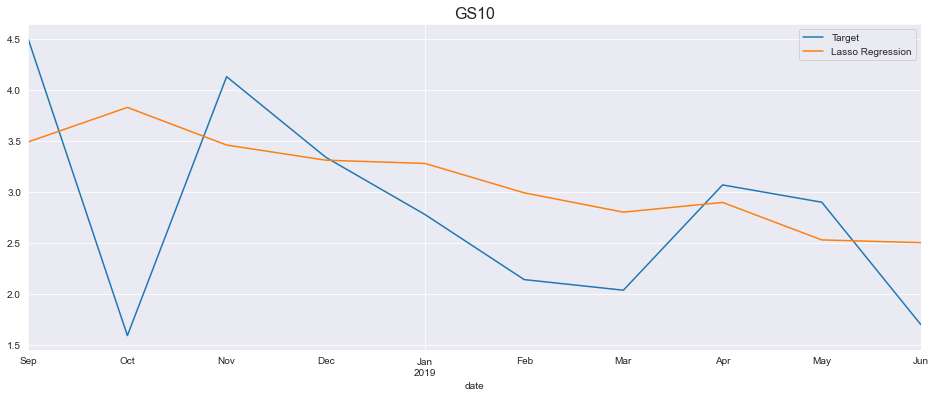

In [807]:
df_GS10_level_Forecast_sn['Target'].plot()
df_GS10_level_Forecast_sn['Lasso Regression'].plot()
plt.title('GS10', fontsize=16)
plt.legend()
plt.show()

In [808]:
df_pred.index = df_test.index

### now let's plot forecast on the test data

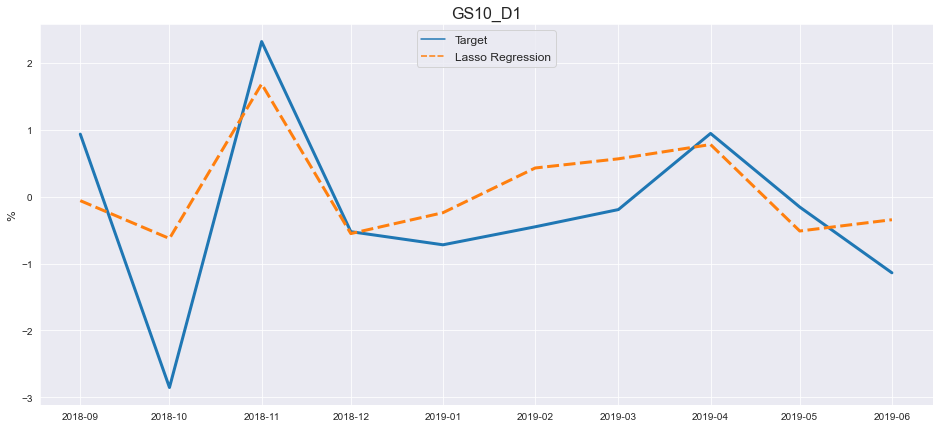

In [809]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'Lasso Regression']], ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('GS10_D1', fontsize=16)
plt.xlabel('')
plt.ylabel('%', fontsize=12);

In [810]:
residual = df_pred['Target'] - df_pred['Lasso Regression']

C:\Users\Micha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


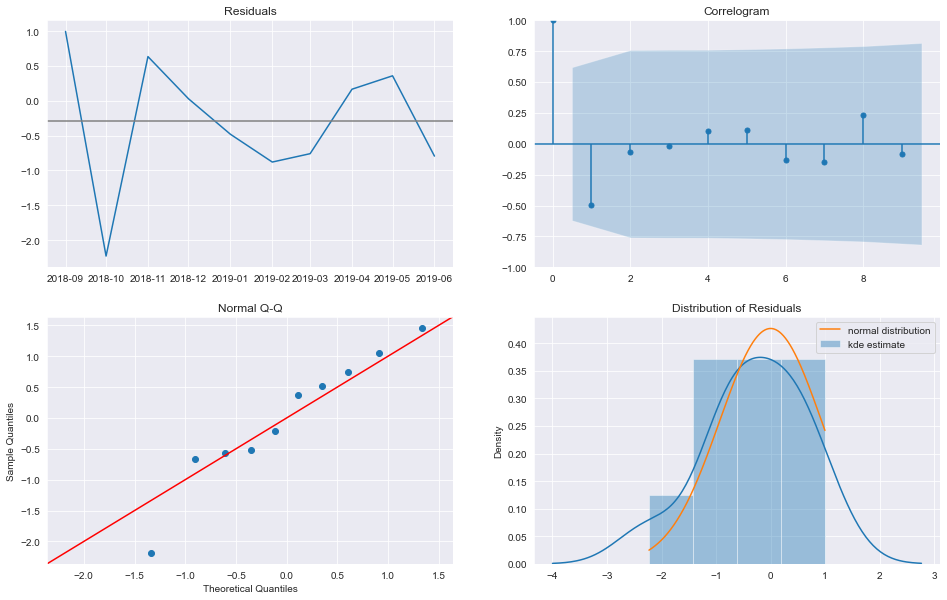

In [811]:
residual_plot(residual)

### Lets do EXUSUKx variable Second

In [812]:
y_test_EXUSUKx = df_test.pop('target_EXUSUKx_D1')

In [813]:
y_EXUSUKx = df_rest.pop('target_EXUSUKx_D1')

In [814]:
X_EXUSUKx = df_rest[['EXUSUKx_D1', 'EXUSUKx_D1_L1','EXUSUKx_D1_L2', 'EXUSUKx_D1_L3','m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']]

In [815]:
df_test_EXUSUKx = df_test[['EXUSUKx_D1', 'EXUSUKx_D1_L1','EXUSUKx_D1_L2', 'EXUSUKx_D1_L3','m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']]

### The remaining data before the test set is split 2/3 base-training and 1/3 meta-training sets

In [816]:
c = len(y_EXUSUKx)/3

In [817]:
y_meta_EXUSUKx = y_EXUSUKx[-int(c):]
y_base_EXUSUKx = y_EXUSUKx[:-int(c)]

In [818]:
X_meta_EXUSUKx = X_EXUSUKx[-int(c):]
X_base_EXUSUKx = X_EXUSUKx[:-int(c)]

### Models

#### GridsearchCV : Lasso Regression EXUSUKx

In [819]:
gs_las = GridSearchCV(lasso, las_params, cv=time_split_inner, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_las.fit(X_base_EXUSUKx, y_base_EXUSUKx)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Lasso(alpha=0.03, fit_intercept=1), n_jobs=-1,
             param_grid={'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1],
                         'fit_intercept': [1, 0]},
             scoring='neg_mean_squared_error', verbose=1)

#### GridsearchCV : two-Layer neural network EXUSUKx

In [820]:
gs_mlp = GridSearchCV(mlp, mlp_params, cv=time_split_inner, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_mlp.fit(X_base_EXUSUKx, y_base_EXUSUKx)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=MLPRegressor(alpha=1e-06, early_stopping=True,
                                    hidden_layer_sizes=(24,), max_iter=20000,
                                    random_state=0),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'tanh'],
                         'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001],
                         'hidden_layer_sizes': [(24,), (36,), (24, 24),
                                                (24, 12), (36, 24), (36, 12)]},
             scoring='neg_mean_squared_error', verbose=1)

#### GridsearchCV : Random Forest EXUSUKx

In [821]:
gs_rf = GridSearchCV(rf, rf_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                     n_jobs=-1, verbose=1)

gs_rf.fit(X_base_EXUSUKx, y_base_EXUSUKx)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(max_features='sqrt',
                                             min_samples_split=3,
                                             n_estimators=400, random_state=0),
             n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'min_samples_split': [2, 3, 4, 5, 6, 7],
                         'n_estimators': range(300, 500, 25)},
             scoring='neg_mean_squared_error', verbose=1)

#### GridsearchCV : XGBoost EXUSUKx

In [822]:
### this is just here to ensure an error doesn't occour when running code
import xgboost           as xgb

In [823]:
xgb = xgb.XGBRegressor(n_estimators=100, gamma=200, eta=0.1, subsample=1, objective='reg:squarederror', random_state=0)

xgb_params = {'n_estimators': range(70, 140, 10),
              'subsample': [0.5, 0.75, 1],
              'eta': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
              'gamma': range(150, 160, 10)}

In [824]:
gs_xgb = GridSearchCV(xgb, xgb_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=1)

gs_xgb.fit(X_base_EXUSUKx, y_base_EXUSUKx)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.1,
                                    eval_metric=None, gamma=200, gpu_id=None,
                                    grow_policy=None, importance_type...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=0,
 

#### Linear Support Vector Regression

In [825]:
gs_svr = GridSearchCV(svr, svr_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_svr.fit(X_base_EXUSUKx, y_base_EXUSUKx)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LinearSVR(C=35, epsilon=10,
                                 loss='squared_epsilon_insensitive',
                                 max_iter=30000, random_state=8),
             n_jobs=-1,
             param_grid={'C': [33, 34, 35, 36, 37, 38, 39, 40, 41],
                         'epsilon': [8, 9, 10, 11, 12, 13, 14],
                         'fit_intercept': [0, 1]},
             scoring='neg_mean_squared_error', verbose=1)

#### Support Vector Machine

In [826]:
gs_svm = GridSearchCV(svm, svm_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_svm.fit(X_base_EXUSUKx, y_base_EXUSUKx)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=SVR(C=0.1, gamma='auto', max_iter=30000), n_jobs=-1,
             param_grid={'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'gamma': ['scale', 'auto', 0.2],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             scoring='neg_mean_squared_error', verbose=1)

###### check the optimal parameters for each model

# Training & Meta Model

In [827]:
est_meta = pd.DataFrame(y_meta_EXUSUKx)

In [828]:
est_meta['las_pred'] = gs_las.predict(X_meta_EXUSUKx)
est_meta['mlp_pred'] = gs_mlp.predict(X_meta_EXUSUKx)
est_meta['rf_pred'] = gs_rf.predict(X_meta_EXUSUKx)
est_meta['xgb_pred'] = gs_xgb.predict(X_meta_EXUSUKx)
est_meta['svr_pred'] = gs_svr.predict(X_meta_EXUSUKx)
est_meta['svm_pred'] = gs_svm.predict(X_meta_EXUSUKx)

In [829]:
y_meta_EXUSUKx = est_meta.pop('target_EXUSUKx_D1')

###### Linear Regression as final stage

In [830]:
meta = LinearRegression()

In [831]:
meta.fit(est_meta, y_meta_EXUSUKx)

LinearRegression()

### Predictions on test data

In [832]:
y_test_EXUSUKx

date
2018-09-01    0.024618
2018-10-01    0.103687
2018-11-01   -0.140526
2018-12-01    0.015182
2019-01-01    0.010978
2019-02-01   -0.032163
2019-03-01   -0.053775
2019-04-01    0.016160
2019-05-01   -0.035403
2019-06-01    0.041491
Name: target_EXUSUKx_D1, dtype: float64

In [833]:
def reg_scoring(X, y_EXUSUKx, meta, reg_dict):
    
    test1_scores = []
    test2_scores = []
    
    df_pred = pd.DataFrame(columns=reg_dict.keys()) # Columns of DF will accord with reg_dict keys
    
    # Loop through Dictionary items
    for key, reg in reg_dict.items():
        
        pred_y = reg.predict(X)
        df_pred[key] = pd.Series(pred_y).transpose()
        
        # Computing test scores for each model
        test1_scores.append(round(mean_absolute_error(y_EXUSUKx, pred_y), 4))
        test2_scores.append(round(mean_squared_error(y_EXUSUKx, pred_y, squared=False), 4))
        
    # Generate results DataFrame
    results = pd.DataFrame({'Model': list(reg_dict.keys()), 
                            'Mean Absolute Error': test1_scores,
                            'Root Mean Squared Error': test2_scores
                            })

    # Generate Stack Model's predictions, and test scores
    df_pred['Stack Model'] = meta.predict(df_pred) # Adding 'Stack Model' to DataFrame of predictions
    
    s1 = round(mean_absolute_error(y_EXUSUKx, df_pred['Stack Model']), 4)
    s2 = round(mean_squared_error(y_EXUSUKx, df_pred['Stack Model'], squared=False), 4)
    
    
    # Add target variable to the DataFrame of predictions
    df_pred['Target_EXUSUKx'] = y_EXUSUKx.tolist()
        
        
    # Inserting the Stack scores to the results DataFrame
    row1 = ['Stack Model', s1, s2]
    results.loc[len(results)] = row1
    
    return results, df_pred

In [834]:
reg_dict = {
    'Lasso Regression': gs_las,
    'Multi-Layer Perceptron': gs_mlp, 
    'Random Forest': gs_rf,
    'XG Boost': gs_xgb,
    'Support Vector Regression' : gs_svr,
    'Support Vector Machine' : gs_svm
}

### Comparative Test Scores

In [835]:
meta.score(est_meta,y_meta_EXUSUKx, sample_weight=None)

0.08916089469016031

In [836]:
scores, df_pred = reg_scoring(df_test_EXUSUKx, y_test_EXUSUKx, meta, reg_dict)

In [837]:
scores

Model  Mean Absolute Error  Root Mean Squared Error
0           Lasso Regression               0.0474                   0.0621
1     Multi-Layer Perceptron               0.0571                   0.0764
2              Random Forest               0.0531                   0.0653
3                   XG Boost               0.0474                   0.0621
4  Support Vector Regression               0.0474                   0.0621
5     Support Vector Machine               0.0478                   0.0610
6                Stack Model               0.0463                   0.0593

### The Stacked model has the lowest MAE and RSME

In [838]:
r2_score(df_pred['Target_EXUSUKx'],df_pred['Stack Model'])

0.08314566196981232

In [839]:
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [840]:
meta.coef_

array([ 0.        , -0.13726504,  0.66010871,  0.        ,  0.        ,
        0.13935568])

### Lets transform the series back to level

In [841]:
df_EXUSUKx_differenced_Forecast = df_pred[['Target_EXUSUKx', "Stack Model"]]

In [842]:
df_EXUSUKx_differenced_Forecast['date'] = pd.date_range(start= '01-SEP-2018', end= '01-JUN-2019', freq='MS')

<ipython-input-842-e15c1098790e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_EXUSUKx_differenced_Forecast['date'] = pd.date_range(start= '01-SEP-2018', end= '01-JUN-2019', freq='MS')


In [843]:
df_EXUSUKx_differenced_Forecast = df_EXUSUKx_differenced_Forecast.set_index('date')

In [844]:
df_EXUSUKx_differenced_Forecast.head(12)

Target_EXUSUKx  Stack Model
date                                   
2018-09-01        0.024618     0.068095
2018-10-01        0.103687    -0.015657
2018-11-01       -0.140526    -0.037361
2018-12-01        0.015182     0.013991
2019-01-01        0.010978    -0.001248
2019-02-01       -0.032163     0.010344
2019-03-01       -0.053775     0.008678
2019-04-01        0.016160     0.026699
2019-05-01       -0.035403     0.006654
2019-06-01        0.041491     0.015687

In [845]:
df_EXUSUKx_level_Forecast = df_EXUSUKx_differenced_Forecast

In [846]:
df_EXUSUKx_level_Forecast['Target_EXUSUKx'] = df_EXUSUKx_differenced_Forecast['Target_EXUSUKx'] + df_test_actuals_EXUSUKx
df_EXUSUKx_level_Forecast["Stack Model"] = df_EXUSUKx_differenced_Forecast["Stack Model"] + df_test_actuals_EXUSUKx

In [847]:
df_EXUSUKx_level_Forecast_sn = df_EXUSUKx_level_Forecast

In [848]:
df_EXUSUKx_level_Forecast_sn['Target_EXUSUKx'] = df_EXUSUKx_level_Forecast['Target_EXUSUKx'] * df['sn_EXUSUKx'].tail(10)
df_EXUSUKx_level_Forecast_sn["Stack Model"] = df_EXUSUKx_level_Forecast["Stack Model"] * df['sn_EXUSUKx'].tail(10)

In [849]:
df_EXUSUKx_level_Forecast.head(10)

Target_EXUSUKx  Stack Model
date                                   
2018-09-01        0.273386     0.317532
2018-10-01        0.376443     0.255975
2018-11-01        0.232816     0.336164
2018-12-01        0.252274     0.251060
2019-01-01        0.263089     0.250649
2019-02-01        0.227009     0.269630
2019-03-01        0.165213     0.224985
2019-04-01        0.184983     0.195311
2019-05-01        0.154375     0.196703
2019-06-01        0.197339     0.171210

In [850]:
df_EXUSUKx_level_Forecast_sn.head(10)

Target_EXUSUKx  Stack Model
date                                   
2018-09-01        0.273386     0.317532
2018-10-01        0.376443     0.255975
2018-11-01        0.232816     0.336164
2018-12-01        0.252274     0.251060
2019-01-01        0.263089     0.250649
2019-02-01        0.227009     0.269630
2019-03-01        0.165213     0.224985
2019-04-01        0.184983     0.195311
2019-05-01        0.154375     0.196703
2019-06-01        0.197339     0.171210

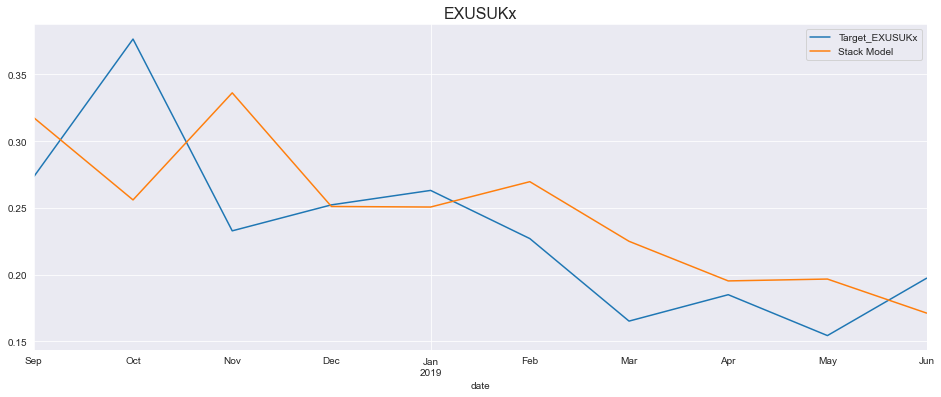

In [851]:
df_EXUSUKx_level_Forecast_sn['Target_EXUSUKx'].plot()
df_EXUSUKx_level_Forecast_sn['Stack Model'].plot()
plt.title('EXUSUKx', fontsize=16)
plt.legend()
plt.show()

In [852]:
df_pred.index = df_test.index

### Lets plot forecasts

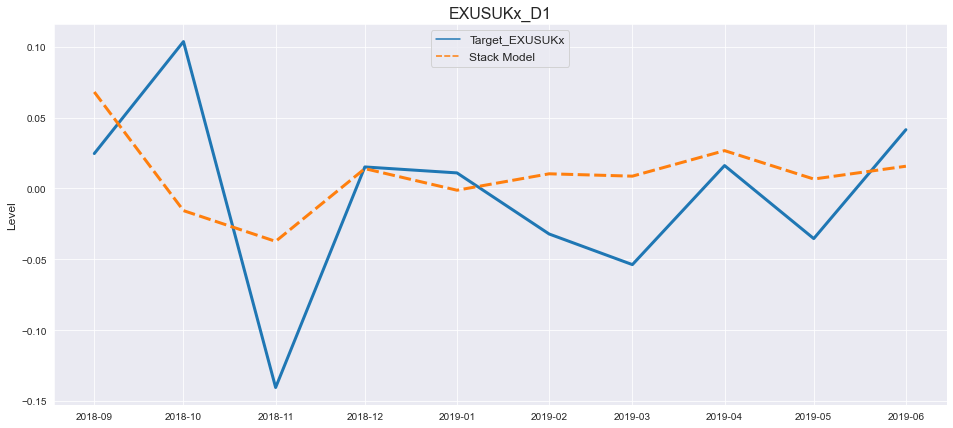

In [853]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target_EXUSUKx', 'Stack Model']], ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('EXUSUKx_D1', fontsize=16)
plt.xlabel('')
plt.ylabel('Level', fontsize=12);

In [854]:
residual = df_pred['Target_EXUSUKx'] - df_pred['Stack Model']

C:\Users\Micha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


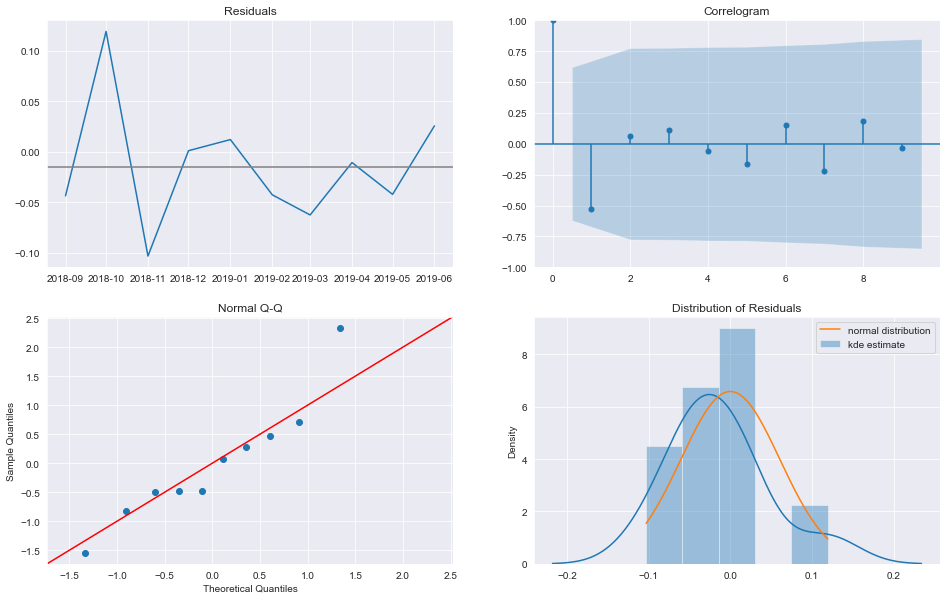

In [855]:
residual_plot(residual)

### Lets do USCONS variable third

In [856]:
y_test_USCONS = df_test.pop('target_USCONS_D1')

In [857]:
y_USCONS = df_rest.pop('target_USCONS_D1')

In [858]:
X_USCONS = df_rest[['USCONS_D1', 'USCONS_D1_L1','USCONS_D1_L2', 'USCONS_D1_L3','m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']]

In [859]:
df_test_USCONS = df_test[['USCONS_D1', 'USCONS_D1_L1','USCONS_D1_L2', 'USCONS_D1_L3','m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']]

#### The remaining data before the test set is split 2/3 base-training and 1/3 meta-training sets

In [860]:
c = len(y_USCONS)/3

In [861]:
y_meta_USCONS = y_USCONS[-int(c):]
y_base_USCONS = y_USCONS[:-int(c)]

In [862]:
X_meta_USCONS = X_USCONS[-int(c):]
X_base_USCONS = X_USCONS[:-int(c)]

### Models

In [863]:
time_split_inner = TimeSeriesSplit(n_splits = 3)

#### GridsearchCV : Lasso Regression USCONS

In [864]:
gs_las = GridSearchCV(lasso, las_params, cv=time_split_inner, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_las.fit(X_base_USCONS, y_base_USCONS)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Lasso(alpha=0.03, fit_intercept=1), n_jobs=-1,
             param_grid={'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1],
                         'fit_intercept': [1, 0]},
             scoring='neg_mean_squared_error', verbose=1)

#### GridsearchCV : two-Layer neural network USCONS

In [865]:
gs_mlp = GridSearchCV(mlp, mlp_params, cv=time_split_inner, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_mlp.fit(X_base_USCONS, y_base_USCONS)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=MLPRegressor(alpha=1e-06, early_stopping=True,
                                    hidden_layer_sizes=(24,), max_iter=20000,
                                    random_state=0),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'tanh'],
                         'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001],
                         'hidden_layer_sizes': [(24,), (36,), (24, 24),
                                                (24, 12), (36, 24), (36, 12)]},
             scoring='neg_mean_squared_error', verbose=1)

#### GridsearchCV : Random Forest USCONS

In [866]:
gs_rf = GridSearchCV(rf, rf_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                     n_jobs=-1, verbose=1)

gs_rf.fit(X_base_USCONS, y_base_USCONS)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(max_features='sqrt',
                                             min_samples_split=3,
                                             n_estimators=400, random_state=0),
             n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'min_samples_split': [2, 3, 4, 5, 6, 7],
                         'n_estimators': range(300, 500, 25)},
             scoring='neg_mean_squared_error', verbose=1)

#### GridsearchCV : XGBoost USCONS

In [867]:
### this is just here to ensure an error doesn't occour when running code
import xgboost           as xgb

In [868]:
xgb = xgb.XGBRegressor(n_estimators=100, gamma=200, eta=0.1, subsample=1, objective='reg:squarederror', random_state=0)

xgb_params = {'n_estimators': range(70, 140, 10),
              'subsample': [0.5, 0.75, 1],
              'eta': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
              'gamma': range(150, 160, 10)}

In [869]:
gs_xgb = GridSearchCV(xgb, xgb_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=1)

gs_xgb.fit(X_base_USCONS, y_base_USCONS)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.1,
                                    eval_metric=None, gamma=200, gpu_id=None,
                                    grow_policy=None, importance_type...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=0,
 

### Linear Support Vector Regression

In [870]:
gs_svr = GridSearchCV(svr, svr_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_svr.fit(X_base_GS10, y_base_GS10)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LinearSVR(C=35, epsilon=10,
                                 loss='squared_epsilon_insensitive',
                                 max_iter=30000, random_state=8),
             n_jobs=-1,
             param_grid={'C': [33, 34, 35, 36, 37, 38, 39, 40, 41],
                         'epsilon': [8, 9, 10, 11, 12, 13, 14],
                         'fit_intercept': [0, 1]},
             scoring='neg_mean_squared_error', verbose=1)

#### Support Vector Machine

In [871]:
gs_svm = GridSearchCV(svm, svm_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_svm.fit(X_base_GS10, y_base_GS10)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=SVR(C=0.1, gamma='auto', max_iter=30000), n_jobs=-1,
             param_grid={'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'gamma': ['scale', 'auto', 0.2],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             scoring='neg_mean_squared_error', verbose=1)

# Training & Meta Model

In [872]:
est_meta = pd.DataFrame(y_meta_USCONS)

In [873]:
est_meta['las_pred'] = gs_las.predict(X_meta_USCONS)
est_meta['mlp_pred'] = gs_mlp.predict(X_meta_USCONS)
est_meta['rf_pred'] = gs_rf.predict(X_meta_USCONS)
est_meta['xgb_pred'] = gs_xgb.predict(X_meta_USCONS)
est_meta['svr_pred'] = gs_svr.predict(X_meta_USCONS)
est_meta['svm_pred'] = gs_svm.predict(X_meta_USCONS)

In [874]:
y_meta = est_meta.pop('target_USCONS_D1')

###### Linear Regression as the final stage

In [875]:
meta = LinearRegression()

In [876]:
meta.fit(est_meta, y_meta_USCONS)

LinearRegression()

### Predictions on test data

In [877]:
y_test_USCONS

date
2018-09-01    0.020495
2018-10-01   -0.065843
2018-11-01   -0.025421
2018-12-01    0.101494
2019-01-01   -0.074715
2019-02-01    0.151846
2019-03-01    0.043019
2019-04-01   -0.064060
2019-05-01    0.025544
2019-06-01   -0.141232
Name: target_USCONS_D1, dtype: float64

In [878]:
def reg_scoring(X, y_USCONS, meta, reg_dict):
    
    test1_scores = []
    test2_scores = []
    
    df_pred = pd.DataFrame(columns=reg_dict.keys()) # Columns of DF will accord with reg_dict keys
    
    # Loop through Dictionary items
    for key, reg in reg_dict.items():
        
        pred_y = reg.predict(X)
        df_pred[key] = pd.Series(pred_y).transpose()
        
        # Computing test scores for each model
        test1_scores.append(round(mean_absolute_error(y_USCONS, pred_y), 4))
        test2_scores.append(round(mean_squared_error(y_USCONS, pred_y, squared=False), 4))
        
    # Generate results DataFrame
    results = pd.DataFrame({'Model': list(reg_dict.keys()), 
                            'Mean Absolute Error': test1_scores,
                            'Root Mean Squared Error': test2_scores
                            })

    # Generate Stack Model's predictions, and test scores
    df_pred['Stack Model'] = meta.predict(df_pred) # Adding 'Stack Model' to DataFrame of predictions
    
    s1 = round(mean_absolute_error(y_USCONS, df_pred['Stack Model']), 4)
    s2 = round(mean_squared_error(y_USCONS, df_pred['Stack Model'], squared=False), 4)
    
    
    # Add target variable to the DataFrame of predictions
    df_pred['Target_USCONS'] = y_USCONS.tolist()
        
        
    # Inserting the Stack scores to the results DataFrame
    row1 = ['Stack Model', s1, s2]
    results.loc[len(results)] = row1
    
    return results, df_pred

In [879]:
reg_dict = {
    'Lasso Regression': gs_las,
    'Multi-Layer Perceptron': gs_mlp, 
    'Random Forest': gs_rf,
    'XG Boost': gs_xgb,
    'Support Vector Regression' : gs_svr,
    'Support Vector Machine' : gs_svm
}

In [880]:
meta.get_params(deep=True)

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

### Comparative Test Scores

In [881]:
scores, df_pred = reg_scoring(df_test_USCONS, y_test_USCONS, meta, reg_dict)

In [882]:
scores

Model  Mean Absolute Error  Root Mean Squared Error
0           Lasso Regression               0.0714                   0.0842
1     Multi-Layer Perceptron               0.0799                   0.0927
2              Random Forest               0.0723                   0.0844
3                   XG Boost               0.0714                   0.0842
4  Support Vector Regression               0.0714                   0.0842
5     Support Vector Machine               0.0792                   0.0941
6                Stack Model               0.0680                   0.0827

In [883]:
meta.score(est_meta,y_meta_USCONS, sample_weight=None)

0.2045596673977802

In [884]:
r2_score(df_pred['Target_USCONS'],df_pred[['Stack Model']])

0.03459174593133596

In [885]:
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [886]:
r_squared(df_pred['Target_USCONS'],df_pred['Stack Model'])

0.03459174593133596

In [887]:
meta.coef_

array([ 0.        , -0.10142238,  0.57920492,  0.        ,  0.        ,
        0.40890887])

### The Stacked model has the lowest MAE and RSME

### Lets transform the series back to level

In [888]:
df_USCONS_differenced_Forecast = df_pred[['Target_USCONS', "Stack Model"]]

In [889]:
df_USCONS_differenced_Forecast['date'] = pd.date_range(start= '01-SEP-2018', end= '01-JUN-2019', freq='MS')

<ipython-input-889-a795bc1c3f37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_USCONS_differenced_Forecast['date'] = pd.date_range(start= '01-SEP-2018', end= '01-JUN-2019', freq='MS')


In [890]:
df_USCONS_differenced_Forecast = df_USCONS_differenced_Forecast.set_index('date')

In [891]:
df_USCONS_differenced_Forecast.head(12)

Target_USCONS  Stack Model
date                                  
2018-09-01       0.020495     0.025122
2018-10-01      -0.065843    -0.000390
2018-11-01      -0.025421     0.018635
2018-12-01       0.101494    -0.002122
2019-01-01      -0.074715    -0.059278
2019-02-01       0.151846     0.018717
2019-03-01       0.043019    -0.044860
2019-04-01      -0.064060     0.016499
2019-05-01       0.025544     0.018670
2019-06-01      -0.141232    -0.002817

In [892]:
df_USCONS_level_Forecast = df_USCONS_differenced_Forecast.head(12)

In [893]:
df_USCONS_level_Forecast['Target_USCONS'] = df_USCONS_differenced_Forecast['Target_USCONS'] + df_test_actuals_USCONS
df_USCONS_level_Forecast["Stack Model"] = df_USCONS_differenced_Forecast["Stack Model"] + df_test_actuals_USCONS

In [894]:
df_USCONS_level_Forecast_sn = df_USCONS_level_Forecast

In [895]:
df_USCONS_level_Forecast_sn['Target_USCONS'] = df_USCONS_level_Forecast['Target_USCONS'] * df['sn_USCONS'].tail(10)
df_USCONS_level_Forecast_sn["Stack Model"] = df_USCONS_level_Forecast["Stack Model"] * df['sn_USCONS'].tail(10)

In [896]:
df_USCONS_level_Forecast.head(10)

Target_USCONS  Stack Model
date                                  
2018-09-01       8.899737     8.904359
2018-10-01       8.844947     8.910409
2018-11-01       8.816746     8.860794
2018-12-01       8.937208     8.833391
2019-01-01       8.845403     8.860840
2019-02-01       8.999076     8.865915
2019-03-01       9.045908     8.957972
2019-04-01       8.974195     9.054738
2019-05-01       8.997384     8.990513
2019-06-01       8.877303     9.015985

In [897]:
df_USCONS_level_Forecast_sn.head(10)

Target_USCONS  Stack Model
date                                  
2018-09-01       8.899737     8.904359
2018-10-01       8.844947     8.910409
2018-11-01       8.816746     8.860794
2018-12-01       8.937208     8.833391
2019-01-01       8.845403     8.860840
2019-02-01       8.999076     8.865915
2019-03-01       9.045908     8.957972
2019-04-01       8.974195     9.054738
2019-05-01       8.997384     8.990513
2019-06-01       8.877303     9.015985

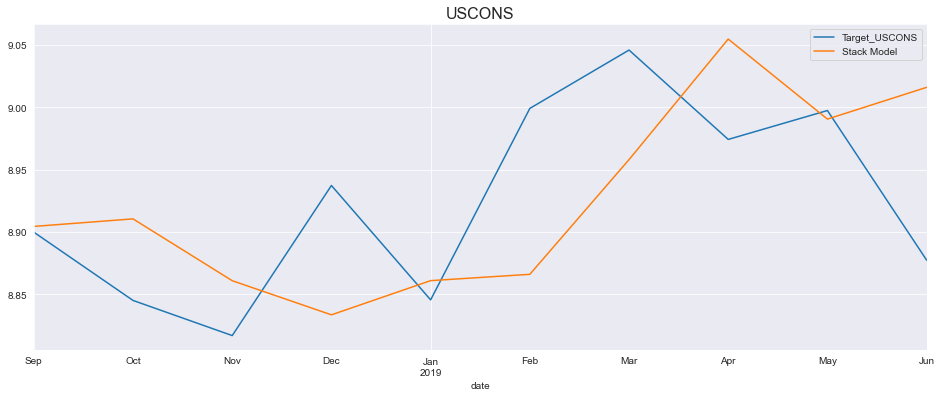

In [898]:
df_USCONS_level_Forecast_sn['Target_USCONS'].plot()
df_USCONS_level_Forecast_sn['Stack Model'].plot()
plt.title('USCONS', fontsize=16)
plt.legend()
plt.show()

In [899]:
df_pred.index = df_test.index

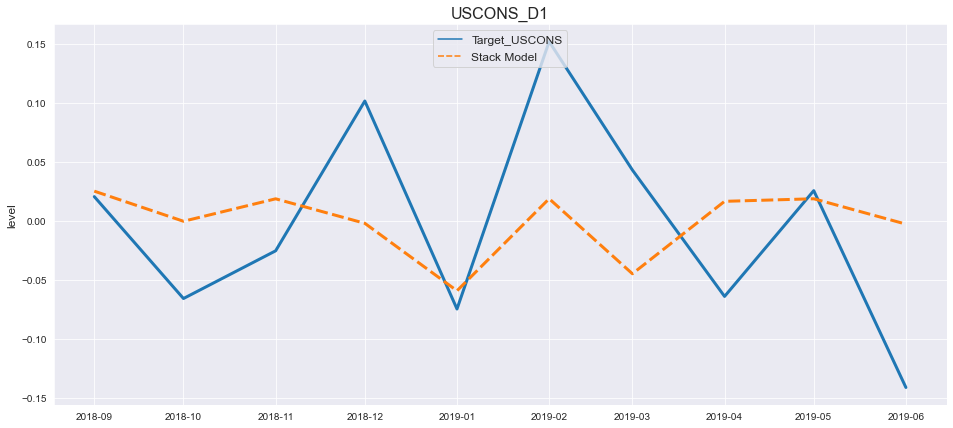

In [900]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target_USCONS', 'Stack Model']], ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('USCONS_D1', fontsize=16)
plt.xlabel('')
plt.ylabel('level', fontsize=12);

In [901]:
residual = df_pred['Target_USCONS'] - df_pred['Stack Model']

C:\Users\Micha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


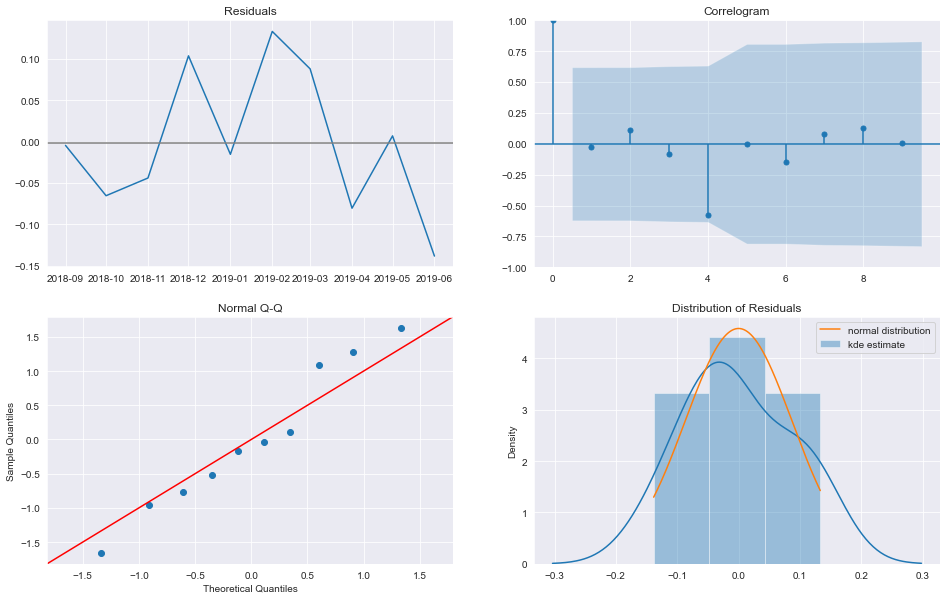

In [902]:
residual_plot(residual)